In [1]:
!pip install opencv-python torchsummary scikit-learn torchviz utils

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda


In [4]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot

In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

    
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c


In [6]:
base_path = './data'
base_folder = "Covid-19 Image Dataset"
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'
data_dir = os.path.join(base_path, classic_folder)

In [7]:
batch_size = 64
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

In [8]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
label_dict = {
    0 : 'Covid', 
    1 : 'Normal', 
    2 : 'Viral Pneumonia'
}

['Covid', 'Normal', 'Viral Pneumonia']


In [9]:
# Number of training epochs
num_epochs = 20

#All images will be resized to this size using a transformer.
img_size = 128 * 3

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = img_size

# Size of feature maps in generator
ngf = img_size

# Size of feature maps in discriminator
ndf = img_size

# No of labels
nb_label = len(labels)

# Learning rate for optimizers
lr = 0.00003
lr_d = 0.00001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.CrossEntropyLoss().to(device) #For classification

s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.FloatTensor(batch_size, nb_label).to(device)
noise = torch.FloatTensor(batch_size, nz).to(device)

s_label = Variable(s_label)
c_label = Variable(c_label)
print(s_label.shape)
print(c_label.shape)
print(noise.shape)

noise = Variable(noise)

noise_fixed = torch.FloatTensor(3, nz).to(device)
noise_data = np.random.normal(0, 1, (3, nz))
noise_fixed.data.copy_(torch.tensor(noise_data))
noise_fixed = Variable(noise_fixed)

label_fixed = torch.FloatTensor(3, 3).to(device)
label_onehot = np.zeros((3, nb_label))
label_fixed_data = [0, 1, 2]
label_onehot[np.arange(1), label_fixed_data] = 1
label_fixed.data.copy_(torch.tensor(label_onehot))
label_fixed = Variable(label_fixed)

print(noise_fixed.shape)
print(label_fixed.shape)

torch.Size([64])
torch.Size([64, 3])
torch.Size([64, 384])
torch.Size([3, 384])
torch.Size([3, 3])


In [10]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'GANAug')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[0])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[1])),
    lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN/' + label_dict[2]))]:  # create directories
    try:
        func()
    except Exception as error:
        print(error)
        continue

[Errno 17] File exists: './GANAug'
[Errno 17] File exists: './GANAug/model'
[Errno 17] File exists: './GANAug/plots'
[Errno 17] File exists: './GANAug/plots/ACGAN'
[Errno 17] File exists: './GANAug/output_images'
[Errno 17] File exists: './GANAug/output_images/ACGAN'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Covid'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Normal'
[Errno 17] File exists: './GANAug/output_images/ACGAN/Viral Pneumonia'


In [11]:
matrix_fields = [
    'G_losses',
    'G_class_losses',
    'G_syn_losses',
    'D_losses',
    'D_real_losses',
    'D_fake_losses',
    'D_class_losses',
    'D_syn_losses',
    'Accuracy',
    'Losses'
]
metrics = {field: list() for field in matrix_fields}

In [12]:
def load_dataset(train_dir=train_path, test_dir=test_path):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=1)

    test_data = datasets.ImageFolder(test_dir ,transform=transform)
    test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=1)

    return train_loader, test_loader, train_data, test_data

In [13]:
train_loader, test_loader, train_data, test_data = load_dataset()

In [14]:
generator = Generator(input_dim=nz, output_dim=nc, input_size=ngf, class_num=nb_label).to(device)
discriminator = Discriminator(input_dim=nc, output_dim=1, input_size=ndf, class_num=nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [15]:
g_output = generator(torch.rand((batch_size, nz)).to(device), torch.ones((batch_size, nb_label)).to(device))
print(g_output.shape)

torch.Size([64, 3, 384, 384])


In [16]:
s_output, c_output = discriminator(torch.rand(g_output.shape).to(device))
print(s_output.shape)
print(c_output.shape)
del g_output, s_output, c_output

torch.Size([64, 1])
torch.Size([64, 3])


In [17]:
!pip install torchviz

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [18]:
print(generator)
print(discriminator)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=387, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1179648, bias=True)
    (4): BatchNorm1d(1179648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [19]:
SHOW = True
if SHOW:
    summary(generator, [[nz], [nc]], batch_size=16, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [16, 1024]         397,312
       BatchNorm1d-2                 [16, 1024]           2,048
              ReLU-3                 [16, 1024]               0
            Linear-4              [16, 1179648]   1,209,139,200
       BatchNorm1d-5              [16, 1179648]       2,359,296
              ReLU-6              [16, 1179648]               0
   ConvTranspose2d-7         [16, 64, 192, 192]         131,136
       BatchNorm2d-8         [16, 64, 192, 192]             128
              ReLU-9         [16, 64, 192, 192]               0
  ConvTranspose2d-10          [16, 3, 384, 384]           3,075
             Tanh-11          [16, 3, 384, 384]               0
Total params: 1,212,032,195
Trainable params: 1,212,032,195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0

In [20]:
if SHOW:
    summary(discriminator, (nc, img_size, img_size), batch_size=16, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 192, 192]           3,136
         LeakyReLU-2         [16, 64, 192, 192]               0
            Conv2d-3          [16, 128, 96, 96]         131,200
       BatchNorm2d-4          [16, 128, 96, 96]             256
         LeakyReLU-5          [16, 128, 96, 96]               0
            Linear-6                 [16, 1024]   1,207,960,576
       BatchNorm1d-7                 [16, 1024]           2,048
         LeakyReLU-8                 [16, 1024]               0
            Linear-9                    [16, 1]           1,025
          Sigmoid-10                    [16, 1]               0
           Linear-11                    [16, 3]           3,075
Total params: 1,208,101,316
Trainable params: 1,208,101,316
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2

In [21]:
SHOW_IMG = False
if SHOW_IMG:
    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 

In [22]:
if SHOW_IMG:
    modeltorchviz(generator, torch.randn(16, nz).requires_grad_(True), torch.randn(16, nb_label).requires_grad_(True))

In [23]:
if SHOW_IMG:
    modeltorchviz(discriminator, torch.randn(1, nc, ndf, ndf).requires_grad_(True))

In [24]:
def test(predict, labels):
    correct = 0
    predict = torch.argmax(predict, dim=1)
    labels = torch.argmax(labels, dim=1)
    correct = predict.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [25]:
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            img, label = img.to(device), label.to(device)
            label = one_hot(label, num_classes=nb_label)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size, 3).copy_(label)
        s_output, c_output = discriminator(img)
        s_errD_real = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        
        correct, length = test(c_output, c_label)

        # train with fake
        noise_data = np.random.normal(0, 1, (batch_size, nz))
        noise.resize_(batch_size, nz).data.copy_(torch.tensor(noise_data))
        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        c_label.resize_(batch_size, nb_label).data.copy_(torch.tensor(label_onehot))
        fake = generator(noise, c_label)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake)
        s_errD_fake = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD = s_errD_real + s_errD_fake
        errD.backward()
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.resize_(batch_size, 1).data.fill_(real_label)
        fake = generator(noise, c_label)
        s_output, c_output = discriminator(fake)
        s_errG = s_criterion(s_output[:,0], s_label.resize_(batch_size))
        c_errG = c_criterion(c_output, c_label)

        errG = s_errG + c_errG
        errG.backward()
        optimizerG.step()
        metrics['G_losses'].append(errG.item())
        metrics['G_class_losses'].append(c_errG.item())
        metrics['G_syn_losses'].append(s_errG.item())
        metrics['D_losses'].append(errD.item())
        metrics['D_real_losses'].append(errD_real.item())
        metrics['D_fake_losses'].append(errD_fake.item())
        metrics['D_class_losses'].append((c_errD_real + c_errD_fake).item())
        metrics['D_syn_losses'].append((s_errD_real + s_errD_fake).item())
        metrics['Losses'].append((errG + errD).item())
        metrics['Accuracy'].append(correct/length)

        print('[%d/%d][%d/%d] ========== Loss_D: %.4f, Loss_G: %.4f, Acc_G: %d/%d = %.4f'
              % (epoch + 1, num_epochs, i + 1, len(train_loader),
                 errD.data, errG.data, correct, length, 100.0*correct/length))
        if i % 100 == 0:
            vutils.save_image(img, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)
            fake = generator(noise_fixed, label_fixed)
            for j in range(len(fake)):
                vutils.save_image(fake[j].data,
                        '%s/fake_samples_epoch_%03d.jpg' % ('./GANAug/output_images/ACGAN/' + label_dict[label_fixed_data[j]], epoch), 
                                  normalize=True)

    # do checkpointing
    if (epoch + 1) % 5 == 0:
        torch.save(generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
        torch.save(discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))

  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[1/20][1/95] ========== Loss_D: 1.4315, Loss_G: 1.9485, Acc_G: 14/64 = 21.8750


  2%|█▊                                                                                       | 2/95 [00:07<05:43,  3.70s/it]

[1/20][2/95] ========== Loss_D: 1.4304, Loss_G: 1.9750, Acc_G: 20/64 = 31.2500


  3%|██▊                                                                                      | 3/95 [00:11<05:36,  3.66s/it]

[1/20][3/95] ========== Loss_D: 1.4334, Loss_G: 1.8598, Acc_G: 17/64 = 26.5625


  4%|███▋                                                                                     | 4/95 [00:14<05:05,  3.36s/it]

[1/20][4/95] ========== Loss_D: 1.4414, Loss_G: 1.8849, Acc_G: 13/64 = 20.3125


  5%|████▋                                                                                    | 5/95 [00:17<04:58,  3.31s/it]

[1/20][5/95] ========== Loss_D: 1.4381, Loss_G: 1.8889, Acc_G: 23/64 = 35.9375


  6%|█████▌                                                                                   | 6/95 [00:20<04:56,  3.34s/it]

[1/20][6/95] ========== Loss_D: 1.4459, Loss_G: 1.8328, Acc_G: 19/64 = 29.6875


  7%|██████▌                                                                                  | 7/95 [00:23<04:37,  3.15s/it]

[1/20][7/95] ========== Loss_D: 1.4451, Loss_G: 1.8152, Acc_G: 18/64 = 28.1250


  8%|███████▍                                                                                 | 8/95 [00:26<04:37,  3.19s/it]

[1/20][8/95] ========== Loss_D: 1.4436, Loss_G: 1.9541, Acc_G: 19/64 = 29.6875


  9%|████████▍                                                                                | 9/95 [00:30<04:50,  3.38s/it]

[1/20][9/95] ========== Loss_D: 1.4498, Loss_G: 1.9062, Acc_G: 15/64 = 23.4375


 11%|█████████▎                                                                              | 10/95 [00:33<04:42,  3.32s/it]

[1/20][10/95] ========== Loss_D: 1.4506, Loss_G: 1.8093, Acc_G: 18/64 = 28.1250


 12%|██████████▏                                                                             | 11/95 [00:37<04:40,  3.34s/it]

[1/20][11/95] ========== Loss_D: 1.4608, Loss_G: 1.8342, Acc_G: 15/64 = 23.4375


 13%|███████████                                                                             | 12/95 [00:40<04:24,  3.19s/it]

[1/20][12/95] ========== Loss_D: 1.4441, Loss_G: 1.8647, Acc_G: 15/64 = 23.4375


 14%|████████████                                                                            | 13/95 [00:43<04:28,  3.28s/it]

[1/20][13/95] ========== Loss_D: 1.4513, Loss_G: 1.8576, Acc_G: 15/64 = 23.4375


 15%|████████████▉                                                                           | 14/95 [00:47<04:30,  3.34s/it]

[1/20][14/95] ========== Loss_D: 1.4430, Loss_G: 1.8493, Acc_G: 23/64 = 35.9375


 16%|█████████████▉                                                                          | 15/95 [00:50<04:27,  3.34s/it]

[1/20][15/95] ========== Loss_D: 1.4542, Loss_G: 1.8156, Acc_G: 11/64 = 17.1875


 17%|██████████████▊                                                                         | 16/95 [00:53<04:18,  3.28s/it]

[1/20][16/95] ========== Loss_D: 1.4631, Loss_G: 1.8065, Acc_G: 12/64 = 18.7500


 18%|███████████████▋                                                                        | 17/95 [00:56<04:05,  3.14s/it]

[1/20][17/95] ========== Loss_D: 1.4675, Loss_G: 1.8802, Acc_G: 23/64 = 35.9375


 19%|████████████████▋                                                                       | 18/95 [00:59<04:03,  3.17s/it]

[1/20][18/95] ========== Loss_D: 1.4796, Loss_G: 1.7817, Acc_G: 13/64 = 20.3125


 20%|█████████████████▌                                                                      | 19/95 [01:02<03:53,  3.07s/it]

[1/20][19/95] ========== Loss_D: 1.4713, Loss_G: 1.7153, Acc_G: 18/64 = 28.1250


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:57,  3.17s/it]

[1/20][20/95] ========== Loss_D: 1.4645, Loss_G: 1.7249, Acc_G: 20/64 = 31.2500


 22%|███████████████████▍                                                                    | 21/95 [01:09<03:56,  3.20s/it]

[1/20][21/95] ========== Loss_D: 1.4796, Loss_G: 1.7888, Acc_G: 21/64 = 32.8125


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:41,  3.03s/it]

[1/20][22/95] ========== Loss_D: 1.4757, Loss_G: 1.7782, Acc_G: 16/64 = 25.0000


 24%|█████████████████████▎                                                                  | 23/95 [01:14<03:36,  3.01s/it]

[1/20][23/95] ========== Loss_D: 1.4848, Loss_G: 1.8848, Acc_G: 17/64 = 26.5625


 25%|██████████████████████▏                                                                 | 24/95 [01:17<03:28,  2.94s/it]

[1/20][24/95] ========== Loss_D: 1.4564, Loss_G: 1.7762, Acc_G: 14/64 = 21.8750


 26%|███████████████████████▏                                                                | 25/95 [01:20<03:31,  3.02s/it]

[1/20][25/95] ========== Loss_D: 1.4651, Loss_G: 1.7647, Acc_G: 12/64 = 18.7500


 27%|████████████████████████                                                                | 26/95 [01:23<03:20,  2.90s/it]

[1/20][26/95] ========== Loss_D: 1.4885, Loss_G: 1.7944, Acc_G: 14/64 = 21.8750


 28%|█████████████████████████                                                               | 27/95 [01:26<03:28,  3.07s/it]

[1/20][27/95] ========== Loss_D: 1.4889, Loss_G: 1.7711, Acc_G: 19/64 = 29.6875


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:27,  3.10s/it]

[1/20][28/95] ========== Loss_D: 1.4838, Loss_G: 1.7662, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:33<03:31,  3.20s/it]

[1/20][29/95] ========== Loss_D: 1.4780, Loss_G: 1.7582, Acc_G: 16/64 = 25.0000


 32%|███████████████████████████▊                                                            | 30/95 [01:36<03:28,  3.21s/it]

[1/20][30/95] ========== Loss_D: 1.4862, Loss_G: 1.6886, Acc_G: 21/64 = 32.8125


 33%|████████████████████████████▋                                                           | 31/95 [01:39<03:20,  3.13s/it]

[1/20][31/95] ========== Loss_D: 1.4783, Loss_G: 1.8345, Acc_G: 20/64 = 31.2500


 34%|█████████████████████████████▋                                                          | 32/95 [01:42<03:11,  3.04s/it]

[1/20][32/95] ========== Loss_D: 1.4966, Loss_G: 1.7608, Acc_G: 16/64 = 25.0000


 35%|██████████████████████████████▌                                                         | 33/95 [01:45<03:04,  2.97s/it]

[1/20][33/95] ========== Loss_D: 1.5192, Loss_G: 1.7624, Acc_G: 20/64 = 31.2500


 36%|███████████████████████████████▍                                                        | 34/95 [01:48<03:02,  2.99s/it]

[1/20][34/95] ========== Loss_D: 1.4922, Loss_G: 1.7790, Acc_G: 15/64 = 23.4375


 37%|████████████████████████████████▍                                                       | 35/95 [01:51<02:59,  3.00s/it]

[1/20][35/95] ========== Loss_D: 1.5193, Loss_G: 1.6220, Acc_G: 13/64 = 20.3125


 38%|█████████████████████████████████▎                                                      | 36/95 [01:54<02:58,  3.03s/it]

[1/20][36/95] ========== Loss_D: 1.5037, Loss_G: 1.7964, Acc_G: 15/64 = 23.4375


 39%|██████████████████████████████████▎                                                     | 37/95 [01:57<02:59,  3.09s/it]

[1/20][37/95] ========== Loss_D: 1.5089, Loss_G: 1.6550, Acc_G: 18/64 = 28.1250


 40%|███████████████████████████████████▏                                                    | 38/95 [02:01<03:00,  3.17s/it]

[1/20][38/95] ========== Loss_D: 1.4889, Loss_G: 1.7541, Acc_G: 25/64 = 39.0625


 41%|████████████████████████████████████▏                                                   | 39/95 [02:04<03:01,  3.24s/it]

[1/20][39/95] ========== Loss_D: 1.5382, Loss_G: 1.7002, Acc_G: 16/64 = 25.0000


 42%|█████████████████████████████████████                                                   | 40/95 [02:07<02:52,  3.13s/it]

[1/20][40/95] ========== Loss_D: 1.5315, Loss_G: 1.7038, Acc_G: 12/64 = 18.7500


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:10<02:49,  3.13s/it]

[1/20][41/95] ========== Loss_D: 1.5504, Loss_G: 1.6693, Acc_G: 19/64 = 29.6875


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:13<02:45,  3.13s/it]

[1/20][42/95] ========== Loss_D: 1.5452, Loss_G: 1.6108, Acc_G: 14/64 = 21.8750


 45%|███████████████████████████████████████▊                                                | 43/95 [02:16<02:43,  3.15s/it]

[1/20][43/95] ========== Loss_D: 1.5296, Loss_G: 1.6452, Acc_G: 17/64 = 26.5625


 46%|████████████████████████████████████████▊                                               | 44/95 [02:19<02:41,  3.16s/it]

[1/20][44/95] ========== Loss_D: 1.5561, Loss_G: 1.7175, Acc_G: 22/64 = 34.3750


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:23<02:36,  3.14s/it]

[1/20][45/95] ========== Loss_D: 1.5433, Loss_G: 1.5713, Acc_G: 15/64 = 23.4375


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:26<02:38,  3.24s/it]

[1/20][46/95] ========== Loss_D: 1.5401, Loss_G: 1.7410, Acc_G: 16/64 = 25.0000


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:29<02:34,  3.23s/it]

[1/20][47/95] ========== Loss_D: 1.5477, Loss_G: 1.6504, Acc_G: 13/64 = 20.3125


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:32<02:27,  3.15s/it]

[1/20][48/95] ========== Loss_D: 1.5505, Loss_G: 1.6269, Acc_G: 16/64 = 25.0000


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:36<02:33,  3.33s/it]

[1/20][49/95] ========== Loss_D: 1.5447, Loss_G: 1.6472, Acc_G: 18/64 = 28.1250


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:39<02:25,  3.24s/it]

[1/20][50/95] ========== Loss_D: 1.5362, Loss_G: 1.5274, Acc_G: 16/64 = 25.0000


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:42<02:15,  3.07s/it]

[1/20][51/95] ========== Loss_D: 1.5594, Loss_G: 1.6044, Acc_G: 17/64 = 26.5625


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:46<02:29,  3.48s/it]

[1/20][52/95] ========== Loss_D: 1.5493, Loss_G: 1.6125, Acc_G: 18/64 = 28.1250


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:49<02:19,  3.32s/it]

[1/20][53/95] ========== Loss_D: 1.5764, Loss_G: 1.6074, Acc_G: 13/64 = 20.3125


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:52<02:11,  3.21s/it]

[1/20][54/95] ========== Loss_D: 1.5708, Loss_G: 1.6256, Acc_G: 18/64 = 28.1250


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:56<02:15,  3.39s/it]

[1/20][55/95] ========== Loss_D: 1.5655, Loss_G: 1.5782, Acc_G: 29/64 = 45.3125


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [02:59<02:14,  3.44s/it]

[1/20][56/95] ========== Loss_D: 1.5663, Loss_G: 1.6689, Acc_G: 19/64 = 29.6875


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:02<02:05,  3.30s/it]

[1/20][57/95] ========== Loss_D: 1.5809, Loss_G: 1.5472, Acc_G: 16/64 = 25.0000


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:06<02:03,  3.35s/it]

[1/20][58/95] ========== Loss_D: 1.6010, Loss_G: 1.5983, Acc_G: 21/64 = 32.8125


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:09<01:58,  3.28s/it]

[1/20][59/95] ========== Loss_D: 1.5952, Loss_G: 1.5657, Acc_G: 21/64 = 32.8125


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:12<01:53,  3.26s/it]

[1/20][60/95] ========== Loss_D: 1.5982, Loss_G: 1.4834, Acc_G: 19/64 = 29.6875


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:15<01:50,  3.25s/it]

[1/20][61/95] ========== Loss_D: 1.5673, Loss_G: 1.6321, Acc_G: 18/64 = 28.1250


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:19<01:49,  3.32s/it]

[1/20][62/95] ========== Loss_D: 1.5816, Loss_G: 1.4743, Acc_G: 16/64 = 25.0000


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:22<01:47,  3.37s/it]

[1/20][63/95] ========== Loss_D: 1.5685, Loss_G: 1.5738, Acc_G: 22/64 = 34.3750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:26<01:47,  3.48s/it]

[1/20][64/95] ========== Loss_D: 1.5935, Loss_G: 1.6033, Acc_G: 27/64 = 42.1875


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:29<01:39,  3.33s/it]

[1/20][65/95] ========== Loss_D: 1.6113, Loss_G: 1.5772, Acc_G: 11/64 = 17.1875


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:32<01:34,  3.24s/it]

[1/20][66/95] ========== Loss_D: 1.5848, Loss_G: 1.4667, Acc_G: 18/64 = 28.1250


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:36<01:33,  3.33s/it]

[1/20][67/95] ========== Loss_D: 1.6054, Loss_G: 1.6558, Acc_G: 28/64 = 43.7500


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:39<01:32,  3.42s/it]

[1/20][68/95] ========== Loss_D: 1.6158, Loss_G: 1.5910, Acc_G: 20/64 = 31.2500


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:43<01:29,  3.45s/it]

[1/20][69/95] ========== Loss_D: 1.6176, Loss_G: 1.5105, Acc_G: 19/64 = 29.6875


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:22,  3.29s/it]

[1/20][70/95] ========== Loss_D: 1.6182, Loss_G: 1.5972, Acc_G: 19/64 = 29.6875


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:49<01:18,  3.28s/it]

[1/20][71/95] ========== Loss_D: 1.5902, Loss_G: 1.4968, Acc_G: 19/64 = 29.6875


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:52<01:15,  3.29s/it]

[1/20][72/95] ========== Loss_D: 1.6278, Loss_G: 1.5672, Acc_G: 19/64 = 29.6875


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:55<01:10,  3.20s/it]

[1/20][73/95] ========== Loss_D: 1.5966, Loss_G: 1.4894, Acc_G: 18/64 = 28.1250


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:59<01:09,  3.30s/it]

[1/20][74/95] ========== Loss_D: 1.6247, Loss_G: 1.5279, Acc_G: 18/64 = 28.1250


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:02<01:06,  3.33s/it]

[1/20][75/95] ========== Loss_D: 1.6205, Loss_G: 1.6209, Acc_G: 21/64 = 32.8125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<01:00,  3.20s/it]

[1/20][76/95] ========== Loss_D: 1.6163, Loss_G: 1.5284, Acc_G: 19/64 = 29.6875


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:08<00:57,  3.18s/it]

[1/20][77/95] ========== Loss_D: 1.6282, Loss_G: 1.6362, Acc_G: 20/64 = 31.2500


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:51,  3.06s/it]

[1/20][78/95] ========== Loss_D: 1.6339, Loss_G: 1.5659, Acc_G: 21/64 = 32.8125


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:52,  3.28s/it]

[1/20][79/95] ========== Loss_D: 1.6192, Loss_G: 1.4397, Acc_G: 25/64 = 39.0625


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:49,  3.30s/it]

[1/20][80/95] ========== Loss_D: 1.6590, Loss_G: 1.6180, Acc_G: 21/64 = 32.8125


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:21<00:45,  3.25s/it]

[1/20][81/95] ========== Loss_D: 1.6414, Loss_G: 1.5590, Acc_G: 22/64 = 34.3750


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:24<00:41,  3.21s/it]

[1/20][82/95] ========== Loss_D: 1.6316, Loss_G: 1.5448, Acc_G: 17/64 = 26.5625


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:27<00:37,  3.16s/it]

[1/20][83/95] ========== Loss_D: 1.6490, Loss_G: 1.6023, Acc_G: 23/64 = 35.9375


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:31<00:34,  3.17s/it]

[1/20][84/95] ========== Loss_D: 1.6626, Loss_G: 1.5244, Acc_G: 18/64 = 28.1250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:34<00:33,  3.34s/it]

[1/20][85/95] ========== Loss_D: 1.6730, Loss_G: 1.5470, Acc_G: 18/64 = 28.1250


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:37<00:29,  3.24s/it]

[1/20][86/95] ========== Loss_D: 1.6540, Loss_G: 1.4573, Acc_G: 26/64 = 40.6250


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:26,  3.32s/it]

[1/20][87/95] ========== Loss_D: 1.6469, Loss_G: 1.5254, Acc_G: 21/64 = 32.8125


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:44<00:23,  3.41s/it]

[1/20][88/95] ========== Loss_D: 1.6673, Loss_G: 1.5795, Acc_G: 16/64 = 25.0000


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:48<00:21,  3.56s/it]

[1/20][89/95] ========== Loss_D: 1.6781, Loss_G: 1.5428, Acc_G: 20/64 = 31.2500


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:51<00:16,  3.39s/it]

[1/20][90/95] ========== Loss_D: 1.6692, Loss_G: 1.4782, Acc_G: 18/64 = 28.1250


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:54<00:13,  3.31s/it]

[1/20][91/95] ========== Loss_D: 1.6287, Loss_G: 1.4761, Acc_G: 19/64 = 29.6875


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:57<00:09,  3.17s/it]

[1/20][92/95] ========== Loss_D: 1.6694, Loss_G: 1.4400, Acc_G: 24/64 = 37.5000


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.09s/it]

[1/20][93/95] ========== Loss_D: 1.6792, Loss_G: 1.5099, Acc_G: 18/64 = 28.1250


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.05s/it]

[1/20][94/95] ========== Loss_D: 1.6749, Loss_G: 1.4845, Acc_G: 23/64 = 35.9375


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]


[1/20][95/95] ========== Loss_D: 1.4873, Loss_G: 1.9011, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[2/20][1/95] ========== Loss_D: 1.7360, Loss_G: 1.5273, Acc_G: 18/64 = 28.1250


  2%|█▊                                                                                       | 2/95 [00:06<04:53,  3.16s/it]

[2/20][2/95] ========== Loss_D: 1.7171, Loss_G: 1.5397, Acc_G: 10/64 = 15.6250


  3%|██▊                                                                                      | 3/95 [00:10<05:18,  3.46s/it]

[2/20][3/95] ========== Loss_D: 1.7022, Loss_G: 1.5411, Acc_G: 21/64 = 32.8125


  4%|███▋                                                                                     | 4/95 [00:14<05:26,  3.59s/it]

[2/20][4/95] ========== Loss_D: 1.6714, Loss_G: 1.5521, Acc_G: 26/64 = 40.6250


  5%|████▋                                                                                    | 5/95 [00:17<05:00,  3.34s/it]

[2/20][5/95] ========== Loss_D: 1.7319, Loss_G: 1.6155, Acc_G: 19/64 = 29.6875


  6%|█████▌                                                                                   | 6/95 [00:20<04:43,  3.18s/it]

[2/20][6/95] ========== Loss_D: 1.6818, Loss_G: 1.5280, Acc_G: 25/64 = 39.0625


  7%|██████▌                                                                                  | 7/95 [00:23<04:48,  3.27s/it]

[2/20][7/95] ========== Loss_D: 1.7091, Loss_G: 1.4708, Acc_G: 21/64 = 32.8125


  8%|███████▍                                                                                 | 8/95 [00:27<04:56,  3.41s/it]

[2/20][8/95] ========== Loss_D: 1.7565, Loss_G: 1.5496, Acc_G: 21/64 = 32.8125


  9%|████████▍                                                                                | 9/95 [00:30<04:45,  3.32s/it]

[2/20][9/95] ========== Loss_D: 1.7369, Loss_G: 1.5282, Acc_G: 20/64 = 31.2500


 11%|█████████▎                                                                              | 10/95 [00:33<04:39,  3.29s/it]

[2/20][10/95] ========== Loss_D: 1.7132, Loss_G: 1.4209, Acc_G: 15/64 = 23.4375


 12%|██████████▏                                                                             | 11/95 [00:37<04:50,  3.46s/it]

[2/20][11/95] ========== Loss_D: 1.7134, Loss_G: 1.5081, Acc_G: 25/64 = 39.0625


 13%|███████████                                                                             | 12/95 [00:40<04:38,  3.35s/it]

[2/20][12/95] ========== Loss_D: 1.6964, Loss_G: 1.4032, Acc_G: 20/64 = 31.2500


 14%|████████████                                                                            | 13/95 [00:43<04:32,  3.33s/it]

[2/20][13/95] ========== Loss_D: 1.7819, Loss_G: 1.4743, Acc_G: 15/64 = 23.4375


 15%|████████████▉                                                                           | 14/95 [00:47<04:34,  3.39s/it]

[2/20][14/95] ========== Loss_D: 1.7105, Loss_G: 1.4878, Acc_G: 15/64 = 23.4375


 16%|█████████████▉                                                                          | 15/95 [00:50<04:20,  3.26s/it]

[2/20][15/95] ========== Loss_D: 1.7434, Loss_G: 1.4781, Acc_G: 17/64 = 26.5625


 17%|██████████████▊                                                                         | 16/95 [00:53<04:14,  3.22s/it]

[2/20][16/95] ========== Loss_D: 1.7623, Loss_G: 1.4811, Acc_G: 18/64 = 28.1250


 18%|███████████████▋                                                                        | 17/95 [00:56<04:07,  3.17s/it]

[2/20][17/95] ========== Loss_D: 1.7597, Loss_G: 1.3642, Acc_G: 26/64 = 40.6250


 19%|████████████████▋                                                                       | 18/95 [00:59<04:05,  3.19s/it]

[2/20][18/95] ========== Loss_D: 1.7400, Loss_G: 1.4687, Acc_G: 30/64 = 46.8750


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:04,  3.22s/it]

[2/20][19/95] ========== Loss_D: 1.7779, Loss_G: 1.6177, Acc_G: 21/64 = 32.8125


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:15,  3.41s/it]

[2/20][20/95] ========== Loss_D: 1.7322, Loss_G: 1.4193, Acc_G: 28/64 = 43.7500


 22%|███████████████████▍                                                                    | 21/95 [01:09<03:59,  3.24s/it]

[2/20][21/95] ========== Loss_D: 1.7411, Loss_G: 1.4633, Acc_G: 13/64 = 20.3125


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:48,  3.14s/it]

[2/20][22/95] ========== Loss_D: 1.7276, Loss_G: 1.4073, Acc_G: 10/64 = 15.6250


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:39,  3.05s/it]

[2/20][23/95] ========== Loss_D: 1.7471, Loss_G: 1.4115, Acc_G: 23/64 = 35.9375


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:45,  3.18s/it]

[2/20][24/95] ========== Loss_D: 1.7444, Loss_G: 1.4276, Acc_G: 21/64 = 32.8125


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:33,  3.06s/it]

[2/20][25/95] ========== Loss_D: 1.7096, Loss_G: 1.5807, Acc_G: 21/64 = 32.8125


 27%|████████████████████████                                                                | 26/95 [01:24<03:31,  3.07s/it]

[2/20][26/95] ========== Loss_D: 1.7471, Loss_G: 1.4227, Acc_G: 17/64 = 26.5625


 28%|█████████████████████████                                                               | 27/95 [01:28<03:32,  3.12s/it]

[2/20][27/95] ========== Loss_D: 1.7029, Loss_G: 1.4314, Acc_G: 20/64 = 31.2500


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:31,  3.15s/it]

[2/20][28/95] ========== Loss_D: 1.7615, Loss_G: 1.4290, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:36,  3.27s/it]

[2/20][29/95] ========== Loss_D: 1.7394, Loss_G: 1.4022, Acc_G: 20/64 = 31.2500


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:34,  3.31s/it]

[2/20][30/95] ========== Loss_D: 1.7854, Loss_G: 1.3678, Acc_G: 20/64 = 31.2500


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:29,  3.28s/it]

[2/20][31/95] ========== Loss_D: 1.8215, Loss_G: 1.4176, Acc_G: 21/64 = 32.8125


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:17,  3.14s/it]

[2/20][32/95] ========== Loss_D: 1.7476, Loss_G: 1.3611, Acc_G: 21/64 = 32.8125


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:31,  3.41s/it]

[2/20][33/95] ========== Loss_D: 1.7820, Loss_G: 1.5050, Acc_G: 23/64 = 35.9375


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:17,  3.23s/it]

[2/20][34/95] ========== Loss_D: 1.7692, Loss_G: 1.4484, Acc_G: 21/64 = 32.8125


 37%|████████████████████████████████▍                                                       | 35/95 [01:54<03:18,  3.32s/it]

[2/20][35/95] ========== Loss_D: 1.7768, Loss_G: 1.5444, Acc_G: 27/64 = 42.1875


 38%|█████████████████████████████████▎                                                      | 36/95 [01:57<03:06,  3.17s/it]

[2/20][36/95] ========== Loss_D: 1.7631, Loss_G: 1.4725, Acc_G: 18/64 = 28.1250


 39%|██████████████████████████████████▎                                                     | 37/95 [02:00<02:57,  3.05s/it]

[2/20][37/95] ========== Loss_D: 1.8256, Loss_G: 1.4357, Acc_G: 17/64 = 26.5625


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<02:57,  3.11s/it]

[2/20][38/95] ========== Loss_D: 1.7322, Loss_G: 1.4261, Acc_G: 23/64 = 35.9375


 41%|████████████████████████████████████▏                                                   | 39/95 [02:07<03:04,  3.30s/it]

[2/20][39/95] ========== Loss_D: 1.7664, Loss_G: 1.4633, Acc_G: 26/64 = 40.6250


 42%|█████████████████████████████████████                                                   | 40/95 [02:10<03:02,  3.32s/it]

[2/20][40/95] ========== Loss_D: 1.7613, Loss_G: 1.4844, Acc_G: 17/64 = 26.5625


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<03:03,  3.39s/it]

[2/20][41/95] ========== Loss_D: 1.8273, Loss_G: 1.3863, Acc_G: 16/64 = 25.0000


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:18<03:09,  3.58s/it]

[2/20][42/95] ========== Loss_D: 1.8255, Loss_G: 1.4732, Acc_G: 25/64 = 39.0625


 45%|███████████████████████████████████████▊                                                | 43/95 [02:21<02:57,  3.41s/it]

[2/20][43/95] ========== Loss_D: 1.7938, Loss_G: 1.4092, Acc_G: 19/64 = 29.6875


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:48,  3.30s/it]

[2/20][44/95] ========== Loss_D: 1.7946, Loss_G: 1.4355, Acc_G: 19/64 = 29.6875


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:28<02:53,  3.47s/it]

[2/20][45/95] ========== Loss_D: 1.8437, Loss_G: 1.4238, Acc_G: 17/64 = 26.5625


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:31<02:50,  3.48s/it]

[2/20][46/95] ========== Loss_D: 1.8360, Loss_G: 1.4712, Acc_G: 19/64 = 29.6875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:34<02:43,  3.40s/it]

[2/20][47/95] ========== Loss_D: 1.8064, Loss_G: 1.4362, Acc_G: 10/64 = 15.6250


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:38<02:40,  3.42s/it]

[2/20][48/95] ========== Loss_D: 1.8394, Loss_G: 1.4086, Acc_G: 17/64 = 26.5625


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:41<02:31,  3.29s/it]

[2/20][49/95] ========== Loss_D: 1.7548, Loss_G: 1.4813, Acc_G: 17/64 = 26.5625


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:44<02:24,  3.22s/it]

[2/20][50/95] ========== Loss_D: 1.8321, Loss_G: 1.4192, Acc_G: 19/64 = 29.6875


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:47<02:17,  3.12s/it]

[2/20][51/95] ========== Loss_D: 1.7739, Loss_G: 1.3314, Acc_G: 22/64 = 34.3750


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:50<02:14,  3.12s/it]

[2/20][52/95] ========== Loss_D: 1.7873, Loss_G: 1.4480, Acc_G: 25/64 = 39.0625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:09,  3.09s/it]

[2/20][53/95] ========== Loss_D: 1.8088, Loss_G: 1.4683, Acc_G: 20/64 = 31.2500


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:56<02:03,  3.01s/it]

[2/20][54/95] ========== Loss_D: 1.8635, Loss_G: 1.4429, Acc_G: 19/64 = 29.6875


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:59<01:59,  3.00s/it]

[2/20][55/95] ========== Loss_D: 1.8213, Loss_G: 1.4090, Acc_G: 19/64 = 29.6875


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:02<02:00,  3.10s/it]

[2/20][56/95] ========== Loss_D: 1.8585, Loss_G: 1.4361, Acc_G: 22/64 = 34.3750


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:05<01:52,  2.97s/it]

[2/20][57/95] ========== Loss_D: 1.8329, Loss_G: 1.4091, Acc_G: 15/64 = 23.4375


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<01:49,  2.96s/it]

[2/20][58/95] ========== Loss_D: 1.8542, Loss_G: 1.4202, Acc_G: 15/64 = 23.4375


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:10<01:46,  2.96s/it]

[2/20][59/95] ========== Loss_D: 1.8358, Loss_G: 1.4247, Acc_G: 18/64 = 28.1250


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:13<01:44,  2.97s/it]

[2/20][60/95] ========== Loss_D: 1.8095, Loss_G: 1.4346, Acc_G: 16/64 = 25.0000


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:41,  2.99s/it]

[2/20][61/95] ========== Loss_D: 1.8660, Loss_G: 1.4210, Acc_G: 13/64 = 20.3125


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:48,  3.28s/it]

[2/20][62/95] ========== Loss_D: 1.7847, Loss_G: 1.3854, Acc_G: 25/64 = 39.0625


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:24<01:48,  3.38s/it]

[2/20][63/95] ========== Loss_D: 1.8769, Loss_G: 1.4500, Acc_G: 21/64 = 32.8125


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:28<01:48,  3.51s/it]

[2/20][64/95] ========== Loss_D: 1.9096, Loss_G: 1.5425, Acc_G: 21/64 = 32.8125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:31<01:41,  3.39s/it]

[2/20][65/95] ========== Loss_D: 1.8644, Loss_G: 1.4121, Acc_G: 12/64 = 18.7500


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:34<01:35,  3.30s/it]

[2/20][66/95] ========== Loss_D: 1.8637, Loss_G: 1.4450, Acc_G: 15/64 = 23.4375


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:34,  3.36s/it]

[2/20][67/95] ========== Loss_D: 1.8204, Loss_G: 1.3826, Acc_G: 16/64 = 25.0000


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:41<01:29,  3.32s/it]

[2/20][68/95] ========== Loss_D: 1.8078, Loss_G: 1.4065, Acc_G: 17/64 = 26.5625


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:24,  3.27s/it]

[2/20][69/95] ========== Loss_D: 1.8333, Loss_G: 1.3886, Acc_G: 21/64 = 32.8125


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:19,  3.17s/it]

[2/20][70/95] ========== Loss_D: 1.9134, Loss_G: 1.4351, Acc_G: 19/64 = 29.6875


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:17,  3.22s/it]

[2/20][71/95] ========== Loss_D: 1.8821, Loss_G: 1.4411, Acc_G: 19/64 = 29.6875


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:13,  3.21s/it]

[2/20][72/95] ========== Loss_D: 1.8473, Loss_G: 1.4681, Acc_G: 21/64 = 32.8125


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:09,  3.18s/it]

[2/20][73/95] ========== Loss_D: 1.8279, Loss_G: 1.4292, Acc_G: 17/64 = 26.5625


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:00<01:05,  3.12s/it]

[2/20][74/95] ========== Loss_D: 1.8660, Loss_G: 1.3988, Acc_G: 17/64 = 26.5625


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:02<01:01,  3.06s/it]

[2/20][75/95] ========== Loss_D: 1.8587, Loss_G: 1.3380, Acc_G: 19/64 = 29.6875


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<00:57,  3.04s/it]

[2/20][76/95] ========== Loss_D: 1.8603, Loss_G: 1.4636, Acc_G: 22/64 = 34.3750


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:57,  3.19s/it]

[2/20][77/95] ========== Loss_D: 1.9172, Loss_G: 1.3465, Acc_G: 16/64 = 25.0000


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:12<00:54,  3.22s/it]

[2/20][78/95] ========== Loss_D: 1.8906, Loss_G: 1.4549, Acc_G: 18/64 = 28.1250


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:51,  3.20s/it]

[2/20][79/95] ========== Loss_D: 1.8823, Loss_G: 1.3384, Acc_G: 14/64 = 21.8750


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:19<00:47,  3.17s/it]

[2/20][80/95] ========== Loss_D: 1.8791, Loss_G: 1.3666, Acc_G: 17/64 = 26.5625


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:21<00:43,  3.10s/it]

[2/20][81/95] ========== Loss_D: 1.8857, Loss_G: 1.3946, Acc_G: 28/64 = 43.7500


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:43,  3.37s/it]

[2/20][82/95] ========== Loss_D: 1.9128, Loss_G: 1.4377, Acc_G: 16/64 = 25.0000


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:29<00:41,  3.44s/it]

[2/20][83/95] ========== Loss_D: 1.8678, Loss_G: 1.3778, Acc_G: 18/64 = 28.1250


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:33<00:39,  3.55s/it]

[2/20][84/95] ========== Loss_D: 1.8985, Loss_G: 1.3851, Acc_G: 22/64 = 34.3750


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:36<00:34,  3.48s/it]

[2/20][85/95] ========== Loss_D: 1.8458, Loss_G: 1.3796, Acc_G: 16/64 = 25.0000


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:39<00:30,  3.34s/it]

[2/20][86/95] ========== Loss_D: 1.8867, Loss_G: 1.3414, Acc_G: 28/64 = 43.7500


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:42<00:26,  3.29s/it]

[2/20][87/95] ========== Loss_D: 1.8776, Loss_G: 1.3897, Acc_G: 25/64 = 39.0625


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:45<00:22,  3.15s/it]

[2/20][88/95] ========== Loss_D: 1.8055, Loss_G: 1.3102, Acc_G: 24/64 = 37.5000


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:49<00:19,  3.22s/it]

[2/20][89/95] ========== Loss_D: 1.9195, Loss_G: 1.3562, Acc_G: 14/64 = 21.8750


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:16,  3.26s/it]

[2/20][90/95] ========== Loss_D: 1.8994, Loss_G: 1.4671, Acc_G: 17/64 = 26.5625


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:55<00:12,  3.21s/it]

[2/20][91/95] ========== Loss_D: 1.8514, Loss_G: 1.4490, Acc_G: 18/64 = 28.1250


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:58<00:09,  3.13s/it]

[2/20][92/95] ========== Loss_D: 1.9068, Loss_G: 1.4456, Acc_G: 20/64 = 31.2500


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:01<00:06,  3.02s/it]

[2/20][93/95] ========== Loss_D: 1.9022, Loss_G: 1.4096, Acc_G: 14/64 = 21.8750


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:02,  2.88s/it]

[2/20][94/95] ========== Loss_D: 1.8848, Loss_G: 1.5360, Acc_G: 13/64 = 20.3125


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]


[2/20][95/95] ========== Loss_D: 1.6506, Loss_G: 1.6553, Acc_G: 1/8 = 12.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[3/20][1/95] ========== Loss_D: 1.9120, Loss_G: 1.3684, Acc_G: 11/64 = 17.1875


  2%|█▊                                                                                       | 2/95 [00:07<05:23,  3.48s/it]

[3/20][2/95] ========== Loss_D: 1.9252, Loss_G: 1.4289, Acc_G: 13/64 = 20.3125


  3%|██▊                                                                                      | 3/95 [00:10<04:48,  3.14s/it]

[3/20][3/95] ========== Loss_D: 1.9370, Loss_G: 1.4029, Acc_G: 15/64 = 23.4375


  4%|███▋                                                                                     | 4/95 [00:13<04:41,  3.09s/it]

[3/20][4/95] ========== Loss_D: 1.9569, Loss_G: 1.5034, Acc_G: 17/64 = 26.5625


  5%|████▋                                                                                    | 5/95 [00:15<04:28,  2.98s/it]

[3/20][5/95] ========== Loss_D: 1.9231, Loss_G: 1.3502, Acc_G: 23/64 = 35.9375


  6%|█████▌                                                                                   | 6/95 [00:19<04:37,  3.11s/it]

[3/20][6/95] ========== Loss_D: 1.9612, Loss_G: 1.4074, Acc_G: 25/64 = 39.0625


  7%|██████▌                                                                                  | 7/95 [00:22<04:46,  3.25s/it]

[3/20][7/95] ========== Loss_D: 1.8445, Loss_G: 1.4227, Acc_G: 19/64 = 29.6875


  8%|███████▍                                                                                 | 8/95 [00:26<04:43,  3.25s/it]

[3/20][8/95] ========== Loss_D: 1.8582, Loss_G: 1.3649, Acc_G: 23/64 = 35.9375


  9%|████████▍                                                                                | 9/95 [00:29<04:36,  3.22s/it]

[3/20][9/95] ========== Loss_D: 1.9312, Loss_G: 1.3262, Acc_G: 18/64 = 28.1250


 11%|█████████▎                                                                              | 10/95 [00:32<04:27,  3.15s/it]

[3/20][10/95] ========== Loss_D: 1.8703, Loss_G: 1.4300, Acc_G: 22/64 = 34.3750


 12%|██████████▏                                                                             | 11/95 [00:35<04:39,  3.33s/it]

[3/20][11/95] ========== Loss_D: 1.8806, Loss_G: 1.4162, Acc_G: 23/64 = 35.9375


 13%|███████████                                                                             | 12/95 [00:38<04:28,  3.24s/it]

[3/20][12/95] ========== Loss_D: 1.9156, Loss_G: 1.4204, Acc_G: 18/64 = 28.1250


 14%|████████████                                                                            | 13/95 [00:42<04:31,  3.32s/it]

[3/20][13/95] ========== Loss_D: 1.9955, Loss_G: 1.4275, Acc_G: 16/64 = 25.0000


 15%|████████████▉                                                                           | 14/95 [00:46<04:38,  3.44s/it]

[3/20][14/95] ========== Loss_D: 1.9089, Loss_G: 1.4927, Acc_G: 26/64 = 40.6250


 16%|█████████████▉                                                                          | 15/95 [00:48<04:17,  3.22s/it]

[3/20][15/95] ========== Loss_D: 1.9780, Loss_G: 1.3963, Acc_G: 15/64 = 23.4375


 17%|██████████████▊                                                                         | 16/95 [00:51<04:09,  3.16s/it]

[3/20][16/95] ========== Loss_D: 2.0185, Loss_G: 1.4542, Acc_G: 16/64 = 25.0000


 18%|███████████████▋                                                                        | 17/95 [00:55<04:21,  3.35s/it]

[3/20][17/95] ========== Loss_D: 1.8659, Loss_G: 1.4599, Acc_G: 17/64 = 26.5625


 19%|████████████████▋                                                                       | 18/95 [00:59<04:16,  3.34s/it]

[3/20][18/95] ========== Loss_D: 1.9888, Loss_G: 1.4446, Acc_G: 21/64 = 32.8125


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:10,  3.29s/it]

[3/20][19/95] ========== Loss_D: 1.9485, Loss_G: 1.3611, Acc_G: 17/64 = 26.5625


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:58,  3.18s/it]

[3/20][20/95] ========== Loss_D: 1.9883, Loss_G: 1.3585, Acc_G: 23/64 = 35.9375


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:49,  3.10s/it]

[3/20][21/95] ========== Loss_D: 1.9705, Loss_G: 1.3749, Acc_G: 16/64 = 25.0000


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:57,  3.25s/it]

[3/20][22/95] ========== Loss_D: 1.9385, Loss_G: 1.4207, Acc_G: 19/64 = 29.6875


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:56,  3.28s/it]

[3/20][23/95] ========== Loss_D: 1.9536, Loss_G: 1.4190, Acc_G: 21/64 = 32.8125


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:47,  3.21s/it]

[3/20][24/95] ========== Loss_D: 1.9545, Loss_G: 1.4502, Acc_G: 23/64 = 35.9375


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:42,  3.17s/it]

[3/20][25/95] ========== Loss_D: 1.9465, Loss_G: 1.4340, Acc_G: 20/64 = 31.2500


 27%|████████████████████████                                                                | 26/95 [01:24<03:36,  3.13s/it]

[3/20][26/95] ========== Loss_D: 1.9709, Loss_G: 1.4643, Acc_G: 21/64 = 32.8125


 28%|█████████████████████████                                                               | 27/95 [01:27<03:34,  3.16s/it]

[3/20][27/95] ========== Loss_D: 1.9904, Loss_G: 1.3680, Acc_G: 23/64 = 35.9375


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:31,  3.15s/it]

[3/20][28/95] ========== Loss_D: 1.9534, Loss_G: 1.3861, Acc_G: 21/64 = 32.8125


 31%|██████████████████████████▊                                                             | 29/95 [01:33<03:19,  3.03s/it]

[3/20][29/95] ========== Loss_D: 2.0414, Loss_G: 1.4015, Acc_G: 18/64 = 28.1250


 32%|███████████████████████████▊                                                            | 30/95 [01:36<03:22,  3.11s/it]

[3/20][30/95] ========== Loss_D: 1.9333, Loss_G: 1.4600, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:27,  3.25s/it]

[3/20][31/95] ========== Loss_D: 1.9290, Loss_G: 1.4374, Acc_G: 15/64 = 23.4375


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:17,  3.14s/it]

[3/20][32/95] ========== Loss_D: 2.0348, Loss_G: 1.4141, Acc_G: 18/64 = 28.1250


 35%|██████████████████████████████▌                                                         | 33/95 [01:45<03:09,  3.06s/it]

[3/20][33/95] ========== Loss_D: 2.0392, Loss_G: 1.4688, Acc_G: 15/64 = 23.4375


 36%|███████████████████████████████▍                                                        | 34/95 [01:49<03:19,  3.27s/it]

[3/20][34/95] ========== Loss_D: 1.9407, Loss_G: 1.3717, Acc_G: 21/64 = 32.8125


 37%|████████████████████████████████▍                                                       | 35/95 [01:52<03:16,  3.27s/it]

[3/20][35/95] ========== Loss_D: 1.9670, Loss_G: 1.4058, Acc_G: 13/64 = 20.3125


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<03:09,  3.22s/it]

[3/20][36/95] ========== Loss_D: 1.9843, Loss_G: 1.3899, Acc_G: 20/64 = 31.2500


 39%|██████████████████████████████████▎                                                     | 37/95 [01:59<03:08,  3.25s/it]

[3/20][37/95] ========== Loss_D: 1.9652, Loss_G: 1.4238, Acc_G: 17/64 = 26.5625


 40%|███████████████████████████████████▏                                                    | 38/95 [02:02<03:06,  3.28s/it]

[3/20][38/95] ========== Loss_D: 2.0253, Loss_G: 1.4428, Acc_G: 21/64 = 32.8125


 41%|████████████████████████████████████▏                                                   | 39/95 [02:05<02:57,  3.17s/it]

[3/20][39/95] ========== Loss_D: 2.0354, Loss_G: 1.3884, Acc_G: 17/64 = 26.5625


 42%|█████████████████████████████████████                                                   | 40/95 [02:08<02:56,  3.21s/it]

[3/20][40/95] ========== Loss_D: 1.9336, Loss_G: 1.4055, Acc_G: 18/64 = 28.1250


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:12<02:56,  3.26s/it]

[3/20][41/95] ========== Loss_D: 1.9931, Loss_G: 1.4014, Acc_G: 16/64 = 25.0000


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:15<02:46,  3.15s/it]

[3/20][42/95] ========== Loss_D: 2.0472, Loss_G: 1.4587, Acc_G: 22/64 = 34.3750


 45%|███████████████████████████████████████▊                                                | 43/95 [02:18<02:44,  3.16s/it]

[3/20][43/95] ========== Loss_D: 2.0309, Loss_G: 1.4367, Acc_G: 15/64 = 23.4375


 46%|████████████████████████████████████████▊                                               | 44/95 [02:21<02:38,  3.10s/it]

[3/20][44/95] ========== Loss_D: 1.9475, Loss_G: 1.4825, Acc_G: 20/64 = 31.2500


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:24<02:41,  3.23s/it]

[3/20][45/95] ========== Loss_D: 2.0340, Loss_G: 1.5731, Acc_G: 21/64 = 32.8125


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:28<02:44,  3.35s/it]

[3/20][46/95] ========== Loss_D: 2.0324, Loss_G: 1.4159, Acc_G: 19/64 = 29.6875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:31<02:36,  3.27s/it]

[3/20][47/95] ========== Loss_D: 2.0032, Loss_G: 1.3485, Acc_G: 18/64 = 28.1250


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:34<02:29,  3.17s/it]

[3/20][48/95] ========== Loss_D: 1.9714, Loss_G: 1.4334, Acc_G: 14/64 = 21.8750


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:37<02:26,  3.18s/it]

[3/20][49/95] ========== Loss_D: 1.9879, Loss_G: 1.4429, Acc_G: 19/64 = 29.6875


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:25,  3.24s/it]

[3/20][50/95] ========== Loss_D: 1.9622, Loss_G: 1.3747, Acc_G: 19/64 = 29.6875


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:43<02:17,  3.13s/it]

[3/20][51/95] ========== Loss_D: 1.9984, Loss_G: 1.4158, Acc_G: 22/64 = 34.3750


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:46<02:09,  3.02s/it]

[3/20][52/95] ========== Loss_D: 2.0310, Loss_G: 1.3802, Acc_G: 22/64 = 34.3750


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:49<02:00,  2.86s/it]

[3/20][53/95] ========== Loss_D: 2.0922, Loss_G: 1.4226, Acc_G: 21/64 = 32.8125


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:52<02:01,  2.96s/it]

[3/20][54/95] ========== Loss_D: 2.0149, Loss_G: 1.5143, Acc_G: 19/64 = 29.6875


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:55<01:58,  2.96s/it]

[3/20][55/95] ========== Loss_D: 1.9580, Loss_G: 1.4200, Acc_G: 19/64 = 29.6875


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [02:58<01:54,  2.93s/it]

[3/20][56/95] ========== Loss_D: 2.0993, Loss_G: 1.3990, Acc_G: 23/64 = 35.9375


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:01<01:52,  2.96s/it]

[3/20][57/95] ========== Loss_D: 2.0232, Loss_G: 1.3925, Acc_G: 20/64 = 31.2500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:03<01:46,  2.87s/it]

[3/20][58/95] ========== Loss_D: 2.0612, Loss_G: 1.4238, Acc_G: 18/64 = 28.1250


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:08<01:57,  3.27s/it]

[3/20][59/95] ========== Loss_D: 2.0739, Loss_G: 1.4685, Acc_G: 18/64 = 28.1250


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:11<02:00,  3.44s/it]

[3/20][60/95] ========== Loss_D: 2.0565, Loss_G: 1.4664, Acc_G: 18/64 = 28.1250


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:14<01:52,  3.31s/it]

[3/20][61/95] ========== Loss_D: 1.9866, Loss_G: 1.4214, Acc_G: 19/64 = 29.6875


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:18<01:54,  3.47s/it]

[3/20][62/95] ========== Loss_D: 2.0343, Loss_G: 1.4155, Acc_G: 19/64 = 29.6875


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:22<01:51,  3.50s/it]

[3/20][63/95] ========== Loss_D: 2.0910, Loss_G: 1.3647, Acc_G: 21/64 = 32.8125


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:26<01:49,  3.55s/it]

[3/20][64/95] ========== Loss_D: 2.0849, Loss_G: 1.4076, Acc_G: 21/64 = 32.8125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:29<01:47,  3.59s/it]

[3/20][65/95] ========== Loss_D: 1.9739, Loss_G: 1.4117, Acc_G: 10/64 = 15.6250


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:42,  3.54s/it]

[3/20][66/95] ========== Loss_D: 2.0431, Loss_G: 1.4046, Acc_G: 22/64 = 34.3750


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:36<01:37,  3.48s/it]

[3/20][67/95] ========== Loss_D: 2.0791, Loss_G: 1.4290, Acc_G: 18/64 = 28.1250


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:39<01:32,  3.42s/it]

[3/20][68/95] ========== Loss_D: 2.0633, Loss_G: 1.3762, Acc_G: 24/64 = 37.5000


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:43<01:28,  3.42s/it]

[3/20][69/95] ========== Loss_D: 2.0551, Loss_G: 1.4742, Acc_G: 17/64 = 26.5625


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:28,  3.52s/it]

[3/20][70/95] ========== Loss_D: 2.0889, Loss_G: 1.4539, Acc_G: 19/64 = 29.6875


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:23,  3.48s/it]

[3/20][71/95] ========== Loss_D: 2.0472, Loss_G: 1.4497, Acc_G: 20/64 = 31.2500


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:17,  3.38s/it]

[3/20][72/95] ========== Loss_D: 2.1153, Loss_G: 1.4211, Acc_G: 21/64 = 32.8125


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:56<01:13,  3.33s/it]

[3/20][73/95] ========== Loss_D: 2.0410, Loss_G: 1.3723, Acc_G: 17/64 = 26.5625


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:59<01:06,  3.14s/it]

[3/20][74/95] ========== Loss_D: 2.0770, Loss_G: 1.4231, Acc_G: 15/64 = 23.4375


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:06,  3.30s/it]

[3/20][75/95] ========== Loss_D: 2.0950, Loss_G: 1.4704, Acc_G: 18/64 = 28.1250


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<00:59,  3.15s/it]

[3/20][76/95] ========== Loss_D: 2.0558, Loss_G: 1.3843, Acc_G: 16/64 = 25.0000


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:08<00:55,  3.07s/it]

[3/20][77/95] ========== Loss_D: 2.0735, Loss_G: 1.4980, Acc_G: 15/64 = 23.4375


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:52,  3.10s/it]

[3/20][78/95] ========== Loss_D: 2.1196, Loss_G: 1.5063, Acc_G: 18/64 = 28.1250


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:51,  3.24s/it]

[3/20][79/95] ========== Loss_D: 2.0920, Loss_G: 1.3863, Acc_G: 19/64 = 29.6875


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:48,  3.20s/it]

[3/20][80/95] ========== Loss_D: 2.0176, Loss_G: 1.3580, Acc_G: 23/64 = 35.9375


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:22<00:46,  3.31s/it]

[3/20][81/95] ========== Loss_D: 2.1265, Loss_G: 1.4506, Acc_G: 25/64 = 39.0625


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:41,  3.20s/it]

[3/20][82/95] ========== Loss_D: 2.1259, Loss_G: 1.4406, Acc_G: 23/64 = 35.9375


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:28<00:40,  3.36s/it]

[3/20][83/95] ========== Loss_D: 2.0808, Loss_G: 1.4185, Acc_G: 20/64 = 31.2500


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:32<00:37,  3.39s/it]

[3/20][84/95] ========== Loss_D: 2.0669, Loss_G: 1.4844, Acc_G: 26/64 = 40.6250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:35<00:32,  3.26s/it]

[3/20][85/95] ========== Loss_D: 2.0057, Loss_G: 1.4175, Acc_G: 15/64 = 23.4375


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:38<00:30,  3.34s/it]

[3/20][86/95] ========== Loss_D: 2.1113, Loss_G: 1.4279, Acc_G: 19/64 = 29.6875


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:24,  3.10s/it]

[3/20][87/95] ========== Loss_D: 2.0840, Loss_G: 1.4576, Acc_G: 14/64 = 21.8750


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:44<00:21,  3.07s/it]

[3/20][88/95] ========== Loss_D: 2.0603, Loss_G: 1.5083, Acc_G: 20/64 = 31.2500


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:47<00:17,  2.99s/it]

[3/20][89/95] ========== Loss_D: 2.0716, Loss_G: 1.4393, Acc_G: 19/64 = 29.6875


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:15,  3.06s/it]

[3/20][90/95] ========== Loss_D: 2.1267, Loss_G: 1.4397, Acc_G: 16/64 = 25.0000


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:11,  2.98s/it]

[3/20][91/95] ========== Loss_D: 2.0523, Loss_G: 1.4601, Acc_G: 20/64 = 31.2500


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:08,  2.99s/it]

[3/20][92/95] ========== Loss_D: 2.0632, Loss_G: 1.4963, Acc_G: 17/64 = 26.5625


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.03s/it]

[3/20][93/95] ========== Loss_D: 2.0730, Loss_G: 1.4589, Acc_G: 14/64 = 21.8750


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:02<00:03,  3.24s/it]

[3/20][94/95] ========== Loss_D: 2.1017, Loss_G: 1.5487, Acc_G: 15/64 = 23.4375


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.19s/it]


[3/20][95/95] ========== Loss_D: 1.9121, Loss_G: 1.7612, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[4/20][1/95] ========== Loss_D: 2.0935, Loss_G: 1.4766, Acc_G: 24/64 = 37.5000


  2%|█▊                                                                                       | 2/95 [00:07<05:06,  3.30s/it]

[4/20][2/95] ========== Loss_D: 2.1446, Loss_G: 1.4879, Acc_G: 19/64 = 29.6875


  3%|██▊                                                                                      | 3/95 [00:10<05:08,  3.35s/it]

[4/20][3/95] ========== Loss_D: 2.1414, Loss_G: 1.5156, Acc_G: 17/64 = 26.5625


  4%|███▋                                                                                     | 4/95 [00:13<04:52,  3.21s/it]

[4/20][4/95] ========== Loss_D: 2.0145, Loss_G: 1.5194, Acc_G: 20/64 = 31.2500


  5%|████▋                                                                                    | 5/95 [00:16<04:36,  3.08s/it]

[4/20][5/95] ========== Loss_D: 2.0477, Loss_G: 1.4045, Acc_G: 16/64 = 25.0000


  6%|█████▌                                                                                   | 6/95 [00:19<04:34,  3.09s/it]

[4/20][6/95] ========== Loss_D: 2.1215, Loss_G: 1.5914, Acc_G: 19/64 = 29.6875


  7%|██████▌                                                                                  | 7/95 [00:22<04:39,  3.18s/it]

[4/20][7/95] ========== Loss_D: 2.1004, Loss_G: 1.4227, Acc_G: 23/64 = 35.9375


  8%|███████▍                                                                                 | 8/95 [00:26<04:44,  3.27s/it]

[4/20][8/95] ========== Loss_D: 2.0893, Loss_G: 1.4181, Acc_G: 17/64 = 26.5625


  9%|████████▍                                                                                | 9/95 [00:29<04:41,  3.27s/it]

[4/20][9/95] ========== Loss_D: 2.1269, Loss_G: 1.4466, Acc_G: 15/64 = 23.4375


 11%|█████████▎                                                                              | 10/95 [00:32<04:38,  3.28s/it]

[4/20][10/95] ========== Loss_D: 2.0960, Loss_G: 1.4991, Acc_G: 17/64 = 26.5625


 12%|██████████▏                                                                             | 11/95 [00:35<04:32,  3.24s/it]

[4/20][11/95] ========== Loss_D: 2.1307, Loss_G: 1.5111, Acc_G: 25/64 = 39.0625


 13%|███████████                                                                             | 12/95 [00:38<04:18,  3.11s/it]

[4/20][12/95] ========== Loss_D: 2.1622, Loss_G: 1.4708, Acc_G: 15/64 = 23.4375


 14%|████████████                                                                            | 13/95 [00:42<04:36,  3.37s/it]

[4/20][13/95] ========== Loss_D: 2.1252, Loss_G: 1.4319, Acc_G: 21/64 = 32.8125


 15%|████████████▉                                                                           | 14/95 [00:45<04:27,  3.30s/it]

[4/20][14/95] ========== Loss_D: 2.1391, Loss_G: 1.4498, Acc_G: 17/64 = 26.5625


 16%|█████████████▉                                                                          | 15/95 [00:48<04:17,  3.22s/it]

[4/20][15/95] ========== Loss_D: 2.1584, Loss_G: 1.4338, Acc_G: 19/64 = 29.6875


 17%|██████████████▊                                                                         | 16/95 [00:52<04:18,  3.28s/it]

[4/20][16/95] ========== Loss_D: 2.1886, Loss_G: 1.5128, Acc_G: 19/64 = 29.6875


 18%|███████████████▋                                                                        | 17/95 [00:55<04:22,  3.37s/it]

[4/20][17/95] ========== Loss_D: 2.1288, Loss_G: 1.5017, Acc_G: 18/64 = 28.1250


 19%|████████████████▋                                                                       | 18/95 [00:58<04:08,  3.22s/it]

[4/20][18/95] ========== Loss_D: 2.1661, Loss_G: 1.4624, Acc_G: 20/64 = 31.2500


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:19,  3.41s/it]

[4/20][19/95] ========== Loss_D: 2.1029, Loss_G: 1.4794, Acc_G: 9/64 = 14.0625


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:21,  3.49s/it]

[4/20][20/95] ========== Loss_D: 2.1341, Loss_G: 1.4953, Acc_G: 23/64 = 35.9375


 22%|███████████████████▍                                                                    | 21/95 [01:09<04:20,  3.52s/it]

[4/20][21/95] ========== Loss_D: 2.1004, Loss_G: 1.4854, Acc_G: 21/64 = 32.8125


 23%|████████████████████▍                                                                   | 22/95 [01:13<04:19,  3.56s/it]

[4/20][22/95] ========== Loss_D: 2.1872, Loss_G: 1.4574, Acc_G: 21/64 = 32.8125


 24%|█████████████████████▎                                                                  | 23/95 [01:16<04:01,  3.36s/it]

[4/20][23/95] ========== Loss_D: 2.1709, Loss_G: 1.5222, Acc_G: 13/64 = 20.3125


 25%|██████████████████████▏                                                                 | 24/95 [01:19<03:43,  3.15s/it]

[4/20][24/95] ========== Loss_D: 2.2004, Loss_G: 1.4418, Acc_G: 16/64 = 25.0000


 26%|███████████████████████▏                                                                | 25/95 [01:22<03:35,  3.07s/it]

[4/20][25/95] ========== Loss_D: 2.1635, Loss_G: 1.5159, Acc_G: 19/64 = 29.6875


 27%|████████████████████████                                                                | 26/95 [01:24<03:24,  2.96s/it]

[4/20][26/95] ========== Loss_D: 2.2065, Loss_G: 1.4979, Acc_G: 16/64 = 25.0000


 28%|█████████████████████████                                                               | 27/95 [01:27<03:21,  2.96s/it]

[4/20][27/95] ========== Loss_D: 2.1058, Loss_G: 1.4513, Acc_G: 23/64 = 35.9375


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:21,  3.01s/it]

[4/20][28/95] ========== Loss_D: 2.1743, Loss_G: 1.6032, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:33<03:18,  3.01s/it]

[4/20][29/95] ========== Loss_D: 2.0663, Loss_G: 1.4858, Acc_G: 17/64 = 26.5625


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:32,  3.26s/it]

[4/20][30/95] ========== Loss_D: 2.1462, Loss_G: 1.5323, Acc_G: 20/64 = 31.2500


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:28,  3.26s/it]

[4/20][31/95] ========== Loss_D: 2.1647, Loss_G: 1.4638, Acc_G: 13/64 = 20.3125


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:32,  3.37s/it]

[4/20][32/95] ========== Loss_D: 2.1770, Loss_G: 1.5152, Acc_G: 14/64 = 21.8750


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:37,  3.51s/it]

[4/20][33/95] ========== Loss_D: 2.2254, Loss_G: 1.5026, Acc_G: 16/64 = 25.0000


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:32,  3.48s/it]

[4/20][34/95] ========== Loss_D: 2.1609, Loss_G: 1.4577, Acc_G: 16/64 = 25.0000


 37%|████████████████████████████████▍                                                       | 35/95 [01:55<03:32,  3.54s/it]

[4/20][35/95] ========== Loss_D: 2.1725, Loss_G: 1.5053, Acc_G: 14/64 = 21.8750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:58<03:26,  3.50s/it]

[4/20][36/95] ========== Loss_D: 2.2862, Loss_G: 1.4177, Acc_G: 22/64 = 34.3750


 39%|██████████████████████████████████▎                                                     | 37/95 [02:01<03:16,  3.38s/it]

[4/20][37/95] ========== Loss_D: 2.2695, Loss_G: 1.4646, Acc_G: 21/64 = 32.8125


 40%|███████████████████████████████████▏                                                    | 38/95 [02:04<03:04,  3.24s/it]

[4/20][38/95] ========== Loss_D: 2.1014, Loss_G: 1.5065, Acc_G: 17/64 = 26.5625


 41%|████████████████████████████████████▏                                                   | 39/95 [02:07<02:58,  3.18s/it]

[4/20][39/95] ========== Loss_D: 2.1692, Loss_G: 1.4524, Acc_G: 26/64 = 40.6250


 42%|█████████████████████████████████████                                                   | 40/95 [02:11<02:56,  3.21s/it]

[4/20][40/95] ========== Loss_D: 2.2062, Loss_G: 1.4775, Acc_G: 20/64 = 31.2500


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<02:53,  3.22s/it]

[4/20][41/95] ========== Loss_D: 2.2258, Loss_G: 1.4704, Acc_G: 14/64 = 21.8750


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:17<02:52,  3.26s/it]

[4/20][42/95] ========== Loss_D: 2.1968, Loss_G: 1.4292, Acc_G: 19/64 = 29.6875


 45%|███████████████████████████████████████▊                                                | 43/95 [02:21<02:49,  3.26s/it]

[4/20][43/95] ========== Loss_D: 2.2311, Loss_G: 1.4652, Acc_G: 13/64 = 20.3125


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:45,  3.24s/it]

[4/20][44/95] ========== Loss_D: 2.1856, Loss_G: 1.4867, Acc_G: 18/64 = 28.1250


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:47,  3.34s/it]

[4/20][45/95] ========== Loss_D: 2.2097, Loss_G: 1.5185, Acc_G: 23/64 = 35.9375


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:31<02:42,  3.32s/it]

[4/20][46/95] ========== Loss_D: 2.1971, Loss_G: 1.5007, Acc_G: 18/64 = 28.1250


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:34<02:34,  3.22s/it]

[4/20][47/95] ========== Loss_D: 2.0779, Loss_G: 1.4676, Acc_G: 18/64 = 28.1250


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:37<02:32,  3.24s/it]

[4/20][48/95] ========== Loss_D: 2.1988, Loss_G: 1.5144, Acc_G: 20/64 = 31.2500


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:40<02:31,  3.30s/it]

[4/20][49/95] ========== Loss_D: 2.1486, Loss_G: 1.5156, Acc_G: 20/64 = 31.2500


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:44<02:31,  3.36s/it]

[4/20][50/95] ========== Loss_D: 2.2273, Loss_G: 1.5094, Acc_G: 19/64 = 29.6875


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:47<02:25,  3.30s/it]

[4/20][51/95] ========== Loss_D: 2.1179, Loss_G: 1.5121, Acc_G: 16/64 = 25.0000


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:50<02:22,  3.30s/it]

[4/20][52/95] ========== Loss_D: 2.1943, Loss_G: 1.5024, Acc_G: 26/64 = 40.6250


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:54<02:21,  3.38s/it]

[4/20][53/95] ========== Loss_D: 2.1760, Loss_G: 1.4727, Acc_G: 14/64 = 21.8750


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:57<02:13,  3.27s/it]

[4/20][54/95] ========== Loss_D: 2.2106, Loss_G: 1.5133, Acc_G: 17/64 = 26.5625


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [03:00<02:06,  3.16s/it]

[4/20][55/95] ========== Loss_D: 2.1787, Loss_G: 1.5113, Acc_G: 17/64 = 26.5625


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:03<02:02,  3.15s/it]

[4/20][56/95] ========== Loss_D: 2.1541, Loss_G: 1.5568, Acc_G: 18/64 = 28.1250


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:06<01:57,  3.09s/it]

[4/20][57/95] ========== Loss_D: 2.1973, Loss_G: 1.5179, Acc_G: 12/64 = 18.7500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:09<01:59,  3.22s/it]

[4/20][58/95] ========== Loss_D: 2.1705, Loss_G: 1.4735, Acc_G: 16/64 = 25.0000


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<01:56,  3.23s/it]

[4/20][59/95] ========== Loss_D: 2.1871, Loss_G: 1.5694, Acc_G: 13/64 = 20.3125


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:16<01:54,  3.28s/it]

[4/20][60/95] ========== Loss_D: 2.2188, Loss_G: 1.5443, Acc_G: 26/64 = 40.6250


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:49,  3.22s/it]

[4/20][61/95] ========== Loss_D: 2.1509, Loss_G: 1.5352, Acc_G: 14/64 = 21.8750


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:23<01:51,  3.38s/it]

[4/20][62/95] ========== Loss_D: 2.2987, Loss_G: 1.5347, Acc_G: 15/64 = 23.4375


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:26<01:44,  3.25s/it]

[4/20][63/95] ========== Loss_D: 2.1947, Loss_G: 1.4723, Acc_G: 17/64 = 26.5625


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:29<01:43,  3.35s/it]

[4/20][64/95] ========== Loss_D: 2.2259, Loss_G: 1.5098, Acc_G: 21/64 = 32.8125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:33<01:41,  3.38s/it]

[4/20][65/95] ========== Loss_D: 2.2534, Loss_G: 1.5064, Acc_G: 17/64 = 26.5625


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:36<01:36,  3.34s/it]

[4/20][66/95] ========== Loss_D: 2.2791, Loss_G: 1.5331, Acc_G: 20/64 = 31.2500


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:39<01:34,  3.36s/it]

[4/20][67/95] ========== Loss_D: 2.2009, Loss_G: 1.4803, Acc_G: 20/64 = 31.2500


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:43<01:28,  3.27s/it]

[4/20][68/95] ========== Loss_D: 2.3308, Loss_G: 1.5324, Acc_G: 16/64 = 25.0000


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:46<01:22,  3.18s/it]

[4/20][69/95] ========== Loss_D: 2.2592, Loss_G: 1.4973, Acc_G: 10/64 = 15.6250


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:49<01:19,  3.17s/it]

[4/20][70/95] ========== Loss_D: 2.2308, Loss_G: 1.4780, Acc_G: 17/64 = 26.5625


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:52<01:18,  3.27s/it]

[4/20][71/95] ========== Loss_D: 2.2396, Loss_G: 1.5318, Acc_G: 15/64 = 23.4375


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:55<01:12,  3.14s/it]

[4/20][72/95] ========== Loss_D: 2.2432, Loss_G: 1.5415, Acc_G: 14/64 = 21.8750


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:04,  2.95s/it]

[4/20][73/95] ========== Loss_D: 2.2346, Loss_G: 1.4808, Acc_G: 19/64 = 29.6875


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:01<01:03,  3.02s/it]

[4/20][74/95] ========== Loss_D: 2.2151, Loss_G: 1.5627, Acc_G: 21/64 = 32.8125


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<00:59,  2.96s/it]

[4/20][75/95] ========== Loss_D: 2.0853, Loss_G: 1.5036, Acc_G: 25/64 = 39.0625


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:06<00:55,  2.94s/it]

[4/20][76/95] ========== Loss_D: 2.3043, Loss_G: 1.5585, Acc_G: 26/64 = 40.6250


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:51,  2.88s/it]

[4/20][77/95] ========== Loss_D: 2.3013, Loss_G: 1.5392, Acc_G: 16/64 = 25.0000


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:12<00:49,  2.91s/it]

[4/20][78/95] ========== Loss_D: 2.1316, Loss_G: 1.6302, Acc_G: 20/64 = 31.2500


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:16<00:49,  3.12s/it]

[4/20][79/95] ========== Loss_D: 2.1625, Loss_G: 1.5286, Acc_G: 15/64 = 23.4375


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:19<00:47,  3.14s/it]

[4/20][80/95] ========== Loss_D: 2.2465, Loss_G: 1.5410, Acc_G: 20/64 = 31.2500


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:22<00:44,  3.17s/it]

[4/20][81/95] ========== Loss_D: 2.3249, Loss_G: 1.5315, Acc_G: 17/64 = 26.5625


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:38,  2.98s/it]

[4/20][82/95] ========== Loss_D: 2.3032, Loss_G: 1.5079, Acc_G: 10/64 = 15.6250


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:28<00:37,  3.10s/it]

[4/20][83/95] ========== Loss_D: 2.2562, Loss_G: 1.5348, Acc_G: 24/64 = 37.5000


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:31<00:34,  3.13s/it]

[4/20][84/95] ========== Loss_D: 2.2602, Loss_G: 1.5233, Acc_G: 17/64 = 26.5625


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:34<00:30,  3.07s/it]

[4/20][85/95] ========== Loss_D: 2.2581, Loss_G: 1.5460, Acc_G: 19/64 = 29.6875


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:38<00:29,  3.24s/it]

[4/20][86/95] ========== Loss_D: 2.3052, Loss_G: 1.5190, Acc_G: 23/64 = 35.9375


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:25,  3.21s/it]

[4/20][87/95] ========== Loss_D: 2.2822, Loss_G: 1.6205, Acc_G: 16/64 = 25.0000


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:44<00:22,  3.17s/it]

[4/20][88/95] ========== Loss_D: 2.1918, Loss_G: 1.5047, Acc_G: 13/64 = 20.3125


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:47<00:18,  3.12s/it]

[4/20][89/95] ========== Loss_D: 2.3042, Loss_G: 1.5134, Acc_G: 19/64 = 29.6875


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:15,  3.05s/it]

[4/20][90/95] ========== Loss_D: 2.2378, Loss_G: 1.5259, Acc_G: 18/64 = 28.1250


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:12,  3.20s/it]

[4/20][91/95] ========== Loss_D: 2.2517, Loss_G: 1.5398, Acc_G: 12/64 = 18.7500


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:57<00:09,  3.31s/it]

[4/20][92/95] ========== Loss_D: 2.3060, Loss_G: 1.5211, Acc_G: 22/64 = 34.3750


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.23s/it]

[4/20][93/95] ========== Loss_D: 2.2134, Loss_G: 1.5300, Acc_G: 20/64 = 31.2500


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:04<00:03,  3.32s/it]

[4/20][94/95] ========== Loss_D: 2.3553, Loss_G: 1.5765, Acc_G: 14/64 = 21.8750


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.21s/it]


[4/20][95/95] ========== Loss_D: 2.0588, Loss_G: 1.9648, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[5/20][1/95] ========== Loss_D: 2.2783, Loss_G: 1.5209, Acc_G: 16/64 = 25.0000


  2%|█▊                                                                                       | 2/95 [00:07<05:43,  3.69s/it]

[5/20][2/95] ========== Loss_D: 2.3211, Loss_G: 1.5451, Acc_G: 15/64 = 23.4375


  3%|██▊                                                                                      | 3/95 [00:11<05:23,  3.51s/it]

[5/20][3/95] ========== Loss_D: 2.2869, Loss_G: 1.5623, Acc_G: 13/64 = 20.3125


  4%|███▋                                                                                     | 4/95 [00:14<05:03,  3.33s/it]

[5/20][4/95] ========== Loss_D: 2.3212, Loss_G: 1.5515, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:17<04:47,  3.19s/it]

[5/20][5/95] ========== Loss_D: 2.3549, Loss_G: 1.5493, Acc_G: 15/64 = 23.4375


  6%|█████▌                                                                                   | 6/95 [00:20<04:56,  3.33s/it]

[5/20][6/95] ========== Loss_D: 2.2689, Loss_G: 1.5196, Acc_G: 17/64 = 26.5625


  7%|██████▌                                                                                  | 7/95 [00:24<04:54,  3.35s/it]

[5/20][7/95] ========== Loss_D: 2.2703, Loss_G: 1.5915, Acc_G: 15/64 = 23.4375


  8%|███████▍                                                                                 | 8/95 [00:27<04:42,  3.25s/it]

[5/20][8/95] ========== Loss_D: 2.3092, Loss_G: 1.6384, Acc_G: 18/64 = 28.1250


  9%|████████▍                                                                                | 9/95 [00:30<04:30,  3.14s/it]

[5/20][9/95] ========== Loss_D: 2.2998, Loss_G: 1.5306, Acc_G: 24/64 = 37.5000


 11%|█████████▎                                                                              | 10/95 [00:33<04:46,  3.37s/it]

[5/20][10/95] ========== Loss_D: 2.3005, Loss_G: 1.5634, Acc_G: 17/64 = 26.5625


 12%|██████████▏                                                                             | 11/95 [00:37<04:44,  3.39s/it]

[5/20][11/95] ========== Loss_D: 2.3535, Loss_G: 1.5595, Acc_G: 19/64 = 29.6875


 13%|███████████                                                                             | 12/95 [00:40<04:32,  3.28s/it]

[5/20][12/95] ========== Loss_D: 2.2515, Loss_G: 1.6296, Acc_G: 22/64 = 34.3750


 14%|████████████                                                                            | 13/95 [00:43<04:29,  3.28s/it]

[5/20][13/95] ========== Loss_D: 2.2833, Loss_G: 1.5606, Acc_G: 15/64 = 23.4375


 15%|████████████▉                                                                           | 14/95 [00:46<04:18,  3.19s/it]

[5/20][14/95] ========== Loss_D: 2.3954, Loss_G: 1.5533, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:50<04:22,  3.28s/it]

[5/20][15/95] ========== Loss_D: 2.2850, Loss_G: 1.5608, Acc_G: 27/64 = 42.1875


 17%|██████████████▊                                                                         | 16/95 [00:53<04:19,  3.29s/it]

[5/20][16/95] ========== Loss_D: 2.2812, Loss_G: 1.5468, Acc_G: 21/64 = 32.8125


 18%|███████████████▋                                                                        | 17/95 [00:56<04:04,  3.14s/it]

[5/20][17/95] ========== Loss_D: 2.3344, Loss_G: 1.5563, Acc_G: 14/64 = 21.8750


 19%|████████████████▋                                                                       | 18/95 [00:59<03:57,  3.09s/it]

[5/20][18/95] ========== Loss_D: 2.4175, Loss_G: 1.5333, Acc_G: 8/64 = 12.5000


 20%|█████████████████▌                                                                      | 19/95 [01:02<03:54,  3.09s/it]

[5/20][19/95] ========== Loss_D: 2.3308, Loss_G: 1.5672, Acc_G: 16/64 = 25.0000


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:46,  3.03s/it]

[5/20][20/95] ========== Loss_D: 2.2855, Loss_G: 1.5488, Acc_G: 15/64 = 23.4375


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:44,  3.03s/it]

[5/20][21/95] ========== Loss_D: 2.2891, Loss_G: 1.5381, Acc_G: 20/64 = 31.2500


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:46,  3.10s/it]

[5/20][22/95] ========== Loss_D: 2.3191, Loss_G: 1.5810, Acc_G: 17/64 = 26.5625


 24%|█████████████████████▎                                                                  | 23/95 [01:14<03:48,  3.18s/it]

[5/20][23/95] ========== Loss_D: 2.3256, Loss_G: 1.6190, Acc_G: 22/64 = 34.3750


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:46,  3.19s/it]

[5/20][24/95] ========== Loss_D: 2.2240, Loss_G: 1.5587, Acc_G: 21/64 = 32.8125


 26%|███████████████████████▏                                                                | 25/95 [01:20<03:37,  3.11s/it]

[5/20][25/95] ========== Loss_D: 2.3868, Loss_G: 1.5567, Acc_G: 21/64 = 32.8125


 27%|████████████████████████                                                                | 26/95 [01:24<03:38,  3.16s/it]

[5/20][26/95] ========== Loss_D: 2.3623, Loss_G: 1.5876, Acc_G: 22/64 = 34.3750


 28%|█████████████████████████                                                               | 27/95 [01:27<03:41,  3.26s/it]

[5/20][27/95] ========== Loss_D: 2.3144, Loss_G: 1.6013, Acc_G: 17/64 = 26.5625


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:31,  3.16s/it]

[5/20][28/95] ========== Loss_D: 2.2669, Loss_G: 1.5589, Acc_G: 16/64 = 25.0000


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:33,  3.23s/it]

[5/20][29/95] ========== Loss_D: 2.3715, Loss_G: 1.6714, Acc_G: 17/64 = 26.5625


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:29,  3.22s/it]

[5/20][30/95] ========== Loss_D: 2.2970, Loss_G: 1.5716, Acc_G: 18/64 = 28.1250


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:24,  3.19s/it]

[5/20][31/95] ========== Loss_D: 2.4122, Loss_G: 1.5510, Acc_G: 17/64 = 26.5625


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:27,  3.29s/it]

[5/20][32/95] ========== Loss_D: 2.3299, Loss_G: 1.6064, Acc_G: 11/64 = 17.1875


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:21,  3.25s/it]

[5/20][33/95] ========== Loss_D: 2.4393, Loss_G: 1.5710, Acc_G: 16/64 = 25.0000


 36%|███████████████████████████████▍                                                        | 34/95 [01:50<03:15,  3.20s/it]

[5/20][34/95] ========== Loss_D: 2.3598, Loss_G: 1.6032, Acc_G: 25/64 = 39.0625


 37%|████████████████████████████████▍                                                       | 35/95 [01:53<03:17,  3.29s/it]

[5/20][35/95] ========== Loss_D: 2.3916, Loss_G: 1.5993, Acc_G: 21/64 = 32.8125


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<03:14,  3.30s/it]

[5/20][36/95] ========== Loss_D: 2.3426, Loss_G: 1.6005, Acc_G: 16/64 = 25.0000


 39%|██████████████████████████████████▎                                                     | 37/95 [02:00<03:16,  3.39s/it]

[5/20][37/95] ========== Loss_D: 2.2641, Loss_G: 1.5970, Acc_G: 21/64 = 32.8125


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<03:05,  3.25s/it]

[5/20][38/95] ========== Loss_D: 2.3614, Loss_G: 1.5888, Acc_G: 13/64 = 20.3125


 41%|████████████████████████████████████▏                                                   | 39/95 [02:06<02:58,  3.19s/it]

[5/20][39/95] ========== Loss_D: 2.3917, Loss_G: 1.5676, Acc_G: 18/64 = 28.1250


 42%|█████████████████████████████████████                                                   | 40/95 [02:09<02:54,  3.17s/it]

[5/20][40/95] ========== Loss_D: 2.3234, Loss_G: 1.5784, Acc_G: 15/64 = 23.4375


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:13<02:58,  3.31s/it]

[5/20][41/95] ========== Loss_D: 2.3578, Loss_G: 1.6185, Acc_G: 15/64 = 23.4375


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:15<02:46,  3.13s/it]

[5/20][42/95] ========== Loss_D: 2.3948, Loss_G: 1.6043, Acc_G: 20/64 = 31.2500


 45%|███████████████████████████████████████▊                                                | 43/95 [02:19<02:44,  3.16s/it]

[5/20][43/95] ========== Loss_D: 2.3974, Loss_G: 1.6074, Acc_G: 18/64 = 28.1250


 46%|████████████████████████████████████████▊                                               | 44/95 [02:23<02:52,  3.39s/it]

[5/20][44/95] ========== Loss_D: 2.3465, Loss_G: 1.6310, Acc_G: 13/64 = 20.3125


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:26<02:47,  3.34s/it]

[5/20][45/95] ========== Loss_D: 2.3426, Loss_G: 1.5857, Acc_G: 17/64 = 26.5625


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:29<02:41,  3.29s/it]

[5/20][46/95] ========== Loss_D: 2.2923, Loss_G: 1.6106, Acc_G: 19/64 = 29.6875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:41,  3.36s/it]

[5/20][47/95] ========== Loss_D: 2.3970, Loss_G: 1.5946, Acc_G: 13/64 = 20.3125


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:36<02:35,  3.31s/it]

[5/20][48/95] ========== Loss_D: 2.4102, Loss_G: 1.5629, Acc_G: 18/64 = 28.1250


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:39<02:28,  3.23s/it]

[5/20][49/95] ========== Loss_D: 2.2975, Loss_G: 1.6409, Acc_G: 21/64 = 32.8125


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:42<02:19,  3.10s/it]

[5/20][50/95] ========== Loss_D: 2.4142, Loss_G: 1.5809, Acc_G: 14/64 = 21.8750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:45<02:17,  3.12s/it]

[5/20][51/95] ========== Loss_D: 2.3770, Loss_G: 1.6171, Acc_G: 21/64 = 32.8125


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:48<02:12,  3.07s/it]

[5/20][52/95] ========== Loss_D: 2.3763, Loss_G: 1.5946, Acc_G: 17/64 = 26.5625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:08,  3.05s/it]

[5/20][53/95] ========== Loss_D: 2.3985, Loss_G: 1.6186, Acc_G: 15/64 = 23.4375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:54<02:02,  2.98s/it]

[5/20][54/95] ========== Loss_D: 2.3888, Loss_G: 1.6557, Acc_G: 17/64 = 26.5625


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:57<02:00,  3.02s/it]

[5/20][55/95] ========== Loss_D: 2.3682, Loss_G: 1.5963, Acc_G: 24/64 = 37.5000


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:01<02:07,  3.28s/it]

[5/20][56/95] ========== Loss_D: 2.3697, Loss_G: 1.6573, Acc_G: 16/64 = 25.0000


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:04<02:03,  3.26s/it]

[5/20][57/95] ========== Loss_D: 2.3934, Loss_G: 1.6118, Acc_G: 26/64 = 40.6250


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:07<02:01,  3.29s/it]

[5/20][58/95] ========== Loss_D: 2.4371, Loss_G: 1.5972, Acc_G: 16/64 = 25.0000


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:10<01:52,  3.14s/it]

[5/20][59/95] ========== Loss_D: 2.3471, Loss_G: 1.6497, Acc_G: 18/64 = 28.1250


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:13<01:54,  3.27s/it]

[5/20][60/95] ========== Loss_D: 2.3859, Loss_G: 1.6077, Acc_G: 23/64 = 35.9375


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:49,  3.24s/it]

[5/20][61/95] ========== Loss_D: 2.4430, Loss_G: 1.6129, Acc_G: 23/64 = 35.9375


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:46,  3.24s/it]

[5/20][62/95] ========== Loss_D: 2.3697, Loss_G: 1.6376, Acc_G: 18/64 = 28.1250


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:23<01:43,  3.22s/it]

[5/20][63/95] ========== Loss_D: 2.3648, Loss_G: 1.6154, Acc_G: 23/64 = 35.9375


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:27<01:42,  3.32s/it]

[5/20][64/95] ========== Loss_D: 2.3279, Loss_G: 1.6015, Acc_G: 14/64 = 21.8750


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:30<01:39,  3.31s/it]

[5/20][65/95] ========== Loss_D: 2.3424, Loss_G: 1.6281, Acc_G: 25/64 = 39.0625


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:38,  3.38s/it]

[5/20][66/95] ========== Loss_D: 2.2649, Loss_G: 1.5955, Acc_G: 18/64 = 28.1250


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:37<01:33,  3.33s/it]

[5/20][67/95] ========== Loss_D: 2.4078, Loss_G: 1.6745, Acc_G: 17/64 = 26.5625


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:40<01:29,  3.33s/it]

[5/20][68/95] ========== Loss_D: 2.3787, Loss_G: 1.6158, Acc_G: 19/64 = 29.6875


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:28,  3.42s/it]

[5/20][69/95] ========== Loss_D: 2.4777, Loss_G: 1.6254, Acc_G: 18/64 = 28.1250


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:23,  3.33s/it]

[5/20][70/95] ========== Loss_D: 2.3169, Loss_G: 1.6173, Acc_G: 22/64 = 34.3750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:19,  3.30s/it]

[5/20][71/95] ========== Loss_D: 2.3456, Loss_G: 1.6088, Acc_G: 18/64 = 28.1250


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:14,  3.25s/it]

[5/20][72/95] ========== Loss_D: 2.4012, Loss_G: 1.6481, Acc_G: 16/64 = 25.0000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:12,  3.31s/it]

[5/20][73/95] ========== Loss_D: 2.3734, Loss_G: 1.6835, Acc_G: 10/64 = 15.6250


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:00<01:09,  3.29s/it]

[5/20][74/95] ========== Loss_D: 2.4287, Loss_G: 1.6318, Acc_G: 17/64 = 26.5625


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:03,  3.19s/it]

[5/20][75/95] ========== Loss_D: 2.4171, Loss_G: 1.6393, Acc_G: 13/64 = 20.3125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:06<01:00,  3.20s/it]

[5/20][76/95] ========== Loss_D: 2.4492, Loss_G: 1.6366, Acc_G: 12/64 = 18.7500


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:55,  3.10s/it]

[5/20][77/95] ========== Loss_D: 2.4700, Loss_G: 1.6246, Acc_G: 15/64 = 23.4375


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:12<00:53,  3.14s/it]

[5/20][78/95] ========== Loss_D: 2.3976, Loss_G: 1.6737, Acc_G: 24/64 = 37.5000


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:51,  3.20s/it]

[5/20][79/95] ========== Loss_D: 2.3156, Loss_G: 1.6521, Acc_G: 13/64 = 20.3125


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:47,  3.16s/it]

[5/20][80/95] ========== Loss_D: 2.3875, Loss_G: 1.6717, Acc_G: 20/64 = 31.2500


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:22<00:46,  3.33s/it]

[5/20][81/95] ========== Loss_D: 2.4461, Loss_G: 1.6350, Acc_G: 18/64 = 28.1250


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:26<00:43,  3.34s/it]

[5/20][82/95] ========== Loss_D: 2.3506, Loss_G: 1.6128, Acc_G: 14/64 = 21.8750


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:28<00:38,  3.22s/it]

[5/20][83/95] ========== Loss_D: 2.4169, Loss_G: 1.6693, Acc_G: 11/64 = 17.1875


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:32<00:35,  3.26s/it]

[5/20][84/95] ========== Loss_D: 2.4078, Loss_G: 1.6376, Acc_G: 15/64 = 23.4375


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:35<00:31,  3.14s/it]

[5/20][85/95] ========== Loss_D: 2.3960, Loss_G: 1.6308, Acc_G: 20/64 = 31.2500


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:38<00:27,  3.09s/it]

[5/20][86/95] ========== Loss_D: 2.4293, Loss_G: 1.6210, Acc_G: 21/64 = 32.8125


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:24,  3.08s/it]

[5/20][87/95] ========== Loss_D: 2.4351, Loss_G: 1.6383, Acc_G: 12/64 = 18.7500


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:44<00:22,  3.22s/it]

[5/20][88/95] ========== Loss_D: 2.4143, Loss_G: 1.6618, Acc_G: 15/64 = 23.4375


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:47<00:18,  3.05s/it]

[5/20][89/95] ========== Loss_D: 2.3705, Loss_G: 1.6285, Acc_G: 21/64 = 32.8125


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:15,  3.19s/it]

[5/20][90/95] ========== Loss_D: 2.5393, Loss_G: 1.6599, Acc_G: 19/64 = 29.6875


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:54<00:13,  3.27s/it]

[5/20][91/95] ========== Loss_D: 2.4452, Loss_G: 1.6597, Acc_G: 15/64 = 23.4375


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:57<00:09,  3.17s/it]

[5/20][92/95] ========== Loss_D: 2.3999, Loss_G: 1.6757, Acc_G: 22/64 = 34.3750


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.29s/it]

[5/20][93/95] ========== Loss_D: 2.4537, Loss_G: 1.7026, Acc_G: 10/64 = 15.6250


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:04<00:03,  3.29s/it]

[5/20][94/95] ========== Loss_D: 2.4401, Loss_G: 1.6779, Acc_G: 15/64 = 23.4375


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.21s/it]

[5/20][95/95] ========== Loss_D: 2.0303, Loss_G: 2.4784, Acc_G: 3/8 = 37.5000



  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[6/20][1/95] ========== Loss_D: 2.4038, Loss_G: 1.6528, Acc_G: 20/64 = 31.2500


  2%|█▊                                                                                       | 2/95 [00:07<05:17,  3.41s/it]

[6/20][2/95] ========== Loss_D: 2.4711, Loss_G: 1.6852, Acc_G: 17/64 = 26.5625


  3%|██▊                                                                                      | 3/95 [00:10<05:02,  3.28s/it]

[6/20][3/95] ========== Loss_D: 2.3691, Loss_G: 1.6746, Acc_G: 19/64 = 29.6875


  4%|███▋                                                                                     | 4/95 [00:13<05:06,  3.36s/it]

[6/20][4/95] ========== Loss_D: 2.4264, Loss_G: 1.6678, Acc_G: 14/64 = 21.8750


  5%|████▋                                                                                    | 5/95 [00:17<05:07,  3.41s/it]

[6/20][5/95] ========== Loss_D: 2.3848, Loss_G: 1.7100, Acc_G: 16/64 = 25.0000


  6%|█████▌                                                                                   | 6/95 [00:20<05:05,  3.43s/it]

[6/20][6/95] ========== Loss_D: 2.4110, Loss_G: 1.6874, Acc_G: 13/64 = 20.3125


  7%|██████▌                                                                                  | 7/95 [00:23<04:52,  3.33s/it]

[6/20][7/95] ========== Loss_D: 2.3963, Loss_G: 1.7372, Acc_G: 18/64 = 28.1250


  8%|███████▍                                                                                 | 8/95 [00:27<04:48,  3.32s/it]

[6/20][8/95] ========== Loss_D: 2.4549, Loss_G: 1.6911, Acc_G: 17/64 = 26.5625


  9%|████████▍                                                                                | 9/95 [00:30<04:39,  3.25s/it]

[6/20][9/95] ========== Loss_D: 2.4641, Loss_G: 1.6837, Acc_G: 19/64 = 29.6875


 11%|█████████▎                                                                              | 10/95 [00:33<04:26,  3.13s/it]

[6/20][10/95] ========== Loss_D: 2.4065, Loss_G: 1.7082, Acc_G: 21/64 = 32.8125


 12%|██████████▏                                                                             | 11/95 [00:35<04:17,  3.07s/it]

[6/20][11/95] ========== Loss_D: 2.4372, Loss_G: 1.7371, Acc_G: 21/64 = 32.8125


 13%|███████████                                                                             | 12/95 [00:39<04:24,  3.19s/it]

[6/20][12/95] ========== Loss_D: 2.5207, Loss_G: 1.6804, Acc_G: 16/64 = 25.0000


 14%|████████████                                                                            | 13/95 [00:42<04:28,  3.28s/it]

[6/20][13/95] ========== Loss_D: 2.4806, Loss_G: 1.6832, Acc_G: 29/64 = 45.3125


 15%|████████████▉                                                                           | 14/95 [00:46<04:23,  3.25s/it]

[6/20][14/95] ========== Loss_D: 2.5101, Loss_G: 1.7116, Acc_G: 20/64 = 31.2500


 16%|█████████████▉                                                                          | 15/95 [00:49<04:23,  3.29s/it]

[6/20][15/95] ========== Loss_D: 2.3430, Loss_G: 1.7010, Acc_G: 20/64 = 31.2500


 17%|██████████████▊                                                                         | 16/95 [00:52<04:24,  3.35s/it]

[6/20][16/95] ========== Loss_D: 2.4741, Loss_G: 1.6639, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:56<04:24,  3.39s/it]

[6/20][17/95] ========== Loss_D: 2.4515, Loss_G: 1.6950, Acc_G: 16/64 = 25.0000


 19%|████████████████▋                                                                       | 18/95 [00:59<04:15,  3.32s/it]

[6/20][18/95] ========== Loss_D: 2.4771, Loss_G: 1.7389, Acc_G: 14/64 = 21.8750


 20%|█████████████████▌                                                                      | 19/95 [01:02<03:59,  3.16s/it]

[6/20][19/95] ========== Loss_D: 2.4044, Loss_G: 1.7086, Acc_G: 16/64 = 25.0000


 21%|██████████████████▌                                                                     | 20/95 [01:04<03:42,  2.97s/it]

[6/20][20/95] ========== Loss_D: 2.5339, Loss_G: 1.6775, Acc_G: 14/64 = 21.8750


 22%|███████████████████▍                                                                    | 21/95 [01:07<03:41,  2.99s/it]

[6/20][21/95] ========== Loss_D: 2.4516, Loss_G: 1.7181, Acc_G: 10/64 = 15.6250


 23%|████████████████████▍                                                                   | 22/95 [01:10<03:28,  2.85s/it]

[6/20][22/95] ========== Loss_D: 2.4187, Loss_G: 1.6648, Acc_G: 20/64 = 31.2500


 24%|█████████████████████▎                                                                  | 23/95 [01:14<03:42,  3.08s/it]

[6/20][23/95] ========== Loss_D: 2.4566, Loss_G: 1.7086, Acc_G: 16/64 = 25.0000


 25%|██████████████████████▏                                                                 | 24/95 [01:16<03:34,  3.02s/it]

[6/20][24/95] ========== Loss_D: 2.4586, Loss_G: 1.6828, Acc_G: 16/64 = 25.0000


 26%|███████████████████████▏                                                                | 25/95 [01:20<03:46,  3.24s/it]

[6/20][25/95] ========== Loss_D: 2.4140, Loss_G: 1.7254, Acc_G: 17/64 = 26.5625


 27%|████████████████████████                                                                | 26/95 [01:24<03:48,  3.32s/it]

[6/20][26/95] ========== Loss_D: 2.5340, Loss_G: 1.6898, Acc_G: 16/64 = 25.0000


 28%|█████████████████████████                                                               | 27/95 [01:27<03:50,  3.39s/it]

[6/20][27/95] ========== Loss_D: 2.5432, Loss_G: 1.6799, Acc_G: 14/64 = 21.8750


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:47,  3.40s/it]

[6/20][28/95] ========== Loss_D: 2.4145, Loss_G: 1.6996, Acc_G: 15/64 = 23.4375


 31%|██████████████████████████▊                                                             | 29/95 [01:33<03:31,  3.20s/it]

[6/20][29/95] ========== Loss_D: 2.5405, Loss_G: 1.7769, Acc_G: 15/64 = 23.4375


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:29,  3.22s/it]

[6/20][30/95] ========== Loss_D: 2.5338, Loss_G: 1.7318, Acc_G: 15/64 = 23.4375


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:36,  3.38s/it]

[6/20][31/95] ========== Loss_D: 2.4705, Loss_G: 1.7010, Acc_G: 19/64 = 29.6875


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:35,  3.43s/it]

[6/20][32/95] ========== Loss_D: 2.4988, Loss_G: 1.7006, Acc_G: 16/64 = 25.0000


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:31,  3.41s/it]

[6/20][33/95] ========== Loss_D: 2.4855, Loss_G: 1.7166, Acc_G: 19/64 = 29.6875


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:30,  3.46s/it]

[6/20][34/95] ========== Loss_D: 2.5580, Loss_G: 1.7188, Acc_G: 21/64 = 32.8125


 37%|████████████████████████████████▍                                                       | 35/95 [01:54<03:22,  3.38s/it]

[6/20][35/95] ========== Loss_D: 2.5287, Loss_G: 1.7045, Acc_G: 19/64 = 29.6875


 38%|█████████████████████████████████▎                                                      | 36/95 [01:57<03:13,  3.28s/it]

[6/20][36/95] ========== Loss_D: 2.5318, Loss_G: 1.6975, Acc_G: 16/64 = 25.0000


 39%|██████████████████████████████████▎                                                     | 37/95 [02:00<03:03,  3.17s/it]

[6/20][37/95] ========== Loss_D: 2.4888, Loss_G: 1.7211, Acc_G: 23/64 = 35.9375


 40%|███████████████████████████████████▏                                                    | 38/95 [02:04<03:05,  3.25s/it]

[6/20][38/95] ========== Loss_D: 2.4906, Loss_G: 1.7066, Acc_G: 20/64 = 31.2500


 41%|████████████████████████████████████▏                                                   | 39/95 [02:07<03:04,  3.29s/it]

[6/20][39/95] ========== Loss_D: 2.4356, Loss_G: 1.7462, Acc_G: 19/64 = 29.6875


 42%|█████████████████████████████████████                                                   | 40/95 [02:10<03:01,  3.30s/it]

[6/20][40/95] ========== Loss_D: 2.5272, Loss_G: 1.7261, Acc_G: 26/64 = 40.6250


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<03:03,  3.41s/it]

[6/20][41/95] ========== Loss_D: 2.5192, Loss_G: 1.7111, Acc_G: 21/64 = 32.8125


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:17<02:55,  3.32s/it]

[6/20][42/95] ========== Loss_D: 2.4551, Loss_G: 1.6936, Acc_G: 14/64 = 21.8750


 45%|███████████████████████████████████████▊                                                | 43/95 [02:20<02:51,  3.30s/it]

[6/20][43/95] ========== Loss_D: 2.5434, Loss_G: 1.7966, Acc_G: 21/64 = 32.8125


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:51,  3.36s/it]

[6/20][44/95] ========== Loss_D: 2.4708, Loss_G: 1.6920, Acc_G: 17/64 = 26.5625


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:48,  3.36s/it]

[6/20][45/95] ========== Loss_D: 2.5128, Loss_G: 1.7659, Acc_G: 20/64 = 31.2500


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:43,  3.34s/it]

[6/20][46/95] ========== Loss_D: 2.5308, Loss_G: 1.6938, Acc_G: 24/64 = 37.5000


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:34<02:36,  3.26s/it]

[6/20][47/95] ========== Loss_D: 2.5974, Loss_G: 1.7700, Acc_G: 16/64 = 25.0000


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:37<02:30,  3.21s/it]

[6/20][48/95] ========== Loss_D: 2.4769, Loss_G: 1.7364, Acc_G: 16/64 = 25.0000


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:41<02:39,  3.46s/it]

[6/20][49/95] ========== Loss_D: 2.4504, Loss_G: 1.7700, Acc_G: 18/64 = 28.1250


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:44<02:31,  3.38s/it]

[6/20][50/95] ========== Loss_D: 2.3568, Loss_G: 1.7579, Acc_G: 14/64 = 21.8750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:47<02:25,  3.31s/it]

[6/20][51/95] ========== Loss_D: 2.5185, Loss_G: 1.7307, Acc_G: 14/64 = 21.8750


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:50<02:22,  3.31s/it]

[6/20][52/95] ========== Loss_D: 2.5072, Loss_G: 1.7086, Acc_G: 17/64 = 26.5625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:13,  3.17s/it]

[6/20][53/95] ========== Loss_D: 2.4859, Loss_G: 1.7644, Acc_G: 15/64 = 23.4375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:56<02:05,  3.05s/it]

[6/20][54/95] ========== Loss_D: 2.5070, Loss_G: 1.7961, Acc_G: 20/64 = 31.2500


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:59<02:03,  3.08s/it]

[6/20][55/95] ========== Loss_D: 2.5068, Loss_G: 1.7507, Acc_G: 16/64 = 25.0000


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:02<01:57,  3.01s/it]

[6/20][56/95] ========== Loss_D: 2.5591, Loss_G: 1.7400, Acc_G: 15/64 = 23.4375


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:05<01:54,  3.00s/it]

[6/20][57/95] ========== Loss_D: 2.5252, Loss_G: 1.7444, Acc_G: 20/64 = 31.2500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<01:48,  2.94s/it]

[6/20][58/95] ========== Loss_D: 2.5182, Loss_G: 1.7162, Acc_G: 16/64 = 25.0000


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:11<01:47,  2.97s/it]

[6/20][59/95] ========== Loss_D: 2.5264, Loss_G: 1.7390, Acc_G: 15/64 = 23.4375


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:14<01:45,  3.03s/it]

[6/20][60/95] ========== Loss_D: 2.5312, Loss_G: 1.7883, Acc_G: 12/64 = 18.7500


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:44,  3.07s/it]

[6/20][61/95] ========== Loss_D: 2.5643, Loss_G: 1.7424, Acc_G: 18/64 = 28.1250


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:39,  3.03s/it]

[6/20][62/95] ========== Loss_D: 2.5089, Loss_G: 1.7406, Acc_G: 12/64 = 18.7500


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:23<01:32,  2.90s/it]

[6/20][63/95] ========== Loss_D: 2.5048, Loss_G: 1.7640, Acc_G: 18/64 = 28.1250


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:26<01:30,  2.92s/it]

[6/20][64/95] ========== Loss_D: 2.4530, Loss_G: 1.7866, Acc_G: 18/64 = 28.1250


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:29<01:32,  3.10s/it]

[6/20][65/95] ========== Loss_D: 2.5487, Loss_G: 1.7784, Acc_G: 16/64 = 25.0000


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:35,  3.29s/it]

[6/20][66/95] ========== Loss_D: 2.5996, Loss_G: 1.8817, Acc_G: 17/64 = 26.5625


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:36<01:30,  3.23s/it]

[6/20][67/95] ========== Loss_D: 2.6565, Loss_G: 1.7581, Acc_G: 17/64 = 26.5625


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:39<01:27,  3.25s/it]

[6/20][68/95] ========== Loss_D: 2.6246, Loss_G: 1.7809, Acc_G: 15/64 = 23.4375


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:43<01:26,  3.31s/it]

[6/20][69/95] ========== Loss_D: 2.4019, Loss_G: 1.8339, Acc_G: 17/64 = 26.5625


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:24,  3.37s/it]

[6/20][70/95] ========== Loss_D: 2.5968, Loss_G: 1.8312, Acc_G: 22/64 = 34.3750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:49<01:18,  3.26s/it]

[6/20][71/95] ========== Loss_D: 2.6021, Loss_G: 1.7301, Acc_G: 16/64 = 25.0000


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:16,  3.33s/it]

[6/20][72/95] ========== Loss_D: 2.5510, Loss_G: 1.7424, Acc_G: 24/64 = 37.5000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:56<01:11,  3.24s/it]

[6/20][73/95] ========== Loss_D: 2.5872, Loss_G: 1.7962, Acc_G: 14/64 = 21.8750


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:59<01:05,  3.13s/it]

[6/20][74/95] ========== Loss_D: 2.5509, Loss_G: 1.7917, Acc_G: 21/64 = 32.8125


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:02<01:03,  3.16s/it]

[6/20][75/95] ========== Loss_D: 2.5157, Loss_G: 1.7618, Acc_G: 14/64 = 21.8750


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<01:00,  3.19s/it]

[6/20][76/95] ========== Loss_D: 2.5373, Loss_G: 1.8253, Acc_G: 15/64 = 23.4375


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:08<00:58,  3.24s/it]

[6/20][77/95] ========== Loss_D: 2.5296, Loss_G: 1.7620, Acc_G: 20/64 = 31.2500


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:54,  3.19s/it]

[6/20][78/95] ========== Loss_D: 2.5213, Loss_G: 1.7835, Acc_G: 20/64 = 31.2500


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:51,  3.25s/it]

[6/20][79/95] ========== Loss_D: 2.5920, Loss_G: 1.7536, Acc_G: 18/64 = 28.1250


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:19<00:51,  3.43s/it]

[6/20][80/95] ========== Loss_D: 2.5784, Loss_G: 1.7717, Acc_G: 18/64 = 28.1250


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:21<00:44,  3.21s/it]

[6/20][81/95] ========== Loss_D: 2.5799, Loss_G: 1.7784, Acc_G: 19/64 = 29.6875


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:42,  3.29s/it]

[6/20][82/95] ========== Loss_D: 2.5415, Loss_G: 1.7549, Acc_G: 18/64 = 28.1250


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:29<00:40,  3.40s/it]

[6/20][83/95] ========== Loss_D: 2.6109, Loss_G: 1.8092, Acc_G: 14/64 = 21.8750


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:32<00:36,  3.32s/it]

[6/20][84/95] ========== Loss_D: 2.6640, Loss_G: 1.7977, Acc_G: 18/64 = 28.1250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:35<00:32,  3.23s/it]

[6/20][85/95] ========== Loss_D: 2.5746, Loss_G: 1.7844, Acc_G: 19/64 = 29.6875


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:38<00:28,  3.19s/it]

[6/20][86/95] ========== Loss_D: 2.4866, Loss_G: 1.7750, Acc_G: 17/64 = 26.5625


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:26,  3.32s/it]

[6/20][87/95] ========== Loss_D: 2.5906, Loss_G: 1.7515, Acc_G: 23/64 = 35.9375


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:45<00:22,  3.28s/it]

[6/20][88/95] ========== Loss_D: 2.4898, Loss_G: 1.7943, Acc_G: 17/64 = 26.5625


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:48<00:19,  3.20s/it]

[6/20][89/95] ========== Loss_D: 2.6181, Loss_G: 1.7801, Acc_G: 18/64 = 28.1250


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:51<00:15,  3.18s/it]

[6/20][90/95] ========== Loss_D: 2.5991, Loss_G: 1.8125, Acc_G: 14/64 = 21.8750


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:54<00:12,  3.24s/it]

[6/20][91/95] ========== Loss_D: 2.5987, Loss_G: 1.7687, Acc_G: 22/64 = 34.3750


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:57<00:09,  3.23s/it]

[6/20][92/95] ========== Loss_D: 2.6552, Loss_G: 1.7686, Acc_G: 16/64 = 25.0000


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.12s/it]

[6/20][93/95] ========== Loss_D: 2.6097, Loss_G: 1.7924, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.12s/it]

[6/20][94/95] ========== Loss_D: 2.4375, Loss_G: 1.7742, Acc_G: 22/64 = 34.3750


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]


[6/20][95/95] ========== Loss_D: 2.4079, Loss_G: 2.1142, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[7/20][1/95] ========== Loss_D: 2.5910, Loss_G: 1.8004, Acc_G: 23/64 = 35.9375


  2%|█▊                                                                                       | 2/95 [00:08<06:22,  4.11s/it]

[7/20][2/95] ========== Loss_D: 2.6379, Loss_G: 1.8159, Acc_G: 12/64 = 18.7500


  3%|██▊                                                                                      | 3/95 [00:11<05:35,  3.65s/it]

[7/20][3/95] ========== Loss_D: 2.6762, Loss_G: 1.8579, Acc_G: 15/64 = 23.4375


  4%|███▋                                                                                     | 4/95 [00:15<05:21,  3.54s/it]

[7/20][4/95] ========== Loss_D: 2.6183, Loss_G: 1.7925, Acc_G: 16/64 = 25.0000


  5%|████▋                                                                                    | 5/95 [00:18<05:02,  3.36s/it]

[7/20][5/95] ========== Loss_D: 2.6005, Loss_G: 1.7765, Acc_G: 16/64 = 25.0000


  6%|█████▌                                                                                   | 6/95 [00:21<05:03,  3.42s/it]

[7/20][6/95] ========== Loss_D: 2.5245, Loss_G: 1.8319, Acc_G: 16/64 = 25.0000


  7%|██████▌                                                                                  | 7/95 [00:26<05:29,  3.74s/it]

[7/20][7/95] ========== Loss_D: 2.6229, Loss_G: 1.7645, Acc_G: 25/64 = 39.0625


  8%|███████▍                                                                                 | 8/95 [00:29<05:07,  3.53s/it]

[7/20][8/95] ========== Loss_D: 2.6790, Loss_G: 1.7918, Acc_G: 12/64 = 18.7500


  9%|████████▍                                                                                | 9/95 [00:32<05:11,  3.63s/it]

[7/20][9/95] ========== Loss_D: 2.7029, Loss_G: 1.7905, Acc_G: 21/64 = 32.8125


 11%|█████████▎                                                                              | 10/95 [00:36<04:54,  3.46s/it]

[7/20][10/95] ========== Loss_D: 2.4864, Loss_G: 1.7922, Acc_G: 19/64 = 29.6875


 12%|██████████▏                                                                             | 11/95 [00:39<04:38,  3.32s/it]

[7/20][11/95] ========== Loss_D: 2.5903, Loss_G: 1.7960, Acc_G: 17/64 = 26.5625


 13%|███████████                                                                             | 12/95 [00:43<04:54,  3.54s/it]

[7/20][12/95] ========== Loss_D: 2.5935, Loss_G: 1.7964, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:46<04:48,  3.51s/it]

[7/20][13/95] ========== Loss_D: 2.6384, Loss_G: 1.8099, Acc_G: 19/64 = 29.6875


 15%|████████████▉                                                                           | 14/95 [00:49<04:39,  3.45s/it]

[7/20][14/95] ========== Loss_D: 2.6983, Loss_G: 1.8824, Acc_G: 15/64 = 23.4375


 16%|█████████████▉                                                                          | 15/95 [00:53<04:31,  3.39s/it]

[7/20][15/95] ========== Loss_D: 2.6619, Loss_G: 1.8229, Acc_G: 14/64 = 21.8750


 17%|██████████████▊                                                                         | 16/95 [00:56<04:18,  3.27s/it]

[7/20][16/95] ========== Loss_D: 2.6570, Loss_G: 1.8586, Acc_G: 15/64 = 23.4375


 18%|███████████████▋                                                                        | 17/95 [00:59<04:15,  3.27s/it]

[7/20][17/95] ========== Loss_D: 2.5898, Loss_G: 1.7996, Acc_G: 17/64 = 26.5625


 19%|████████████████▋                                                                       | 18/95 [01:02<04:12,  3.28s/it]

[7/20][18/95] ========== Loss_D: 2.5863, Loss_G: 1.8036, Acc_G: 19/64 = 29.6875


 20%|█████████████████▌                                                                      | 19/95 [01:06<04:14,  3.35s/it]

[7/20][19/95] ========== Loss_D: 2.5288, Loss_G: 1.8397, Acc_G: 21/64 = 32.8125


 21%|██████████████████▌                                                                     | 20/95 [01:09<04:06,  3.29s/it]

[7/20][20/95] ========== Loss_D: 2.5620, Loss_G: 1.8101, Acc_G: 22/64 = 34.3750


 22%|███████████████████▍                                                                    | 21/95 [01:12<04:05,  3.31s/it]

[7/20][21/95] ========== Loss_D: 2.6355, Loss_G: 1.8157, Acc_G: 20/64 = 31.2500


 23%|████████████████████▍                                                                   | 22/95 [01:15<03:58,  3.27s/it]

[7/20][22/95] ========== Loss_D: 2.6205, Loss_G: 1.8518, Acc_G: 15/64 = 23.4375


 24%|█████████████████████▎                                                                  | 23/95 [01:19<03:59,  3.33s/it]

[7/20][23/95] ========== Loss_D: 2.6182, Loss_G: 1.8654, Acc_G: 18/64 = 28.1250


 25%|██████████████████████▏                                                                 | 24/95 [01:22<03:50,  3.25s/it]

[7/20][24/95] ========== Loss_D: 2.5825, Loss_G: 1.8158, Acc_G: 24/64 = 37.5000


 26%|███████████████████████▏                                                                | 25/95 [01:25<03:46,  3.24s/it]

[7/20][25/95] ========== Loss_D: 2.6955, Loss_G: 1.8372, Acc_G: 17/64 = 26.5625


 27%|████████████████████████                                                                | 26/95 [01:29<03:55,  3.41s/it]

[7/20][26/95] ========== Loss_D: 2.5851, Loss_G: 1.8477, Acc_G: 22/64 = 34.3750


 28%|█████████████████████████                                                               | 27/95 [01:32<03:44,  3.30s/it]

[7/20][27/95] ========== Loss_D: 2.5884, Loss_G: 1.8140, Acc_G: 17/64 = 26.5625


 29%|█████████████████████████▉                                                              | 28/95 [01:35<03:39,  3.27s/it]

[7/20][28/95] ========== Loss_D: 2.6371, Loss_G: 1.8270, Acc_G: 17/64 = 26.5625


 31%|██████████████████████████▊                                                             | 29/95 [01:39<03:43,  3.39s/it]

[7/20][29/95] ========== Loss_D: 2.6167, Loss_G: 1.8494, Acc_G: 14/64 = 21.8750


 32%|███████████████████████████▊                                                            | 30/95 [01:43<03:47,  3.50s/it]

[7/20][30/95] ========== Loss_D: 2.5551, Loss_G: 1.8584, Acc_G: 17/64 = 26.5625


 33%|████████████████████████████▋                                                           | 31/95 [01:46<03:39,  3.43s/it]

[7/20][31/95] ========== Loss_D: 2.7010, Loss_G: 1.8249, Acc_G: 19/64 = 29.6875


 34%|█████████████████████████████▋                                                          | 32/95 [01:49<03:26,  3.28s/it]

[7/20][32/95] ========== Loss_D: 2.7262, Loss_G: 1.8448, Acc_G: 18/64 = 28.1250


 35%|██████████████████████████████▌                                                         | 33/95 [01:52<03:27,  3.35s/it]

[7/20][33/95] ========== Loss_D: 2.6086, Loss_G: 1.8215, Acc_G: 12/64 = 18.7500


 36%|███████████████████████████████▍                                                        | 34/95 [01:56<03:24,  3.36s/it]

[7/20][34/95] ========== Loss_D: 2.6738, Loss_G: 1.8263, Acc_G: 21/64 = 32.8125


 37%|████████████████████████████████▍                                                       | 35/95 [01:59<03:21,  3.36s/it]

[7/20][35/95] ========== Loss_D: 2.6436, Loss_G: 1.8478, Acc_G: 17/64 = 26.5625


 38%|█████████████████████████████████▎                                                      | 36/95 [02:02<03:08,  3.20s/it]

[7/20][36/95] ========== Loss_D: 2.7117, Loss_G: 1.8491, Acc_G: 15/64 = 23.4375


 39%|██████████████████████████████████▎                                                     | 37/95 [02:05<03:10,  3.29s/it]

[7/20][37/95] ========== Loss_D: 2.7054, Loss_G: 1.8444, Acc_G: 14/64 = 21.8750


 40%|███████████████████████████████████▏                                                    | 38/95 [02:08<02:53,  3.04s/it]

[7/20][38/95] ========== Loss_D: 2.6855, Loss_G: 1.8857, Acc_G: 9/64 = 14.0625


 41%|████████████████████████████████████▏                                                   | 39/95 [02:11<02:51,  3.06s/it]

[7/20][39/95] ========== Loss_D: 2.7262, Loss_G: 1.8405, Acc_G: 18/64 = 28.1250


 42%|█████████████████████████████████████                                                   | 40/95 [02:14<02:44,  2.98s/it]

[7/20][40/95] ========== Loss_D: 2.6730, Loss_G: 1.8574, Acc_G: 14/64 = 21.8750


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:16<02:37,  2.92s/it]

[7/20][41/95] ========== Loss_D: 2.6336, Loss_G: 1.8344, Acc_G: 27/64 = 42.1875


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:20<02:37,  2.98s/it]

[7/20][42/95] ========== Loss_D: 2.6518, Loss_G: 1.8598, Acc_G: 20/64 = 31.2500


 45%|███████████████████████████████████████▊                                                | 43/95 [02:23<02:34,  2.97s/it]

[7/20][43/95] ========== Loss_D: 2.6915, Loss_G: 1.8345, Acc_G: 23/64 = 35.9375


 46%|████████████████████████████████████████▊                                               | 44/95 [02:26<02:44,  3.22s/it]

[7/20][44/95] ========== Loss_D: 2.7182, Loss_G: 1.8686, Acc_G: 25/64 = 39.0625


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:30<02:40,  3.21s/it]

[7/20][45/95] ========== Loss_D: 2.6998, Loss_G: 1.8578, Acc_G: 12/64 = 18.7500


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:33<02:45,  3.38s/it]

[7/20][46/95] ========== Loss_D: 2.6001, Loss_G: 1.8907, Acc_G: 21/64 = 32.8125


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:37<02:43,  3.41s/it]

[7/20][47/95] ========== Loss_D: 2.7626, Loss_G: 1.8790, Acc_G: 21/64 = 32.8125


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:40<02:33,  3.26s/it]

[7/20][48/95] ========== Loss_D: 2.6501, Loss_G: 1.8447, Acc_G: 17/64 = 26.5625


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:43<02:31,  3.29s/it]

[7/20][49/95] ========== Loss_D: 2.6846, Loss_G: 1.8404, Acc_G: 17/64 = 26.5625


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:46<02:17,  3.06s/it]

[7/20][50/95] ========== Loss_D: 2.6424, Loss_G: 1.8598, Acc_G: 15/64 = 23.4375


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:49<02:17,  3.12s/it]

[7/20][51/95] ========== Loss_D: 2.7219, Loss_G: 1.8467, Acc_G: 19/64 = 29.6875


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:52<02:16,  3.17s/it]

[7/20][52/95] ========== Loss_D: 2.7091, Loss_G: 1.8486, Acc_G: 17/64 = 26.5625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:55<02:11,  3.13s/it]

[7/20][53/95] ========== Loss_D: 2.6735, Loss_G: 1.9131, Acc_G: 15/64 = 23.4375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:58<02:06,  3.09s/it]

[7/20][54/95] ========== Loss_D: 2.6481, Loss_G: 1.8712, Acc_G: 14/64 = 21.8750


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [03:01<02:03,  3.08s/it]

[7/20][55/95] ========== Loss_D: 2.7669, Loss_G: 1.8568, Acc_G: 15/64 = 23.4375


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:05<02:03,  3.17s/it]

[7/20][56/95] ========== Loss_D: 2.6739, Loss_G: 1.9187, Acc_G: 15/64 = 23.4375


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:07<01:56,  3.05s/it]

[7/20][57/95] ========== Loss_D: 2.7012, Loss_G: 1.8648, Acc_G: 17/64 = 26.5625


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:10<01:52,  3.03s/it]

[7/20][58/95] ========== Loss_D: 2.6652, Loss_G: 1.8689, Acc_G: 19/64 = 29.6875


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<01:48,  3.01s/it]

[7/20][59/95] ========== Loss_D: 2.6240, Loss_G: 1.8886, Acc_G: 13/64 = 20.3125


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:17<01:55,  3.30s/it]

[7/20][60/95] ========== Loss_D: 2.7388, Loss_G: 1.8726, Acc_G: 19/64 = 29.6875


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:21<01:58,  3.47s/it]

[7/20][61/95] ========== Loss_D: 2.7356, Loss_G: 1.8968, Acc_G: 19/64 = 29.6875


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:24<01:49,  3.31s/it]

[7/20][62/95] ========== Loss_D: 2.7146, Loss_G: 1.8783, Acc_G: 23/64 = 35.9375


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:27<01:43,  3.24s/it]

[7/20][63/95] ========== Loss_D: 2.7419, Loss_G: 1.8697, Acc_G: 16/64 = 25.0000


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:31<01:42,  3.31s/it]

[7/20][64/95] ========== Loss_D: 2.6674, Loss_G: 1.9525, Acc_G: 12/64 = 18.7500


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:33<01:34,  3.16s/it]

[7/20][65/95] ========== Loss_D: 2.6646, Loss_G: 1.9390, Acc_G: 13/64 = 20.3125


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:36<01:30,  3.12s/it]

[7/20][66/95] ========== Loss_D: 2.6719, Loss_G: 1.9008, Acc_G: 18/64 = 28.1250


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:39<01:25,  3.07s/it]

[7/20][67/95] ========== Loss_D: 2.7229, Loss_G: 1.8894, Acc_G: 16/64 = 25.0000


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:43<01:24,  3.14s/it]

[7/20][68/95] ========== Loss_D: 2.7658, Loss_G: 1.8631, Acc_G: 20/64 = 31.2500


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:46<01:20,  3.11s/it]

[7/20][69/95] ========== Loss_D: 2.6557, Loss_G: 1.8892, Acc_G: 16/64 = 25.0000


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:49<01:17,  3.09s/it]

[7/20][70/95] ========== Loss_D: 2.7030, Loss_G: 1.8803, Acc_G: 24/64 = 37.5000


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:52<01:13,  3.06s/it]

[7/20][71/95] ========== Loss_D: 2.6718, Loss_G: 1.8943, Acc_G: 18/64 = 28.1250


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:55<01:09,  3.02s/it]

[7/20][72/95] ========== Loss_D: 2.7281, Loss_G: 1.8959, Acc_G: 16/64 = 25.0000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:04,  2.94s/it]

[7/20][73/95] ========== Loss_D: 2.6286, Loss_G: 1.8746, Acc_G: 19/64 = 29.6875


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:01<01:03,  3.00s/it]

[7/20][74/95] ========== Loss_D: 2.7462, Loss_G: 1.8802, Acc_G: 17/64 = 26.5625


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:04<01:02,  3.11s/it]

[7/20][75/95] ========== Loss_D: 2.7611, Loss_G: 1.8878, Acc_G: 21/64 = 32.8125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:07<00:59,  3.15s/it]

[7/20][76/95] ========== Loss_D: 2.7475, Loss_G: 1.8964, Acc_G: 21/64 = 32.8125


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:11<00:58,  3.28s/it]

[7/20][77/95] ========== Loss_D: 2.6558, Loss_G: 1.9104, Acc_G: 18/64 = 28.1250


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:14<00:55,  3.24s/it]

[7/20][78/95] ========== Loss_D: 2.7349, Loss_G: 1.9173, Acc_G: 20/64 = 31.2500


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:17<00:50,  3.18s/it]

[7/20][79/95] ========== Loss_D: 2.7183, Loss_G: 1.9157, Acc_G: 17/64 = 26.5625


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:20<00:48,  3.21s/it]

[7/20][80/95] ========== Loss_D: 2.6982, Loss_G: 1.9049, Acc_G: 18/64 = 28.1250


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:24<00:45,  3.26s/it]

[7/20][81/95] ========== Loss_D: 2.7796, Loss_G: 1.9042, Acc_G: 17/64 = 26.5625


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:27<00:42,  3.24s/it]

[7/20][82/95] ========== Loss_D: 2.7524, Loss_G: 1.8915, Acc_G: 19/64 = 29.6875


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:30<00:38,  3.22s/it]

[7/20][83/95] ========== Loss_D: 2.6995, Loss_G: 1.9181, Acc_G: 15/64 = 23.4375


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:33<00:35,  3.22s/it]

[7/20][84/95] ========== Loss_D: 2.7542, Loss_G: 1.9011, Acc_G: 19/64 = 29.6875


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:37<00:32,  3.30s/it]

[7/20][85/95] ========== Loss_D: 2.7631, Loss_G: 1.9339, Acc_G: 22/64 = 34.3750


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:40<00:29,  3.23s/it]

[7/20][86/95] ========== Loss_D: 2.7317, Loss_G: 1.9426, Acc_G: 15/64 = 23.4375


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:43<00:25,  3.19s/it]

[7/20][87/95] ========== Loss_D: 2.7370, Loss_G: 1.9354, Acc_G: 13/64 = 20.3125


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:46<00:21,  3.03s/it]

[7/20][88/95] ========== Loss_D: 2.7026, Loss_G: 1.9121, Acc_G: 9/64 = 14.0625


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:48<00:18,  3.00s/it]

[7/20][89/95] ========== Loss_D: 2.7081, Loss_G: 1.9301, Acc_G: 11/64 = 17.1875


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:15,  3.15s/it]

[7/20][90/95] ========== Loss_D: 2.7896, Loss_G: 1.9359, Acc_G: 14/64 = 21.8750


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:55<00:12,  3.09s/it]

[7/20][91/95] ========== Loss_D: 2.7918, Loss_G: 1.9050, Acc_G: 19/64 = 29.6875


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:58<00:09,  3.03s/it]

[7/20][92/95] ========== Loss_D: 2.6862, Loss_G: 1.9084, Acc_G: 15/64 = 23.4375


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:05,  2.89s/it]

[7/20][93/95] ========== Loss_D: 2.7532, Loss_G: 1.9164, Acc_G: 13/64 = 20.3125


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:02,  2.91s/it]

[7/20][94/95] ========== Loss_D: 2.7521, Loss_G: 1.8999, Acc_G: 14/64 = 21.8750


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]


[7/20][95/95] ========== Loss_D: 2.4121, Loss_G: 2.2646, Acc_G: 3/8 = 37.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[8/20][1/95] ========== Loss_D: 2.7354, Loss_G: 1.9021, Acc_G: 17/64 = 26.5625


  2%|█▊                                                                                       | 2/95 [00:08<06:05,  3.93s/it]

[8/20][2/95] ========== Loss_D: 2.7473, Loss_G: 1.9015, Acc_G: 12/64 = 18.7500


  3%|██▊                                                                                      | 3/95 [00:11<05:38,  3.68s/it]

[8/20][3/95] ========== Loss_D: 2.7454, Loss_G: 1.9517, Acc_G: 14/64 = 21.8750


  4%|███▋                                                                                     | 4/95 [00:14<05:11,  3.42s/it]

[8/20][4/95] ========== Loss_D: 2.7072, Loss_G: 1.9234, Acc_G: 15/64 = 23.4375


  5%|████▋                                                                                    | 5/95 [00:17<05:02,  3.36s/it]

[8/20][5/95] ========== Loss_D: 2.6761, Loss_G: 1.9507, Acc_G: 18/64 = 28.1250


  6%|█████▌                                                                                   | 6/95 [00:20<04:44,  3.20s/it]

[8/20][6/95] ========== Loss_D: 2.7559, Loss_G: 1.9514, Acc_G: 18/64 = 28.1250


  7%|██████▌                                                                                  | 7/95 [00:24<05:05,  3.47s/it]

[8/20][7/95] ========== Loss_D: 2.6619, Loss_G: 1.9425, Acc_G: 20/64 = 31.2500


  8%|███████▍                                                                                 | 8/95 [00:27<04:52,  3.37s/it]

[8/20][8/95] ========== Loss_D: 2.8566, Loss_G: 1.9186, Acc_G: 23/64 = 35.9375


  9%|████████▍                                                                                | 9/95 [00:30<04:29,  3.13s/it]

[8/20][9/95] ========== Loss_D: 2.7446, Loss_G: 1.9615, Acc_G: 11/64 = 17.1875


 11%|█████████▎                                                                              | 10/95 [00:34<04:35,  3.25s/it]

[8/20][10/95] ========== Loss_D: 2.7245, Loss_G: 1.9140, Acc_G: 15/64 = 23.4375


 12%|██████████▏                                                                             | 11/95 [00:36<04:18,  3.07s/it]

[8/20][11/95] ========== Loss_D: 2.7558, Loss_G: 1.9229, Acc_G: 18/64 = 28.1250


 13%|███████████                                                                             | 12/95 [00:39<04:17,  3.10s/it]

[8/20][12/95] ========== Loss_D: 2.7282, Loss_G: 1.9253, Acc_G: 24/64 = 37.5000


 14%|████████████                                                                            | 13/95 [00:43<04:19,  3.16s/it]

[8/20][13/95] ========== Loss_D: 2.7475, Loss_G: 1.9303, Acc_G: 22/64 = 34.3750


 15%|████████████▉                                                                           | 14/95 [00:46<04:14,  3.14s/it]

[8/20][14/95] ========== Loss_D: 2.7278, Loss_G: 1.9422, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:49<04:08,  3.11s/it]

[8/20][15/95] ========== Loss_D: 2.7804, Loss_G: 1.9166, Acc_G: 17/64 = 26.5625


 17%|██████████████▊                                                                         | 16/95 [00:52<04:01,  3.06s/it]

[8/20][16/95] ========== Loss_D: 2.7423, Loss_G: 1.9354, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:55<03:57,  3.04s/it]

[8/20][17/95] ========== Loss_D: 2.7799, Loss_G: 1.9414, Acc_G: 14/64 = 21.8750


 19%|████████████████▋                                                                       | 18/95 [00:58<04:00,  3.12s/it]

[8/20][18/95] ========== Loss_D: 2.6624, Loss_G: 1.9521, Acc_G: 17/64 = 26.5625


 20%|█████████████████▌                                                                      | 19/95 [01:01<04:02,  3.19s/it]

[8/20][19/95] ========== Loss_D: 2.7047, Loss_G: 1.9329, Acc_G: 19/64 = 29.6875


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:57,  3.17s/it]

[8/20][20/95] ========== Loss_D: 2.7318, Loss_G: 1.9699, Acc_G: 18/64 = 28.1250


 22%|███████████████████▍                                                                    | 21/95 [01:08<04:02,  3.28s/it]

[8/20][21/95] ========== Loss_D: 2.8388, Loss_G: 1.9436, Acc_G: 15/64 = 23.4375


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:56,  3.24s/it]

[8/20][22/95] ========== Loss_D: 2.6900, Loss_G: 1.9449, Acc_G: 24/64 = 37.5000


 24%|█████████████████████▎                                                                  | 23/95 [01:15<04:09,  3.47s/it]

[8/20][23/95] ========== Loss_D: 2.7382, Loss_G: 1.9437, Acc_G: 19/64 = 29.6875


 25%|██████████████████████▏                                                                 | 24/95 [01:19<04:04,  3.45s/it]

[8/20][24/95] ========== Loss_D: 2.6595, Loss_G: 1.9669, Acc_G: 20/64 = 31.2500


 26%|███████████████████████▏                                                                | 25/95 [01:22<03:50,  3.29s/it]

[8/20][25/95] ========== Loss_D: 2.7197, Loss_G: 1.9493, Acc_G: 24/64 = 37.5000


 27%|████████████████████████                                                                | 26/95 [01:25<03:42,  3.22s/it]

[8/20][26/95] ========== Loss_D: 2.8365, Loss_G: 1.9516, Acc_G: 10/64 = 15.6250


 28%|█████████████████████████                                                               | 27/95 [01:28<03:48,  3.37s/it]

[8/20][27/95] ========== Loss_D: 2.8110, Loss_G: 1.9538, Acc_G: 24/64 = 37.5000


 29%|█████████████████████████▉                                                              | 28/95 [01:32<03:40,  3.30s/it]

[8/20][28/95] ========== Loss_D: 2.7769, Loss_G: 1.9520, Acc_G: 21/64 = 32.8125


 31%|██████████████████████████▊                                                             | 29/95 [01:35<03:36,  3.28s/it]

[8/20][29/95] ========== Loss_D: 2.6795, Loss_G: 1.9707, Acc_G: 21/64 = 32.8125


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:40,  3.39s/it]

[8/20][30/95] ========== Loss_D: 2.7407, Loss_G: 1.9671, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:28,  3.26s/it]

[8/20][31/95] ========== Loss_D: 2.8091, Loss_G: 1.9945, Acc_G: 21/64 = 32.8125


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:13,  3.07s/it]

[8/20][32/95] ========== Loss_D: 2.8134, Loss_G: 1.9820, Acc_G: 20/64 = 31.2500


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:08,  3.04s/it]

[8/20][33/95] ========== Loss_D: 2.7124, Loss_G: 1.9662, Acc_G: 15/64 = 23.4375


 36%|███████████████████████████████▍                                                        | 34/95 [01:50<02:56,  2.90s/it]

[8/20][34/95] ========== Loss_D: 2.8210, Loss_G: 1.9626, Acc_G: 17/64 = 26.5625


 37%|████████████████████████████████▍                                                       | 35/95 [01:52<02:55,  2.92s/it]

[8/20][35/95] ========== Loss_D: 2.8307, Loss_G: 1.9412, Acc_G: 22/64 = 34.3750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<02:55,  2.97s/it]

[8/20][36/95] ========== Loss_D: 2.7794, Loss_G: 1.9505, Acc_G: 21/64 = 32.8125


 39%|██████████████████████████████████▎                                                     | 37/95 [01:59<02:53,  3.00s/it]

[8/20][37/95] ========== Loss_D: 2.7687, Loss_G: 1.9654, Acc_G: 14/64 = 21.8750


 40%|███████████████████████████████████▏                                                    | 38/95 [02:01<02:47,  2.93s/it]

[8/20][38/95] ========== Loss_D: 2.8179, Loss_G: 1.9709, Acc_G: 21/64 = 32.8125


 41%|████████████████████████████████████▏                                                   | 39/95 [02:05<02:47,  2.99s/it]

[8/20][39/95] ========== Loss_D: 2.7918, Loss_G: 1.9507, Acc_G: 18/64 = 28.1250


 42%|█████████████████████████████████████                                                   | 40/95 [02:08<02:46,  3.04s/it]

[8/20][40/95] ========== Loss_D: 2.6631, Loss_G: 1.9978, Acc_G: 16/64 = 25.0000


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:11<02:49,  3.14s/it]

[8/20][41/95] ========== Loss_D: 2.7498, Loss_G: 2.0089, Acc_G: 20/64 = 31.2500


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:14<02:45,  3.12s/it]

[8/20][42/95] ========== Loss_D: 2.8161, Loss_G: 1.9705, Acc_G: 19/64 = 29.6875


 45%|███████████████████████████████████████▊                                                | 43/95 [02:17<02:45,  3.18s/it]

[8/20][43/95] ========== Loss_D: 2.7943, Loss_G: 1.9910, Acc_G: 16/64 = 25.0000


 46%|████████████████████████████████████████▊                                               | 44/95 [02:21<02:41,  3.17s/it]

[8/20][44/95] ========== Loss_D: 2.7516, Loss_G: 1.9736, Acc_G: 17/64 = 26.5625


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:24<02:43,  3.27s/it]

[8/20][45/95] ========== Loss_D: 2.8299, Loss_G: 1.9935, Acc_G: 16/64 = 25.0000


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:27<02:30,  3.08s/it]

[8/20][46/95] ========== Loss_D: 2.7964, Loss_G: 1.9752, Acc_G: 28/64 = 43.7500


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:30<02:33,  3.19s/it]

[8/20][47/95] ========== Loss_D: 2.8772, Loss_G: 1.9688, Acc_G: 16/64 = 25.0000


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:33<02:29,  3.19s/it]

[8/20][48/95] ========== Loss_D: 2.8228, Loss_G: 1.9837, Acc_G: 17/64 = 26.5625


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:36<02:22,  3.10s/it]

[8/20][49/95] ========== Loss_D: 2.8124, Loss_G: 2.0097, Acc_G: 13/64 = 20.3125


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:39<02:20,  3.13s/it]

[8/20][50/95] ========== Loss_D: 2.8415, Loss_G: 1.9787, Acc_G: 17/64 = 26.5625


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:43<02:16,  3.11s/it]

[8/20][51/95] ========== Loss_D: 2.7722, Loss_G: 2.0017, Acc_G: 17/64 = 26.5625


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:46<02:19,  3.24s/it]

[8/20][52/95] ========== Loss_D: 2.7675, Loss_G: 2.0076, Acc_G: 22/64 = 34.3750


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:49<02:13,  3.18s/it]

[8/20][53/95] ========== Loss_D: 2.8255, Loss_G: 1.9857, Acc_G: 18/64 = 28.1250


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:52<02:08,  3.13s/it]

[8/20][54/95] ========== Loss_D: 2.8053, Loss_G: 1.9926, Acc_G: 23/64 = 35.9375


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:55<02:04,  3.12s/it]

[8/20][55/95] ========== Loss_D: 2.7677, Loss_G: 2.0113, Acc_G: 14/64 = 21.8750


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [02:58<01:58,  3.04s/it]

[8/20][56/95] ========== Loss_D: 2.8078, Loss_G: 2.0331, Acc_G: 16/64 = 25.0000


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:01<01:53,  2.99s/it]

[8/20][57/95] ========== Loss_D: 2.8849, Loss_G: 2.0251, Acc_G: 16/64 = 25.0000


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:04<01:50,  2.99s/it]

[8/20][58/95] ========== Loss_D: 2.8122, Loss_G: 1.9818, Acc_G: 19/64 = 29.6875


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:08<01:53,  3.15s/it]

[8/20][59/95] ========== Loss_D: 2.8388, Loss_G: 1.9885, Acc_G: 16/64 = 25.0000


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:11<01:55,  3.31s/it]

[8/20][60/95] ========== Loss_D: 2.8712, Loss_G: 1.9974, Acc_G: 19/64 = 29.6875


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:14<01:49,  3.21s/it]

[8/20][61/95] ========== Loss_D: 2.8733, Loss_G: 2.0353, Acc_G: 15/64 = 23.4375


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:17<01:46,  3.23s/it]

[8/20][62/95] ========== Loss_D: 2.8107, Loss_G: 2.0005, Acc_G: 15/64 = 23.4375


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:21<01:45,  3.29s/it]

[8/20][63/95] ========== Loss_D: 2.8517, Loss_G: 2.0016, Acc_G: 22/64 = 34.3750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:24<01:38,  3.18s/it]

[8/20][64/95] ========== Loss_D: 2.8579, Loss_G: 2.0137, Acc_G: 14/64 = 21.8750


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:27<01:38,  3.28s/it]

[8/20][65/95] ========== Loss_D: 2.7608, Loss_G: 1.9943, Acc_G: 17/64 = 26.5625


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:30<01:33,  3.24s/it]

[8/20][66/95] ========== Loss_D: 2.8291, Loss_G: 2.0256, Acc_G: 19/64 = 29.6875


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:33<01:26,  3.10s/it]

[8/20][67/95] ========== Loss_D: 2.7968, Loss_G: 1.9862, Acc_G: 20/64 = 31.2500


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:36<01:20,  2.98s/it]

[8/20][68/95] ========== Loss_D: 2.7534, Loss_G: 2.0306, Acc_G: 22/64 = 34.3750


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:39<01:21,  3.13s/it]

[8/20][69/95] ========== Loss_D: 2.7881, Loss_G: 2.0240, Acc_G: 16/64 = 25.0000


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:43<01:20,  3.23s/it]

[8/20][70/95] ========== Loss_D: 2.9275, Loss_G: 2.0178, Acc_G: 14/64 = 21.8750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:46<01:19,  3.30s/it]

[8/20][71/95] ========== Loss_D: 2.8477, Loss_G: 2.0511, Acc_G: 19/64 = 29.6875


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:50<01:16,  3.31s/it]

[8/20][72/95] ========== Loss_D: 2.8091, Loss_G: 2.0547, Acc_G: 23/64 = 35.9375


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:53<01:13,  3.33s/it]

[8/20][73/95] ========== Loss_D: 2.8453, Loss_G: 2.0030, Acc_G: 12/64 = 18.7500


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:56<01:08,  3.27s/it]

[8/20][74/95] ========== Loss_D: 2.7994, Loss_G: 2.0154, Acc_G: 22/64 = 34.3750


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [03:59<01:04,  3.23s/it]

[8/20][75/95] ========== Loss_D: 2.8550, Loss_G: 2.0131, Acc_G: 14/64 = 21.8750


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:03<01:04,  3.39s/it]

[8/20][76/95] ========== Loss_D: 2.9118, Loss_G: 1.9970, Acc_G: 20/64 = 31.2500


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:07<01:01,  3.42s/it]

[8/20][77/95] ========== Loss_D: 2.8064, Loss_G: 2.0175, Acc_G: 20/64 = 31.2500


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:09<00:55,  3.27s/it]

[8/20][78/95] ========== Loss_D: 2.8045, Loss_G: 2.0328, Acc_G: 19/64 = 29.6875


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:13<00:52,  3.26s/it]

[8/20][79/95] ========== Loss_D: 2.7682, Loss_G: 2.0139, Acc_G: 18/64 = 28.1250


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:15<00:46,  3.12s/it]

[8/20][80/95] ========== Loss_D: 2.8006, Loss_G: 2.0194, Acc_G: 17/64 = 26.5625


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:19<00:43,  3.10s/it]

[8/20][81/95] ========== Loss_D: 2.8640, Loss_G: 2.0135, Acc_G: 15/64 = 23.4375


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:22<00:41,  3.19s/it]

[8/20][82/95] ========== Loss_D: 2.9042, Loss_G: 2.0442, Acc_G: 30/64 = 46.8750


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:25<00:36,  3.08s/it]

[8/20][83/95] ========== Loss_D: 2.8773, Loss_G: 2.0498, Acc_G: 19/64 = 29.6875


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:28<00:35,  3.19s/it]

[8/20][84/95] ========== Loss_D: 2.9415, Loss_G: 2.0594, Acc_G: 19/64 = 29.6875


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:32<00:32,  3.29s/it]

[8/20][85/95] ========== Loss_D: 2.8878, Loss_G: 2.0254, Acc_G: 22/64 = 34.3750


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:36<00:31,  3.45s/it]

[8/20][86/95] ========== Loss_D: 2.8651, Loss_G: 2.0308, Acc_G: 17/64 = 26.5625


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:39<00:26,  3.30s/it]

[8/20][87/95] ========== Loss_D: 2.8765, Loss_G: 2.0423, Acc_G: 17/64 = 26.5625


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:42<00:23,  3.42s/it]

[8/20][88/95] ========== Loss_D: 2.8508, Loss_G: 2.0514, Acc_G: 17/64 = 26.5625


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:46<00:20,  3.39s/it]

[8/20][89/95] ========== Loss_D: 2.8737, Loss_G: 2.0177, Acc_G: 18/64 = 28.1250


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:17,  3.60s/it]

[8/20][90/95] ========== Loss_D: 2.9141, Loss_G: 2.0336, Acc_G: 20/64 = 31.2500


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:13,  3.39s/it]

[8/20][91/95] ========== Loss_D: 2.8904, Loss_G: 2.0376, Acc_G: 16/64 = 25.0000


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:10,  3.34s/it]

[8/20][92/95] ========== Loss_D: 2.8427, Loss_G: 2.0210, Acc_G: 17/64 = 26.5625


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.39s/it]

[8/20][93/95] ========== Loss_D: 2.8842, Loss_G: 2.0419, Acc_G: 18/64 = 28.1250


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:02<00:03,  3.23s/it]

[8/20][94/95] ========== Loss_D: 2.9589, Loss_G: 2.0271, Acc_G: 24/64 = 37.5000


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:02<00:00,  3.19s/it]


[8/20][95/95] ========== Loss_D: 2.4007, Loss_G: 2.3835, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[9/20][1/95] ========== Loss_D: 2.7769, Loss_G: 2.0391, Acc_G: 19/64 = 29.6875


  2%|█▊                                                                                       | 2/95 [00:07<05:23,  3.48s/it]

[9/20][2/95] ========== Loss_D: 2.9107, Loss_G: 2.0274, Acc_G: 14/64 = 21.8750


  3%|██▊                                                                                      | 3/95 [00:10<05:14,  3.42s/it]

[9/20][3/95] ========== Loss_D: 2.8763, Loss_G: 2.0182, Acc_G: 21/64 = 32.8125


  4%|███▋                                                                                     | 4/95 [00:13<05:07,  3.38s/it]

[9/20][4/95] ========== Loss_D: 2.8751, Loss_G: 2.0338, Acc_G: 19/64 = 29.6875


  5%|████▋                                                                                    | 5/95 [00:17<05:00,  3.34s/it]

[9/20][5/95] ========== Loss_D: 2.8431, Loss_G: 2.0451, Acc_G: 18/64 = 28.1250


  6%|█████▌                                                                                   | 6/95 [00:20<05:06,  3.44s/it]

[9/20][6/95] ========== Loss_D: 2.8919, Loss_G: 2.0469, Acc_G: 16/64 = 25.0000


  7%|██████▌                                                                                  | 7/95 [00:24<05:03,  3.45s/it]

[9/20][7/95] ========== Loss_D: 2.9063, Loss_G: 2.0524, Acc_G: 18/64 = 28.1250


  8%|███████▍                                                                                 | 8/95 [00:27<04:50,  3.34s/it]

[9/20][8/95] ========== Loss_D: 2.8689, Loss_G: 2.0222, Acc_G: 16/64 = 25.0000


  9%|████████▍                                                                                | 9/95 [00:30<04:37,  3.23s/it]

[9/20][9/95] ========== Loss_D: 2.8757, Loss_G: 2.0649, Acc_G: 14/64 = 21.8750


 11%|█████████▎                                                                              | 10/95 [00:33<04:34,  3.24s/it]

[9/20][10/95] ========== Loss_D: 2.9078, Loss_G: 2.0703, Acc_G: 16/64 = 25.0000


 12%|██████████▏                                                                             | 11/95 [00:37<04:41,  3.35s/it]

[9/20][11/95] ========== Loss_D: 2.8770, Loss_G: 2.0337, Acc_G: 26/64 = 40.6250


 13%|███████████                                                                             | 12/95 [00:40<04:29,  3.25s/it]

[9/20][12/95] ========== Loss_D: 2.8977, Loss_G: 2.0611, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:43<04:20,  3.18s/it]

[9/20][13/95] ========== Loss_D: 2.8994, Loss_G: 2.0698, Acc_G: 17/64 = 26.5625


 15%|████████████▉                                                                           | 14/95 [00:46<04:08,  3.07s/it]

[9/20][14/95] ========== Loss_D: 2.9105, Loss_G: 2.0618, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:49<04:04,  3.06s/it]

[9/20][15/95] ========== Loss_D: 2.8854, Loss_G: 2.0526, Acc_G: 22/64 = 34.3750


 17%|██████████████▊                                                                         | 16/95 [00:52<04:17,  3.25s/it]

[9/20][16/95] ========== Loss_D: 2.8593, Loss_G: 2.0813, Acc_G: 19/64 = 29.6875


 18%|███████████████▋                                                                        | 17/95 [00:56<04:24,  3.40s/it]

[9/20][17/95] ========== Loss_D: 2.8869, Loss_G: 2.0603, Acc_G: 17/64 = 26.5625


 19%|████████████████▋                                                                       | 18/95 [00:59<04:17,  3.34s/it]

[9/20][18/95] ========== Loss_D: 2.8771, Loss_G: 2.0508, Acc_G: 17/64 = 26.5625


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:06,  3.25s/it]

[9/20][19/95] ========== Loss_D: 2.7683, Loss_G: 2.0678, Acc_G: 22/64 = 34.3750


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:55,  3.14s/it]

[9/20][20/95] ========== Loss_D: 2.8608, Loss_G: 2.0761, Acc_G: 15/64 = 23.4375


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:44,  3.04s/it]

[9/20][21/95] ========== Loss_D: 2.9091, Loss_G: 2.0857, Acc_G: 21/64 = 32.8125


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:39,  3.01s/it]

[9/20][22/95] ========== Loss_D: 2.8452, Loss_G: 2.0657, Acc_G: 20/64 = 31.2500


 24%|█████████████████████▎                                                                  | 23/95 [01:14<03:30,  2.92s/it]

[9/20][23/95] ========== Loss_D: 2.8854, Loss_G: 2.0680, Acc_G: 14/64 = 21.8750


 25%|██████████████████████▏                                                                 | 24/95 [01:17<03:38,  3.08s/it]

[9/20][24/95] ========== Loss_D: 2.7918, Loss_G: 2.0957, Acc_G: 21/64 = 32.8125


 26%|███████████████████████▏                                                                | 25/95 [01:20<03:27,  2.96s/it]

[9/20][25/95] ========== Loss_D: 2.8594, Loss_G: 2.0904, Acc_G: 10/64 = 15.6250


 27%|████████████████████████                                                                | 26/95 [01:23<03:30,  3.05s/it]

[9/20][26/95] ========== Loss_D: 2.9835, Loss_G: 2.0692, Acc_G: 17/64 = 26.5625


 28%|█████████████████████████                                                               | 27/95 [01:26<03:26,  3.04s/it]

[9/20][27/95] ========== Loss_D: 2.9157, Loss_G: 2.0937, Acc_G: 16/64 = 25.0000


 29%|█████████████████████████▉                                                              | 28/95 [01:29<03:26,  3.08s/it]

[9/20][28/95] ========== Loss_D: 2.8954, Loss_G: 2.0731, Acc_G: 14/64 = 21.8750


 31%|██████████████████████████▊                                                             | 29/95 [01:32<03:14,  2.95s/it]

[9/20][29/95] ========== Loss_D: 2.9271, Loss_G: 2.0787, Acc_G: 13/64 = 20.3125


 32%|███████████████████████████▊                                                            | 30/95 [01:35<03:15,  3.00s/it]

[9/20][30/95] ========== Loss_D: 2.9375, Loss_G: 2.0982, Acc_G: 20/64 = 31.2500


 33%|████████████████████████████▋                                                           | 31/95 [01:38<03:13,  3.02s/it]

[9/20][31/95] ========== Loss_D: 2.9881, Loss_G: 2.0772, Acc_G: 14/64 = 21.8750


 34%|█████████████████████████████▋                                                          | 32/95 [01:41<03:07,  2.98s/it]

[9/20][32/95] ========== Loss_D: 2.8986, Loss_G: 2.0885, Acc_G: 21/64 = 32.8125


 35%|██████████████████████████████▌                                                         | 33/95 [01:44<03:15,  3.15s/it]

[9/20][33/95] ========== Loss_D: 2.8869, Loss_G: 2.0674, Acc_G: 26/64 = 40.6250


 36%|███████████████████████████████▍                                                        | 34/95 [01:48<03:10,  3.12s/it]

[9/20][34/95] ========== Loss_D: 2.9293, Loss_G: 2.0829, Acc_G: 15/64 = 23.4375


 37%|████████████████████████████████▍                                                       | 35/95 [01:51<03:08,  3.14s/it]

[9/20][35/95] ========== Loss_D: 3.0287, Loss_G: 2.1046, Acc_G: 22/64 = 34.3750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:54<03:07,  3.18s/it]

[9/20][36/95] ========== Loss_D: 2.8983, Loss_G: 2.1149, Acc_G: 23/64 = 35.9375


 39%|██████████████████████████████████▎                                                     | 37/95 [01:57<03:06,  3.21s/it]

[9/20][37/95] ========== Loss_D: 3.0000, Loss_G: 2.0891, Acc_G: 21/64 = 32.8125


 40%|███████████████████████████████████▏                                                    | 38/95 [02:00<02:59,  3.15s/it]

[9/20][38/95] ========== Loss_D: 3.0098, Loss_G: 2.1023, Acc_G: 18/64 = 28.1250


 41%|████████████████████████████████████▏                                                   | 39/95 [02:03<02:48,  3.01s/it]

[9/20][39/95] ========== Loss_D: 2.9298, Loss_G: 2.0910, Acc_G: 21/64 = 32.8125


 42%|█████████████████████████████████████                                                   | 40/95 [02:07<02:56,  3.21s/it]

[9/20][40/95] ========== Loss_D: 3.0012, Loss_G: 2.0982, Acc_G: 15/64 = 23.4375


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:10<02:53,  3.21s/it]

[9/20][41/95] ========== Loss_D: 2.9026, Loss_G: 2.1058, Acc_G: 19/64 = 29.6875


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:13<02:51,  3.24s/it]

[9/20][42/95] ========== Loss_D: 2.9223, Loss_G: 2.1137, Acc_G: 19/64 = 29.6875


 45%|███████████████████████████████████████▊                                                | 43/95 [02:16<02:49,  3.25s/it]

[9/20][43/95] ========== Loss_D: 2.9371, Loss_G: 2.0933, Acc_G: 17/64 = 26.5625


 46%|████████████████████████████████████████▊                                               | 44/95 [02:20<02:53,  3.41s/it]

[9/20][44/95] ========== Loss_D: 2.9351, Loss_G: 2.1119, Acc_G: 18/64 = 28.1250


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:23<02:40,  3.21s/it]

[9/20][45/95] ========== Loss_D: 2.8995, Loss_G: 2.0861, Acc_G: 17/64 = 26.5625


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:27<02:48,  3.43s/it]

[9/20][46/95] ========== Loss_D: 2.8678, Loss_G: 2.1168, Acc_G: 15/64 = 23.4375


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:30<02:34,  3.22s/it]

[9/20][47/95] ========== Loss_D: 2.8430, Loss_G: 2.1039, Acc_G: 18/64 = 28.1250


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:33<02:31,  3.21s/it]

[9/20][48/95] ========== Loss_D: 2.9660, Loss_G: 2.1022, Acc_G: 17/64 = 26.5625


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:36<02:27,  3.20s/it]

[9/20][49/95] ========== Loss_D: 2.8456, Loss_G: 2.1535, Acc_G: 27/64 = 42.1875


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:39<02:22,  3.17s/it]

[9/20][50/95] ========== Loss_D: 2.9035, Loss_G: 2.0979, Acc_G: 22/64 = 34.3750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:42<02:21,  3.21s/it]

[9/20][51/95] ========== Loss_D: 2.9405, Loss_G: 2.1367, Acc_G: 16/64 = 25.0000


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:46<02:21,  3.30s/it]

[9/20][52/95] ========== Loss_D: 2.8428, Loss_G: 2.1098, Acc_G: 18/64 = 28.1250


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:50<02:23,  3.42s/it]

[9/20][53/95] ========== Loss_D: 2.9551, Loss_G: 2.1230, Acc_G: 19/64 = 29.6875


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:53<02:17,  3.34s/it]

[9/20][54/95] ========== Loss_D: 2.8495, Loss_G: 2.0996, Acc_G: 20/64 = 31.2500


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:56<02:11,  3.30s/it]

[9/20][55/95] ========== Loss_D: 3.0138, Loss_G: 2.1203, Acc_G: 21/64 = 32.8125


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [02:59<02:08,  3.29s/it]

[9/20][56/95] ========== Loss_D: 3.0441, Loss_G: 2.1255, Acc_G: 22/64 = 34.3750


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:02<02:03,  3.24s/it]

[9/20][57/95] ========== Loss_D: 2.9214, Loss_G: 2.1071, Acc_G: 24/64 = 37.5000


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:06<02:02,  3.31s/it]

[9/20][58/95] ========== Loss_D: 2.9471, Loss_G: 2.1238, Acc_G: 15/64 = 23.4375


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:09<01:56,  3.25s/it]

[9/20][59/95] ========== Loss_D: 3.0013, Loss_G: 2.1073, Acc_G: 20/64 = 31.2500


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:12<01:53,  3.23s/it]

[9/20][60/95] ========== Loss_D: 2.9133, Loss_G: 2.1237, Acc_G: 20/64 = 31.2500


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:16<01:52,  3.32s/it]

[9/20][61/95] ========== Loss_D: 3.0314, Loss_G: 2.1612, Acc_G: 17/64 = 26.5625


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:18<01:43,  3.15s/it]

[9/20][62/95] ========== Loss_D: 2.8770, Loss_G: 2.1767, Acc_G: 16/64 = 25.0000


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:21<01:39,  3.10s/it]

[9/20][63/95] ========== Loss_D: 3.0008, Loss_G: 2.1145, Acc_G: 19/64 = 29.6875


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:25<01:38,  3.18s/it]

[9/20][64/95] ========== Loss_D: 2.9248, Loss_G: 2.1088, Acc_G: 24/64 = 37.5000


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:28<01:37,  3.25s/it]

[9/20][65/95] ========== Loss_D: 2.8734, Loss_G: 2.1500, Acc_G: 19/64 = 29.6875


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:31<01:33,  3.22s/it]

[9/20][66/95] ========== Loss_D: 2.9282, Loss_G: 2.1238, Acc_G: 21/64 = 32.8125


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:35<01:31,  3.25s/it]

[9/20][67/95] ========== Loss_D: 2.9760, Loss_G: 2.1888, Acc_G: 18/64 = 28.1250


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:37<01:21,  3.00s/it]

[9/20][68/95] ========== Loss_D: 2.9775, Loss_G: 2.1145, Acc_G: 11/64 = 17.1875


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:40<01:16,  2.95s/it]

[9/20][69/95] ========== Loss_D: 3.0406, Loss_G: 2.1230, Acc_G: 20/64 = 31.2500


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:43<01:15,  3.00s/it]

[9/20][70/95] ========== Loss_D: 2.9686, Loss_G: 2.1414, Acc_G: 14/64 = 21.8750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:47<01:16,  3.19s/it]

[9/20][71/95] ========== Loss_D: 3.0389, Loss_G: 2.1226, Acc_G: 22/64 = 34.3750


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:50<01:11,  3.13s/it]

[9/20][72/95] ========== Loss_D: 3.0105, Loss_G: 2.1407, Acc_G: 18/64 = 28.1250


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:53<01:12,  3.29s/it]

[9/20][73/95] ========== Loss_D: 3.0440, Loss_G: 2.1382, Acc_G: 16/64 = 25.0000


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:56<01:05,  3.12s/it]

[9/20][74/95] ========== Loss_D: 2.9802, Loss_G: 2.1206, Acc_G: 20/64 = 31.2500


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [03:59<01:03,  3.20s/it]

[9/20][75/95] ========== Loss_D: 2.9444, Loss_G: 2.1286, Acc_G: 23/64 = 35.9375


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:02<00:58,  3.07s/it]

[9/20][76/95] ========== Loss_D: 2.9324, Loss_G: 2.1491, Acc_G: 22/64 = 34.3750


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:05<00:54,  3.05s/it]

[9/20][77/95] ========== Loss_D: 2.9917, Loss_G: 2.1245, Acc_G: 16/64 = 25.0000


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:08<00:51,  3.00s/it]

[9/20][78/95] ========== Loss_D: 2.9368, Loss_G: 2.1388, Acc_G: 14/64 = 21.8750


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:12<00:50,  3.17s/it]

[9/20][79/95] ========== Loss_D: 2.9858, Loss_G: 2.1375, Acc_G: 28/64 = 43.7500


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:15<00:47,  3.17s/it]

[9/20][80/95] ========== Loss_D: 3.0237, Loss_G: 2.1688, Acc_G: 14/64 = 21.8750


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:18<00:44,  3.20s/it]

[9/20][81/95] ========== Loss_D: 3.0862, Loss_G: 2.1335, Acc_G: 15/64 = 23.4375


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:21<00:40,  3.13s/it]

[9/20][82/95] ========== Loss_D: 2.9601, Loss_G: 2.1488, Acc_G: 16/64 = 25.0000


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:24<00:37,  3.13s/it]

[9/20][83/95] ========== Loss_D: 3.0971, Loss_G: 2.1479, Acc_G: 19/64 = 29.6875


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:28<00:38,  3.46s/it]

[9/20][84/95] ========== Loss_D: 2.9378, Loss_G: 2.1589, Acc_G: 19/64 = 29.6875


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:32<00:35,  3.51s/it]

[9/20][85/95] ========== Loss_D: 3.0616, Loss_G: 2.1501, Acc_G: 17/64 = 26.5625


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:35<00:30,  3.42s/it]

[9/20][86/95] ========== Loss_D: 2.9973, Loss_G: 2.1550, Acc_G: 15/64 = 23.4375


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:38<00:26,  3.37s/it]

[9/20][87/95] ========== Loss_D: 3.0060, Loss_G: 2.1338, Acc_G: 21/64 = 32.8125


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:42<00:23,  3.32s/it]

[9/20][88/95] ========== Loss_D: 2.9029, Loss_G: 2.1716, Acc_G: 21/64 = 32.8125


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:45<00:20,  3.37s/it]

[9/20][89/95] ========== Loss_D: 2.9379, Loss_G: 2.1594, Acc_G: 17/64 = 26.5625


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:49<00:17,  3.49s/it]

[9/20][90/95] ========== Loss_D: 3.0531, Loss_G: 2.1504, Acc_G: 21/64 = 32.8125


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:52<00:13,  3.47s/it]

[9/20][91/95] ========== Loss_D: 3.0624, Loss_G: 2.1588, Acc_G: 21/64 = 32.8125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:10,  3.52s/it]

[9/20][92/95] ========== Loss_D: 2.8956, Loss_G: 2.1650, Acc_G: 28/64 = 43.7500


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.43s/it]

[9/20][93/95] ========== Loss_D: 3.0008, Loss_G: 2.1857, Acc_G: 23/64 = 35.9375


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.49s/it]

[9/20][94/95] ========== Loss_D: 3.0610, Loss_G: 2.1514, Acc_G: 18/64 = 28.1250


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.20s/it]


[9/20][95/95] ========== Loss_D: 2.6283, Loss_G: 2.5224, Acc_G: 1/8 = 12.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[10/20][1/95] ========== Loss_D: 3.0011, Loss_G: 2.1814, Acc_G: 23/64 = 35.9375


  2%|█▊                                                                                       | 2/95 [00:08<06:24,  4.14s/it]

[10/20][2/95] ========== Loss_D: 3.0783, Loss_G: 2.1675, Acc_G: 25/64 = 39.0625


  3%|██▊                                                                                      | 3/95 [00:11<05:45,  3.76s/it]

[10/20][3/95] ========== Loss_D: 2.9896, Loss_G: 2.1738, Acc_G: 26/64 = 40.6250


  4%|███▋                                                                                     | 4/95 [00:15<05:36,  3.69s/it]

[10/20][4/95] ========== Loss_D: 3.0898, Loss_G: 2.1671, Acc_G: 17/64 = 26.5625


  5%|████▋                                                                                    | 5/95 [00:18<05:14,  3.49s/it]

[10/20][5/95] ========== Loss_D: 2.9293, Loss_G: 2.1774, Acc_G: 21/64 = 32.8125


  6%|█████▌                                                                                   | 6/95 [00:21<05:03,  3.41s/it]

[10/20][6/95] ========== Loss_D: 3.0469, Loss_G: 2.1826, Acc_G: 20/64 = 31.2500


  7%|██████▌                                                                                  | 7/95 [00:24<04:48,  3.28s/it]

[10/20][7/95] ========== Loss_D: 2.9948, Loss_G: 2.1717, Acc_G: 15/64 = 23.4375


  8%|███████▍                                                                                 | 8/95 [00:28<04:54,  3.39s/it]

[10/20][8/95] ========== Loss_D: 3.0095, Loss_G: 2.1648, Acc_G: 22/64 = 34.3750


  9%|████████▍                                                                                | 9/95 [00:31<04:43,  3.29s/it]

[10/20][9/95] ========== Loss_D: 3.0721, Loss_G: 2.1790, Acc_G: 18/64 = 28.1250


 11%|█████████▎                                                                              | 10/95 [00:34<04:40,  3.31s/it]

[10/20][10/95] ========== Loss_D: 2.9924, Loss_G: 2.1691, Acc_G: 19/64 = 29.6875


 12%|██████████▏                                                                             | 11/95 [00:38<04:33,  3.25s/it]

[10/20][11/95] ========== Loss_D: 2.9723, Loss_G: 2.1765, Acc_G: 23/64 = 35.9375


 13%|███████████                                                                             | 12/95 [00:41<04:32,  3.28s/it]

[10/20][12/95] ========== Loss_D: 3.0861, Loss_G: 2.1712, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:44<04:31,  3.31s/it]

[10/20][13/95] ========== Loss_D: 3.0245, Loss_G: 2.1958, Acc_G: 28/64 = 43.7500


 15%|████████████▉                                                                           | 14/95 [00:47<04:18,  3.19s/it]

[10/20][14/95] ========== Loss_D: 2.9319, Loss_G: 2.2332, Acc_G: 18/64 = 28.1250


 16%|█████████████▉                                                                          | 15/95 [00:50<04:15,  3.19s/it]

[10/20][15/95] ========== Loss_D: 3.0985, Loss_G: 2.1956, Acc_G: 15/64 = 23.4375


 17%|██████████████▊                                                                         | 16/95 [00:53<04:04,  3.09s/it]

[10/20][16/95] ========== Loss_D: 3.0313, Loss_G: 2.1819, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:56<03:52,  2.99s/it]

[10/20][17/95] ========== Loss_D: 3.0445, Loss_G: 2.1794, Acc_G: 18/64 = 28.1250


 19%|████████████████▋                                                                       | 18/95 [00:59<03:48,  2.97s/it]

[10/20][18/95] ========== Loss_D: 3.0323, Loss_G: 2.1904, Acc_G: 25/64 = 39.0625


 20%|█████████████████▌                                                                      | 19/95 [01:03<04:06,  3.24s/it]

[10/20][19/95] ========== Loss_D: 3.0332, Loss_G: 2.1716, Acc_G: 24/64 = 37.5000


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:10,  3.35s/it]

[10/20][20/95] ========== Loss_D: 3.0260, Loss_G: 2.1807, Acc_G: 21/64 = 32.8125


 22%|███████████████████▍                                                                    | 21/95 [01:09<04:01,  3.27s/it]

[10/20][21/95] ========== Loss_D: 3.0508, Loss_G: 2.1828, Acc_G: 20/64 = 31.2500


 23%|████████████████████▍                                                                   | 22/95 [01:13<04:02,  3.32s/it]

[10/20][22/95] ========== Loss_D: 3.0739, Loss_G: 2.1824, Acc_G: 21/64 = 32.8125


 24%|█████████████████████▎                                                                  | 23/95 [01:16<03:52,  3.23s/it]

[10/20][23/95] ========== Loss_D: 2.9750, Loss_G: 2.1990, Acc_G: 18/64 = 28.1250


 25%|██████████████████████▏                                                                 | 24/95 [01:19<03:54,  3.30s/it]

[10/20][24/95] ========== Loss_D: 3.0669, Loss_G: 2.2120, Acc_G: 17/64 = 26.5625


 26%|███████████████████████▏                                                                | 25/95 [01:23<03:51,  3.30s/it]

[10/20][25/95] ========== Loss_D: 3.0453, Loss_G: 2.2145, Acc_G: 20/64 = 31.2500


 27%|████████████████████████                                                                | 26/95 [01:26<03:41,  3.21s/it]

[10/20][26/95] ========== Loss_D: 3.0738, Loss_G: 2.1969, Acc_G: 20/64 = 31.2500


 28%|█████████████████████████                                                               | 27/95 [01:29<03:48,  3.36s/it]

[10/20][27/95] ========== Loss_D: 3.0390, Loss_G: 2.1938, Acc_G: 25/64 = 39.0625


 29%|█████████████████████████▉                                                              | 28/95 [01:32<03:32,  3.17s/it]

[10/20][28/95] ========== Loss_D: 2.9587, Loss_G: 2.2037, Acc_G: 18/64 = 28.1250


 31%|██████████████████████████▊                                                             | 29/95 [01:35<03:31,  3.20s/it]

[10/20][29/95] ========== Loss_D: 3.1285, Loss_G: 2.2338, Acc_G: 19/64 = 29.6875


 32%|███████████████████████████▊                                                            | 30/95 [01:39<03:25,  3.17s/it]

[10/20][30/95] ========== Loss_D: 3.0594, Loss_G: 2.1978, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:42<03:20,  3.13s/it]

[10/20][31/95] ========== Loss_D: 3.0242, Loss_G: 2.2304, Acc_G: 23/64 = 35.9375


 34%|█████████████████████████████▋                                                          | 32/95 [01:45<03:16,  3.12s/it]

[10/20][32/95] ========== Loss_D: 3.0573, Loss_G: 2.2185, Acc_G: 12/64 = 18.7500


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:11,  3.10s/it]

[10/20][33/95] ========== Loss_D: 3.0857, Loss_G: 2.2220, Acc_G: 14/64 = 21.8750


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:14,  3.19s/it]

[10/20][34/95] ========== Loss_D: 2.9929, Loss_G: 2.2011, Acc_G: 19/64 = 29.6875


 37%|████████████████████████████████▍                                                       | 35/95 [01:54<03:08,  3.14s/it]

[10/20][35/95] ========== Loss_D: 3.1032, Loss_G: 2.2148, Acc_G: 21/64 = 32.8125


 38%|█████████████████████████████████▎                                                      | 36/95 [01:57<03:01,  3.08s/it]

[10/20][36/95] ========== Loss_D: 3.0624, Loss_G: 2.2066, Acc_G: 15/64 = 23.4375


 39%|██████████████████████████████████▎                                                     | 37/95 [02:00<03:02,  3.14s/it]

[10/20][37/95] ========== Loss_D: 3.0539, Loss_G: 2.1969, Acc_G: 15/64 = 23.4375


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<02:48,  2.96s/it]

[10/20][38/95] ========== Loss_D: 3.0971, Loss_G: 2.2159, Acc_G: 11/64 = 17.1875


 41%|████████████████████████████████████▏                                                   | 39/95 [02:06<02:54,  3.11s/it]

[10/20][39/95] ========== Loss_D: 3.1261, Loss_G: 2.1945, Acc_G: 15/64 = 23.4375


 42%|█████████████████████████████████████                                                   | 40/95 [02:10<02:59,  3.26s/it]

[10/20][40/95] ========== Loss_D: 3.0615, Loss_G: 2.2273, Acc_G: 17/64 = 26.5625


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:13<02:51,  3.17s/it]

[10/20][41/95] ========== Loss_D: 3.0981, Loss_G: 2.2024, Acc_G: 21/64 = 32.8125


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:16<02:50,  3.21s/it]

[10/20][42/95] ========== Loss_D: 3.0419, Loss_G: 2.2142, Acc_G: 16/64 = 25.0000


 45%|███████████████████████████████████████▊                                                | 43/95 [02:19<02:47,  3.22s/it]

[10/20][43/95] ========== Loss_D: 3.0298, Loss_G: 2.1965, Acc_G: 22/64 = 34.3750


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:58,  3.51s/it]

[10/20][44/95] ========== Loss_D: 3.0824, Loss_G: 2.2023, Acc_G: 21/64 = 32.8125


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:56,  3.52s/it]

[10/20][45/95] ========== Loss_D: 3.1080, Loss_G: 2.2177, Acc_G: 13/64 = 20.3125


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:41,  3.31s/it]

[10/20][46/95] ========== Loss_D: 3.0798, Loss_G: 2.2219, Acc_G: 19/64 = 29.6875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:30,  3.15s/it]

[10/20][47/95] ========== Loss_D: 3.1065, Loss_G: 2.2217, Acc_G: 22/64 = 34.3750


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:36<02:27,  3.13s/it]

[10/20][48/95] ========== Loss_D: 3.1168, Loss_G: 2.2405, Acc_G: 19/64 = 29.6875


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:39<02:22,  3.10s/it]

[10/20][49/95] ========== Loss_D: 3.0831, Loss_G: 2.2509, Acc_G: 17/64 = 26.5625


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:12,  2.94s/it]

[10/20][50/95] ========== Loss_D: 3.0721, Loss_G: 2.2303, Acc_G: 15/64 = 23.4375


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:45<02:14,  3.06s/it]

[10/20][51/95] ========== Loss_D: 3.0341, Loss_G: 2.2446, Acc_G: 16/64 = 25.0000


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:48<02:11,  3.06s/it]

[10/20][52/95] ========== Loss_D: 3.0329, Loss_G: 2.2350, Acc_G: 21/64 = 32.8125


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:06,  3.00s/it]

[10/20][53/95] ========== Loss_D: 3.1407, Loss_G: 2.2494, Acc_G: 16/64 = 25.0000


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:54<02:12,  3.23s/it]

[10/20][54/95] ========== Loss_D: 3.1171, Loss_G: 2.2201, Acc_G: 20/64 = 31.2500


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:58<02:13,  3.33s/it]

[10/20][55/95] ========== Loss_D: 3.1220, Loss_G: 2.2443, Acc_G: 20/64 = 31.2500


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:02<02:19,  3.57s/it]

[10/20][56/95] ========== Loss_D: 3.0836, Loss_G: 2.2290, Acc_G: 20/64 = 31.2500


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:05<02:10,  3.43s/it]

[10/20][57/95] ========== Loss_D: 3.0718, Loss_G: 2.2299, Acc_G: 12/64 = 18.7500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<01:59,  3.24s/it]

[10/20][58/95] ========== Loss_D: 3.1131, Loss_G: 2.2427, Acc_G: 19/64 = 29.6875


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:11<01:56,  3.24s/it]

[10/20][59/95] ========== Loss_D: 3.0812, Loss_G: 2.2336, Acc_G: 18/64 = 28.1250


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:15<01:52,  3.22s/it]

[10/20][60/95] ========== Loss_D: 3.1818, Loss_G: 2.2291, Acc_G: 16/64 = 25.0000


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:42,  3.01s/it]

[10/20][61/95] ========== Loss_D: 3.0094, Loss_G: 2.2463, Acc_G: 17/64 = 26.5625


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:42,  3.10s/it]

[10/20][62/95] ========== Loss_D: 3.1011, Loss_G: 2.2381, Acc_G: 19/64 = 29.6875


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:24<01:40,  3.13s/it]

[10/20][63/95] ========== Loss_D: 3.0409, Loss_G: 2.2575, Acc_G: 20/64 = 31.2500


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:27<01:40,  3.24s/it]

[10/20][64/95] ========== Loss_D: 3.0703, Loss_G: 2.2403, Acc_G: 19/64 = 29.6875


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:30<01:31,  3.07s/it]

[10/20][65/95] ========== Loss_D: 3.1400, Loss_G: 2.2416, Acc_G: 17/64 = 26.5625


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:28,  3.05s/it]

[10/20][66/95] ========== Loss_D: 3.0950, Loss_G: 2.2554, Acc_G: 28/64 = 43.7500


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:36<01:23,  2.99s/it]

[10/20][67/95] ========== Loss_D: 3.0897, Loss_G: 2.2459, Acc_G: 15/64 = 23.4375


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:39<01:21,  3.03s/it]

[10/20][68/95] ========== Loss_D: 3.0774, Loss_G: 2.2486, Acc_G: 22/64 = 34.3750


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:42<01:19,  3.04s/it]

[10/20][69/95] ========== Loss_D: 3.0525, Loss_G: 2.2358, Acc_G: 17/64 = 26.5625


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:44<01:13,  2.94s/it]

[10/20][70/95] ========== Loss_D: 3.0394, Loss_G: 2.2484, Acc_G: 18/64 = 28.1250


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:48<01:11,  3.00s/it]

[10/20][71/95] ========== Loss_D: 3.1817, Loss_G: 2.2646, Acc_G: 16/64 = 25.0000


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:51<01:10,  3.07s/it]

[10/20][72/95] ========== Loss_D: 3.0591, Loss_G: 2.2473, Acc_G: 15/64 = 23.4375


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:54<01:07,  3.07s/it]

[10/20][73/95] ========== Loss_D: 3.1181, Loss_G: 2.2537, Acc_G: 12/64 = 18.7500


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:57<01:05,  3.11s/it]

[10/20][74/95] ========== Loss_D: 3.0028, Loss_G: 2.2799, Acc_G: 22/64 = 34.3750


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:01<01:04,  3.21s/it]

[10/20][75/95] ========== Loss_D: 3.1229, Loss_G: 2.2547, Acc_G: 16/64 = 25.0000


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:04<00:59,  3.15s/it]

[10/20][76/95] ========== Loss_D: 3.0813, Loss_G: 2.3061, Acc_G: 15/64 = 23.4375


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:07<00:57,  3.18s/it]

[10/20][77/95] ========== Loss_D: 3.1651, Loss_G: 2.2798, Acc_G: 16/64 = 25.0000


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:10<00:52,  3.07s/it]

[10/20][78/95] ========== Loss_D: 3.1155, Loss_G: 2.2739, Acc_G: 27/64 = 42.1875


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:13<00:51,  3.23s/it]

[10/20][79/95] ========== Loss_D: 3.0602, Loss_G: 2.2607, Acc_G: 35/64 = 54.6875


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:16<00:48,  3.21s/it]

[10/20][80/95] ========== Loss_D: 2.9999, Loss_G: 2.2586, Acc_G: 25/64 = 39.0625


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:20<00:44,  3.20s/it]

[10/20][81/95] ========== Loss_D: 3.1195, Loss_G: 2.2609, Acc_G: 19/64 = 29.6875


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:23<00:40,  3.14s/it]

[10/20][82/95] ========== Loss_D: 3.1341, Loss_G: 2.2787, Acc_G: 21/64 = 32.8125


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:26<00:37,  3.13s/it]

[10/20][83/95] ========== Loss_D: 3.0568, Loss_G: 2.2756, Acc_G: 21/64 = 32.8125


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:28<00:33,  3.04s/it]

[10/20][84/95] ========== Loss_D: 3.1506, Loss_G: 2.2987, Acc_G: 13/64 = 20.3125


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:32<00:31,  3.15s/it]

[10/20][85/95] ========== Loss_D: 3.0260, Loss_G: 2.2809, Acc_G: 18/64 = 28.1250


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:36<00:29,  3.32s/it]

[10/20][86/95] ========== Loss_D: 3.1889, Loss_G: 2.2712, Acc_G: 14/64 = 21.8750


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:39<00:26,  3.34s/it]

[10/20][87/95] ========== Loss_D: 3.1734, Loss_G: 2.2989, Acc_G: 23/64 = 35.9375


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:43<00:24,  3.44s/it]

[10/20][88/95] ========== Loss_D: 3.1175, Loss_G: 2.2846, Acc_G: 19/64 = 29.6875


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:46<00:21,  3.54s/it]

[10/20][89/95] ========== Loss_D: 3.1443, Loss_G: 2.2911, Acc_G: 17/64 = 26.5625


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:17,  3.45s/it]

[10/20][90/95] ========== Loss_D: 3.1600, Loss_G: 2.2730, Acc_G: 21/64 = 32.8125


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:13,  3.42s/it]

[10/20][91/95] ========== Loss_D: 2.9051, Loss_G: 2.3023, Acc_G: 25/64 = 39.0625


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:10,  3.42s/it]

[10/20][92/95] ========== Loss_D: 3.1155, Loss_G: 2.2994, Acc_G: 15/64 = 23.4375


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:07,  3.57s/it]

[10/20][93/95] ========== Loss_D: 2.9880, Loss_G: 2.2690, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.40s/it]

[10/20][94/95] ========== Loss_D: 3.1499, Loss_G: 2.2657, Acc_G: 18/64 = 28.1250


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]

[10/20][95/95] ========== Loss_D: 2.7456, Loss_G: 2.5266, Acc_G: 3/8 = 37.5000



  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[11/20][1/95] ========== Loss_D: 3.0800, Loss_G: 2.2735, Acc_G: 19/64 = 29.6875


  2%|█▊                                                                                       | 2/95 [00:06<04:50,  3.12s/it]

[11/20][2/95] ========== Loss_D: 3.1267, Loss_G: 2.2878, Acc_G: 18/64 = 28.1250


  3%|██▊                                                                                      | 3/95 [00:09<04:54,  3.20s/it]

[11/20][3/95] ========== Loss_D: 3.1456, Loss_G: 2.2677, Acc_G: 25/64 = 39.0625


  4%|███▋                                                                                     | 4/95 [00:13<04:54,  3.24s/it]

[11/20][4/95] ========== Loss_D: 3.1477, Loss_G: 2.3006, Acc_G: 12/64 = 18.7500


  5%|████▋                                                                                    | 5/95 [00:16<04:53,  3.26s/it]

[11/20][5/95] ========== Loss_D: 3.1562, Loss_G: 2.2861, Acc_G: 20/64 = 31.2500


  6%|█████▌                                                                                   | 6/95 [00:20<05:14,  3.53s/it]

[11/20][6/95] ========== Loss_D: 3.1948, Loss_G: 2.2808, Acc_G: 20/64 = 31.2500


  7%|██████▌                                                                                  | 7/95 [00:23<04:47,  3.27s/it]

[11/20][7/95] ========== Loss_D: 3.1638, Loss_G: 2.3030, Acc_G: 16/64 = 25.0000


  8%|███████▍                                                                                 | 8/95 [00:26<04:40,  3.22s/it]

[11/20][8/95] ========== Loss_D: 3.1548, Loss_G: 2.2932, Acc_G: 21/64 = 32.8125


  9%|████████▍                                                                                | 9/95 [00:29<04:40,  3.26s/it]

[11/20][9/95] ========== Loss_D: 3.1063, Loss_G: 2.3149, Acc_G: 28/64 = 43.7500


 11%|█████████▎                                                                              | 10/95 [00:33<04:52,  3.44s/it]

[11/20][10/95] ========== Loss_D: 3.1284, Loss_G: 2.2850, Acc_G: 17/64 = 26.5625


 12%|██████████▏                                                                             | 11/95 [00:36<04:39,  3.33s/it]

[11/20][11/95] ========== Loss_D: 3.1497, Loss_G: 2.2930, Acc_G: 22/64 = 34.3750


 13%|███████████                                                                             | 12/95 [00:39<04:25,  3.19s/it]

[11/20][12/95] ========== Loss_D: 3.1390, Loss_G: 2.2921, Acc_G: 19/64 = 29.6875


 14%|████████████                                                                            | 13/95 [00:42<04:22,  3.20s/it]

[11/20][13/95] ========== Loss_D: 3.1216, Loss_G: 2.3021, Acc_G: 23/64 = 35.9375


 15%|████████████▉                                                                           | 14/95 [00:45<04:10,  3.09s/it]

[11/20][14/95] ========== Loss_D: 3.1214, Loss_G: 2.2882, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:48<04:11,  3.14s/it]

[11/20][15/95] ========== Loss_D: 3.0874, Loss_G: 2.2798, Acc_G: 17/64 = 26.5625


 17%|██████████████▊                                                                         | 16/95 [00:51<04:07,  3.13s/it]

[11/20][16/95] ========== Loss_D: 3.1675, Loss_G: 2.3125, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:55<04:09,  3.20s/it]

[11/20][17/95] ========== Loss_D: 3.1234, Loss_G: 2.3045, Acc_G: 21/64 = 32.8125


 19%|████████████████▋                                                                       | 18/95 [00:58<04:01,  3.13s/it]

[11/20][18/95] ========== Loss_D: 3.1547, Loss_G: 2.2936, Acc_G: 25/64 = 39.0625


 20%|█████████████████▌                                                                      | 19/95 [01:01<03:52,  3.06s/it]

[11/20][19/95] ========== Loss_D: 3.0936, Loss_G: 2.3019, Acc_G: 17/64 = 26.5625


 21%|██████████████████▌                                                                     | 20/95 [01:04<04:03,  3.24s/it]

[11/20][20/95] ========== Loss_D: 3.1961, Loss_G: 2.2880, Acc_G: 23/64 = 35.9375


 22%|███████████████████▍                                                                    | 21/95 [01:07<03:59,  3.23s/it]

[11/20][21/95] ========== Loss_D: 3.1733, Loss_G: 2.3556, Acc_G: 9/64 = 14.0625


 23%|████████████████████▍                                                                   | 22/95 [01:11<04:06,  3.38s/it]

[11/20][22/95] ========== Loss_D: 3.1162, Loss_G: 2.3032, Acc_G: 19/64 = 29.6875


 24%|█████████████████████▎                                                                  | 23/95 [01:14<03:57,  3.30s/it]

[11/20][23/95] ========== Loss_D: 3.0776, Loss_G: 2.3013, Acc_G: 20/64 = 31.2500


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:54,  3.30s/it]

[11/20][24/95] ========== Loss_D: 3.1250, Loss_G: 2.2990, Acc_G: 22/64 = 34.3750


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:53,  3.34s/it]

[11/20][25/95] ========== Loss_D: 3.1366, Loss_G: 2.3086, Acc_G: 17/64 = 26.5625


 27%|████████████████████████                                                                | 26/95 [01:24<03:46,  3.28s/it]

[11/20][26/95] ========== Loss_D: 3.1509, Loss_G: 2.3012, Acc_G: 21/64 = 32.8125


 28%|█████████████████████████                                                               | 27/95 [01:28<03:48,  3.36s/it]

[11/20][27/95] ========== Loss_D: 3.1920, Loss_G: 2.2930, Acc_G: 20/64 = 31.2500


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:48,  3.41s/it]

[11/20][28/95] ========== Loss_D: 3.0664, Loss_G: 2.3156, Acc_G: 21/64 = 32.8125


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:42,  3.37s/it]

[11/20][29/95] ========== Loss_D: 3.1660, Loss_G: 2.3356, Acc_G: 13/64 = 20.3125


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:38,  3.36s/it]

[11/20][30/95] ========== Loss_D: 3.1137, Loss_G: 2.3233, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:24,  3.20s/it]

[11/20][31/95] ========== Loss_D: 3.1199, Loss_G: 2.3281, Acc_G: 14/64 = 21.8750


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:11,  3.04s/it]

[11/20][32/95] ========== Loss_D: 3.2319, Loss_G: 2.3201, Acc_G: 17/64 = 26.5625


 35%|██████████████████████████████▌                                                         | 33/95 [01:46<03:06,  3.00s/it]

[11/20][33/95] ========== Loss_D: 3.1422, Loss_G: 2.3024, Acc_G: 17/64 = 26.5625


 36%|███████████████████████████████▍                                                        | 34/95 [01:49<03:00,  2.96s/it]

[11/20][34/95] ========== Loss_D: 3.1241, Loss_G: 2.3120, Acc_G: 16/64 = 25.0000


 37%|████████████████████████████████▍                                                       | 35/95 [01:52<02:59,  2.99s/it]

[11/20][35/95] ========== Loss_D: 3.2014, Loss_G: 2.3690, Acc_G: 13/64 = 20.3125


 38%|█████████████████████████████████▎                                                      | 36/95 [01:55<03:02,  3.10s/it]

[11/20][36/95] ========== Loss_D: 3.2023, Loss_G: 2.3113, Acc_G: 15/64 = 23.4375


 39%|██████████████████████████████████▎                                                     | 37/95 [01:58<02:56,  3.05s/it]

[11/20][37/95] ========== Loss_D: 3.2678, Loss_G: 2.3235, Acc_G: 21/64 = 32.8125


 40%|███████████████████████████████████▏                                                    | 38/95 [02:02<02:55,  3.07s/it]

[11/20][38/95] ========== Loss_D: 3.2425, Loss_G: 2.3247, Acc_G: 11/64 = 17.1875


 41%|████████████████████████████████████▏                                                   | 39/95 [02:05<02:52,  3.07s/it]

[11/20][39/95] ========== Loss_D: 3.1638, Loss_G: 2.3271, Acc_G: 14/64 = 21.8750


 42%|█████████████████████████████████████                                                   | 40/95 [02:08<02:58,  3.25s/it]

[11/20][40/95] ========== Loss_D: 3.1186, Loss_G: 2.3397, Acc_G: 23/64 = 35.9375


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:11<02:51,  3.18s/it]

[11/20][41/95] ========== Loss_D: 3.2145, Loss_G: 2.3235, Acc_G: 24/64 = 37.5000


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:15<02:50,  3.23s/it]

[11/20][42/95] ========== Loss_D: 3.1595, Loss_G: 2.3644, Acc_G: 17/64 = 26.5625


 45%|███████████████████████████████████████▊                                                | 43/95 [02:18<02:53,  3.33s/it]

[11/20][43/95] ========== Loss_D: 3.1283, Loss_G: 2.3359, Acc_G: 19/64 = 29.6875


 46%|████████████████████████████████████████▊                                               | 44/95 [02:21<02:45,  3.24s/it]

[11/20][44/95] ========== Loss_D: 3.1731, Loss_G: 2.3148, Acc_G: 15/64 = 23.4375


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:24<02:40,  3.20s/it]

[11/20][45/95] ========== Loss_D: 3.1115, Loss_G: 2.3326, Acc_G: 19/64 = 29.6875


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:27<02:36,  3.19s/it]

[11/20][46/95] ========== Loss_D: 3.2300, Loss_G: 2.3271, Acc_G: 14/64 = 21.8750


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:31<02:39,  3.32s/it]

[11/20][47/95] ========== Loss_D: 3.2408, Loss_G: 2.3436, Acc_G: 18/64 = 28.1250


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:34<02:32,  3.23s/it]

[11/20][48/95] ========== Loss_D: 3.1785, Loss_G: 2.3473, Acc_G: 15/64 = 23.4375


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:37<02:26,  3.19s/it]

[11/20][49/95] ========== Loss_D: 3.2553, Loss_G: 2.3275, Acc_G: 19/64 = 29.6875


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:24,  3.22s/it]

[11/20][50/95] ========== Loss_D: 3.2237, Loss_G: 2.3387, Acc_G: 14/64 = 21.8750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:44<02:23,  3.26s/it]

[11/20][51/95] ========== Loss_D: 3.2342, Loss_G: 2.3692, Acc_G: 14/64 = 21.8750


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:47<02:20,  3.26s/it]

[11/20][52/95] ========== Loss_D: 3.2023, Loss_G: 2.3724, Acc_G: 15/64 = 23.4375


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:19,  3.32s/it]

[11/20][53/95] ========== Loss_D: 3.2855, Loss_G: 2.3747, Acc_G: 14/64 = 21.8750


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:54<02:16,  3.32s/it]

[11/20][54/95] ========== Loss_D: 3.2721, Loss_G: 2.3416, Acc_G: 21/64 = 32.8125


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:57<02:08,  3.21s/it]

[11/20][55/95] ========== Loss_D: 3.2573, Loss_G: 2.3469, Acc_G: 18/64 = 28.1250


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:00<02:04,  3.21s/it]

[11/20][56/95] ========== Loss_D: 3.1513, Loss_G: 2.3508, Acc_G: 23/64 = 35.9375


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:03<02:00,  3.18s/it]

[11/20][57/95] ========== Loss_D: 3.1882, Loss_G: 2.3558, Acc_G: 12/64 = 18.7500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:07<02:02,  3.30s/it]

[11/20][58/95] ========== Loss_D: 3.1364, Loss_G: 2.3853, Acc_G: 21/64 = 32.8125


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:10<02:01,  3.38s/it]

[11/20][59/95] ========== Loss_D: 3.1947, Loss_G: 2.3337, Acc_G: 20/64 = 31.2500


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:13<01:54,  3.27s/it]

[11/20][60/95] ========== Loss_D: 3.1229, Loss_G: 2.3447, Acc_G: 24/64 = 37.5000


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:51,  3.29s/it]

[11/20][61/95] ========== Loss_D: 3.2902, Loss_G: 2.3403, Acc_G: 21/64 = 32.8125


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:49,  3.32s/it]

[11/20][62/95] ========== Loss_D: 3.2906, Loss_G: 2.3654, Acc_G: 20/64 = 31.2500


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:23<01:41,  3.16s/it]

[11/20][63/95] ========== Loss_D: 3.2521, Loss_G: 2.3488, Acc_G: 19/64 = 29.6875


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:26<01:36,  3.13s/it]

[11/20][64/95] ========== Loss_D: 3.2377, Loss_G: 2.3568, Acc_G: 20/64 = 31.2500


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:29<01:35,  3.18s/it]

[11/20][65/95] ========== Loss_D: 3.2585, Loss_G: 2.3672, Acc_G: 13/64 = 20.3125


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:35,  3.29s/it]

[11/20][66/95] ========== Loss_D: 3.1805, Loss_G: 2.3626, Acc_G: 21/64 = 32.8125


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:36<01:32,  3.31s/it]

[11/20][67/95] ========== Loss_D: 3.2109, Loss_G: 2.3489, Acc_G: 24/64 = 37.5000


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:39<01:27,  3.23s/it]

[11/20][68/95] ========== Loss_D: 3.2501, Loss_G: 2.3766, Acc_G: 18/64 = 28.1250


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:42<01:24,  3.26s/it]

[11/20][69/95] ========== Loss_D: 3.2657, Loss_G: 2.3657, Acc_G: 17/64 = 26.5625


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:45<01:17,  3.09s/it]

[11/20][70/95] ========== Loss_D: 3.2298, Loss_G: 2.3659, Acc_G: 11/64 = 17.1875


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:49<01:15,  3.17s/it]

[11/20][71/95] ========== Loss_D: 3.1751, Loss_G: 2.3572, Acc_G: 21/64 = 32.8125


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:52<01:12,  3.17s/it]

[11/20][72/95] ========== Loss_D: 3.2879, Loss_G: 2.3615, Acc_G: 20/64 = 31.2500


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:55<01:10,  3.20s/it]

[11/20][73/95] ========== Loss_D: 3.2730, Loss_G: 2.3933, Acc_G: 15/64 = 23.4375


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:58<01:07,  3.22s/it]

[11/20][74/95] ========== Loss_D: 3.2854, Loss_G: 2.3606, Acc_G: 19/64 = 29.6875


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:01<01:01,  3.05s/it]

[11/20][75/95] ========== Loss_D: 3.2968, Loss_G: 2.3800, Acc_G: 21/64 = 32.8125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:04<00:58,  3.08s/it]

[11/20][76/95] ========== Loss_D: 3.2284, Loss_G: 2.3670, Acc_G: 18/64 = 28.1250


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:07<00:56,  3.16s/it]

[11/20][77/95] ========== Loss_D: 3.2914, Loss_G: 2.3896, Acc_G: 16/64 = 25.0000


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:56,  3.30s/it]

[11/20][78/95] ========== Loss_D: 3.1288, Loss_G: 2.3854, Acc_G: 22/64 = 34.3750


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:54,  3.40s/it]

[11/20][79/95] ========== Loss_D: 3.2239, Loss_G: 2.3907, Acc_G: 16/64 = 25.0000


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:51,  3.41s/it]

[11/20][80/95] ========== Loss_D: 3.2332, Loss_G: 2.3823, Acc_G: 20/64 = 31.2500


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:22<00:48,  3.44s/it]

[11/20][81/95] ========== Loss_D: 3.2715, Loss_G: 2.3679, Acc_G: 17/64 = 26.5625


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:42,  3.28s/it]

[11/20][82/95] ========== Loss_D: 3.3140, Loss_G: 2.3805, Acc_G: 15/64 = 23.4375


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:28<00:40,  3.34s/it]

[11/20][83/95] ========== Loss_D: 3.2830, Loss_G: 2.3763, Acc_G: 18/64 = 28.1250


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:31<00:36,  3.29s/it]

[11/20][84/95] ========== Loss_D: 3.2081, Loss_G: 2.3714, Acc_G: 16/64 = 25.0000


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:34<00:32,  3.21s/it]

[11/20][85/95] ========== Loss_D: 3.3392, Loss_G: 2.3700, Acc_G: 12/64 = 18.7500


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:37<00:27,  3.06s/it]

[11/20][86/95] ========== Loss_D: 3.2508, Loss_G: 2.3982, Acc_G: 17/64 = 26.5625


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:40<00:24,  3.03s/it]

[11/20][87/95] ========== Loss_D: 3.2471, Loss_G: 2.3765, Acc_G: 16/64 = 25.0000


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:43<00:22,  3.15s/it]

[11/20][88/95] ========== Loss_D: 3.2427, Loss_G: 2.3988, Acc_G: 17/64 = 26.5625


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:46<00:18,  3.16s/it]

[11/20][89/95] ========== Loss_D: 3.2640, Loss_G: 2.3814, Acc_G: 16/64 = 25.0000


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:16,  3.25s/it]

[11/20][90/95] ========== Loss_D: 3.2235, Loss_G: 2.3703, Acc_G: 17/64 = 26.5625


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:12,  3.17s/it]

[11/20][91/95] ========== Loss_D: 3.2184, Loss_G: 2.4369, Acc_G: 21/64 = 32.8125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:09,  3.15s/it]

[11/20][92/95] ========== Loss_D: 3.1680, Loss_G: 2.3964, Acc_G: 16/64 = 25.0000


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.21s/it]

[11/20][93/95] ========== Loss_D: 3.2371, Loss_G: 2.3888, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.19s/it]

[11/20][94/95] ========== Loss_D: 3.1829, Loss_G: 2.3766, Acc_G: 16/64 = 25.0000


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.19s/it]


[11/20][95/95] ========== Loss_D: 2.9892, Loss_G: 2.6069, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[12/20][1/95] ========== Loss_D: 3.3124, Loss_G: 2.3881, Acc_G: 23/64 = 35.9375


  2%|█▊                                                                                       | 2/95 [00:08<06:20,  4.09s/it]

[12/20][2/95] ========== Loss_D: 3.2988, Loss_G: 2.4093, Acc_G: 21/64 = 32.8125


  3%|██▊                                                                                      | 3/95 [00:11<05:27,  3.56s/it]

[12/20][3/95] ========== Loss_D: 3.2629, Loss_G: 2.3822, Acc_G: 15/64 = 23.4375


  4%|███▋                                                                                     | 4/95 [00:14<05:20,  3.52s/it]

[12/20][4/95] ========== Loss_D: 3.2566, Loss_G: 2.3779, Acc_G: 19/64 = 29.6875


  5%|████▋                                                                                    | 5/95 [00:18<05:24,  3.60s/it]

[12/20][5/95] ========== Loss_D: 3.2553, Loss_G: 2.4063, Acc_G: 22/64 = 34.3750


  6%|█████▌                                                                                   | 6/95 [00:22<05:12,  3.51s/it]

[12/20][6/95] ========== Loss_D: 3.2978, Loss_G: 2.4004, Acc_G: 17/64 = 26.5625


  7%|██████▌                                                                                  | 7/95 [00:25<05:02,  3.44s/it]

[12/20][7/95] ========== Loss_D: 3.2149, Loss_G: 2.4033, Acc_G: 21/64 = 32.8125


  8%|███████▍                                                                                 | 8/95 [00:28<04:46,  3.30s/it]

[12/20][8/95] ========== Loss_D: 3.3064, Loss_G: 2.4171, Acc_G: 23/64 = 35.9375


  9%|████████▍                                                                                | 9/95 [00:31<04:46,  3.33s/it]

[12/20][9/95] ========== Loss_D: 3.2444, Loss_G: 2.4297, Acc_G: 13/64 = 20.3125


 11%|█████████▎                                                                              | 10/95 [00:34<04:40,  3.30s/it]

[12/20][10/95] ========== Loss_D: 3.2438, Loss_G: 2.4389, Acc_G: 19/64 = 29.6875


 12%|██████████▏                                                                             | 11/95 [00:38<04:43,  3.38s/it]

[12/20][11/95] ========== Loss_D: 3.3202, Loss_G: 2.3941, Acc_G: 20/64 = 31.2500


 13%|███████████                                                                             | 12/95 [00:41<04:30,  3.26s/it]

[12/20][12/95] ========== Loss_D: 3.3172, Loss_G: 2.3910, Acc_G: 12/64 = 18.7500


 14%|████████████                                                                            | 13/95 [00:44<04:20,  3.18s/it]

[12/20][13/95] ========== Loss_D: 3.2675, Loss_G: 2.4042, Acc_G: 12/64 = 18.7500


 15%|████████████▉                                                                           | 14/95 [00:48<04:25,  3.28s/it]

[12/20][14/95] ========== Loss_D: 3.3490, Loss_G: 2.4174, Acc_G: 23/64 = 35.9375


 16%|█████████████▉                                                                          | 15/95 [00:51<04:28,  3.36s/it]

[12/20][15/95] ========== Loss_D: 3.3295, Loss_G: 2.4067, Acc_G: 16/64 = 25.0000


 17%|██████████████▊                                                                         | 16/95 [00:54<04:20,  3.30s/it]

[12/20][16/95] ========== Loss_D: 3.2712, Loss_G: 2.4058, Acc_G: 21/64 = 32.8125


 18%|███████████████▋                                                                        | 17/95 [00:58<04:23,  3.38s/it]

[12/20][17/95] ========== Loss_D: 3.1681, Loss_G: 2.4117, Acc_G: 16/64 = 25.0000


 19%|████████████████▋                                                                       | 18/95 [01:01<04:11,  3.27s/it]

[12/20][18/95] ========== Loss_D: 3.2395, Loss_G: 2.4044, Acc_G: 15/64 = 23.4375


 20%|█████████████████▌                                                                      | 19/95 [01:04<03:59,  3.15s/it]

[12/20][19/95] ========== Loss_D: 3.2950, Loss_G: 2.4210, Acc_G: 24/64 = 37.5000


 21%|██████████████████▌                                                                     | 20/95 [01:07<03:51,  3.09s/it]

[12/20][20/95] ========== Loss_D: 3.2795, Loss_G: 2.4230, Acc_G: 20/64 = 31.2500


 22%|███████████████████▍                                                                    | 21/95 [01:10<03:47,  3.07s/it]

[12/20][21/95] ========== Loss_D: 3.3402, Loss_G: 2.4242, Acc_G: 18/64 = 28.1250


 23%|████████████████████▍                                                                   | 22/95 [01:13<03:39,  3.01s/it]

[12/20][22/95] ========== Loss_D: 3.2654, Loss_G: 2.3970, Acc_G: 12/64 = 18.7500


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:34,  2.98s/it]

[12/20][23/95] ========== Loss_D: 3.3224, Loss_G: 2.3952, Acc_G: 13/64 = 20.3125


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:32,  3.00s/it]

[12/20][24/95] ========== Loss_D: 3.2040, Loss_G: 2.4219, Acc_G: 17/64 = 26.5625


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:23,  2.91s/it]

[12/20][25/95] ========== Loss_D: 3.2531, Loss_G: 2.3999, Acc_G: 15/64 = 23.4375


 27%|████████████████████████                                                                | 26/95 [01:25<03:29,  3.04s/it]

[12/20][26/95] ========== Loss_D: 3.2853, Loss_G: 2.4032, Acc_G: 14/64 = 21.8750


 28%|█████████████████████████                                                               | 27/95 [01:28<03:36,  3.18s/it]

[12/20][27/95] ========== Loss_D: 3.2991, Loss_G: 2.4436, Acc_G: 22/64 = 34.3750


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:32,  3.17s/it]

[12/20][28/95] ========== Loss_D: 3.2103, Loss_G: 2.4235, Acc_G: 16/64 = 25.0000


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:23,  3.09s/it]

[12/20][29/95] ========== Loss_D: 3.2674, Loss_G: 2.4279, Acc_G: 25/64 = 39.0625


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:26,  3.17s/it]

[12/20][30/95] ========== Loss_D: 3.2658, Loss_G: 2.4278, Acc_G: 12/64 = 18.7500


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:19,  3.12s/it]

[12/20][31/95] ========== Loss_D: 3.2110, Loss_G: 2.4082, Acc_G: 24/64 = 37.5000


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:16,  3.12s/it]

[12/20][32/95] ========== Loss_D: 3.1870, Loss_G: 2.4602, Acc_G: 19/64 = 29.6875


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:17,  3.18s/it]

[12/20][33/95] ========== Loss_D: 3.3314, Loss_G: 2.4150, Acc_G: 20/64 = 31.2500


 36%|███████████████████████████████▍                                                        | 34/95 [01:50<03:16,  3.22s/it]

[12/20][34/95] ========== Loss_D: 3.3717, Loss_G: 2.4781, Acc_G: 16/64 = 25.0000


 37%|████████████████████████████████▍                                                       | 35/95 [01:53<03:12,  3.20s/it]

[12/20][35/95] ========== Loss_D: 3.3565, Loss_G: 2.4568, Acc_G: 19/64 = 29.6875


 38%|█████████████████████████████████▎                                                      | 36/95 [01:57<03:11,  3.25s/it]

[12/20][36/95] ========== Loss_D: 3.2348, Loss_G: 2.4473, Acc_G: 17/64 = 26.5625


 39%|██████████████████████████████████▎                                                     | 37/95 [02:00<03:02,  3.15s/it]

[12/20][37/95] ========== Loss_D: 3.2846, Loss_G: 2.4256, Acc_G: 15/64 = 23.4375


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<03:01,  3.18s/it]

[12/20][38/95] ========== Loss_D: 3.3139, Loss_G: 2.4351, Acc_G: 12/64 = 18.7500


 41%|████████████████████████████████████▏                                                   | 39/95 [02:07<03:09,  3.38s/it]

[12/20][39/95] ========== Loss_D: 3.3899, Loss_G: 2.4320, Acc_G: 13/64 = 20.3125


 42%|█████████████████████████████████████                                                   | 40/95 [02:10<03:12,  3.50s/it]

[12/20][40/95] ========== Loss_D: 3.3800, Loss_G: 2.4319, Acc_G: 10/64 = 15.6250


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<03:08,  3.48s/it]

[12/20][41/95] ========== Loss_D: 3.3759, Loss_G: 2.4627, Acc_G: 16/64 = 25.0000


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:18<03:08,  3.56s/it]

[12/20][42/95] ========== Loss_D: 3.3127, Loss_G: 2.4338, Acc_G: 21/64 = 32.8125


 45%|███████████████████████████████████████▊                                                | 43/95 [02:21<02:59,  3.46s/it]

[12/20][43/95] ========== Loss_D: 3.2993, Loss_G: 2.4338, Acc_G: 13/64 = 20.3125


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:51,  3.37s/it]

[12/20][44/95] ========== Loss_D: 3.2925, Loss_G: 2.4382, Acc_G: 19/64 = 29.6875


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:46,  3.33s/it]

[12/20][45/95] ========== Loss_D: 3.3780, Loss_G: 2.4337, Acc_G: 11/64 = 17.1875


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:31<02:46,  3.39s/it]

[12/20][46/95] ========== Loss_D: 3.4079, Loss_G: 2.4369, Acc_G: 25/64 = 39.0625


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:35<02:48,  3.52s/it]

[12/20][47/95] ========== Loss_D: 3.2736, Loss_G: 2.4473, Acc_G: 19/64 = 29.6875


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:38<02:38,  3.38s/it]

[12/20][48/95] ========== Loss_D: 3.2427, Loss_G: 2.4406, Acc_G: 18/64 = 28.1250


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:41<02:37,  3.43s/it]

[12/20][49/95] ========== Loss_D: 3.3421, Loss_G: 2.4529, Acc_G: 18/64 = 28.1250


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:44<02:25,  3.24s/it]

[12/20][50/95] ========== Loss_D: 3.3023, Loss_G: 2.4410, Acc_G: 19/64 = 29.6875


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:48<02:25,  3.31s/it]

[12/20][51/95] ========== Loss_D: 3.1609, Loss_G: 2.4480, Acc_G: 12/64 = 18.7500


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:50<02:15,  3.15s/it]

[12/20][52/95] ========== Loss_D: 3.2673, Loss_G: 2.4463, Acc_G: 21/64 = 32.8125


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:07,  3.05s/it]

[12/20][53/95] ========== Loss_D: 3.2495, Loss_G: 2.4449, Acc_G: 15/64 = 23.4375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:56<02:01,  2.96s/it]

[12/20][54/95] ========== Loss_D: 3.3649, Loss_G: 2.4540, Acc_G: 18/64 = 28.1250


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:59<02:04,  3.11s/it]

[12/20][55/95] ========== Loss_D: 3.3615, Loss_G: 2.4677, Acc_G: 19/64 = 29.6875


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:02<02:00,  3.09s/it]

[12/20][56/95] ========== Loss_D: 3.3924, Loss_G: 2.4594, Acc_G: 15/64 = 23.4375


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:05<01:56,  3.06s/it]

[12/20][57/95] ========== Loss_D: 3.3593, Loss_G: 2.4517, Acc_G: 11/64 = 17.1875


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<01:51,  3.02s/it]

[12/20][58/95] ========== Loss_D: 3.3624, Loss_G: 2.4502, Acc_G: 19/64 = 29.6875


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:11<01:44,  2.90s/it]

[12/20][59/95] ========== Loss_D: 3.3545, Loss_G: 2.4509, Acc_G: 12/64 = 18.7500


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:14<01:44,  2.98s/it]

[12/20][60/95] ========== Loss_D: 3.3090, Loss_G: 2.4664, Acc_G: 27/64 = 42.1875


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:42,  3.03s/it]

[12/20][61/95] ========== Loss_D: 3.3896, Loss_G: 2.4525, Acc_G: 20/64 = 31.2500


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:21<01:46,  3.24s/it]

[12/20][62/95] ========== Loss_D: 3.3821, Loss_G: 2.4565, Acc_G: 20/64 = 31.2500


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:25<01:47,  3.35s/it]

[12/20][63/95] ========== Loss_D: 3.4073, Loss_G: 2.4805, Acc_G: 18/64 = 28.1250


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:28<01:41,  3.27s/it]

[12/20][64/95] ========== Loss_D: 3.3423, Loss_G: 2.4762, Acc_G: 13/64 = 20.3125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:31<01:38,  3.29s/it]

[12/20][65/95] ========== Loss_D: 3.2835, Loss_G: 2.4714, Acc_G: 17/64 = 26.5625


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:34<01:35,  3.31s/it]

[12/20][66/95] ========== Loss_D: 3.2978, Loss_G: 2.4711, Acc_G: 20/64 = 31.2500


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:34,  3.38s/it]

[12/20][67/95] ========== Loss_D: 3.3590, Loss_G: 2.4634, Acc_G: 19/64 = 29.6875


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:41<01:29,  3.30s/it]

[12/20][68/95] ========== Loss_D: 3.3502, Loss_G: 2.4644, Acc_G: 17/64 = 26.5625


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:22,  3.19s/it]

[12/20][69/95] ========== Loss_D: 3.3628, Loss_G: 2.4717, Acc_G: 21/64 = 32.8125


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:17,  3.10s/it]

[12/20][70/95] ========== Loss_D: 3.3526, Loss_G: 2.4449, Acc_G: 14/64 = 21.8750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:17,  3.22s/it]

[12/20][71/95] ========== Loss_D: 3.3355, Loss_G: 2.4619, Acc_G: 18/64 = 28.1250


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:54<01:15,  3.27s/it]

[12/20][72/95] ========== Loss_D: 3.2670, Loss_G: 2.4935, Acc_G: 20/64 = 31.2500


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:10,  3.22s/it]

[12/20][73/95] ========== Loss_D: 3.3572, Loss_G: 2.4713, Acc_G: 24/64 = 37.5000


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:00<01:05,  3.13s/it]

[12/20][74/95] ========== Loss_D: 3.2767, Loss_G: 2.4628, Acc_G: 13/64 = 20.3125


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:02,  3.15s/it]

[12/20][75/95] ========== Loss_D: 3.3850, Loss_G: 2.4717, Acc_G: 13/64 = 20.3125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:06<00:59,  3.16s/it]

[12/20][76/95] ========== Loss_D: 3.3295, Loss_G: 2.5041, Acc_G: 18/64 = 28.1250


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:53,  2.99s/it]

[12/20][77/95] ========== Loss_D: 3.3934, Loss_G: 2.4783, Acc_G: 14/64 = 21.8750


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:12<00:51,  3.04s/it]

[12/20][78/95] ========== Loss_D: 3.3031, Loss_G: 2.4694, Acc_G: 21/64 = 32.8125


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:50,  3.17s/it]

[12/20][79/95] ========== Loss_D: 3.3654, Loss_G: 2.4699, Acc_G: 21/64 = 32.8125


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:45,  3.03s/it]

[12/20][80/95] ========== Loss_D: 3.4067, Loss_G: 2.4739, Acc_G: 11/64 = 17.1875


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:22<00:44,  3.19s/it]

[12/20][81/95] ========== Loss_D: 3.3254, Loss_G: 2.4915, Acc_G: 20/64 = 31.2500


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:25<00:42,  3.24s/it]

[12/20][82/95] ========== Loss_D: 3.2477, Loss_G: 2.4942, Acc_G: 14/64 = 21.8750


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:28<00:38,  3.17s/it]

[12/20][83/95] ========== Loss_D: 3.3998, Loss_G: 2.4735, Acc_G: 16/64 = 25.0000


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:31<00:35,  3.21s/it]

[12/20][84/95] ========== Loss_D: 3.3016, Loss_G: 2.5122, Acc_G: 16/64 = 25.0000


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:34<00:31,  3.15s/it]

[12/20][85/95] ========== Loss_D: 3.3582, Loss_G: 2.4977, Acc_G: 12/64 = 18.7500


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:37<00:27,  3.06s/it]

[12/20][86/95] ========== Loss_D: 3.4031, Loss_G: 2.5071, Acc_G: 19/64 = 29.6875


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:40<00:24,  3.01s/it]

[12/20][87/95] ========== Loss_D: 3.3487, Loss_G: 2.5025, Acc_G: 20/64 = 31.2500


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:43<00:21,  3.04s/it]

[12/20][88/95] ========== Loss_D: 3.5008, Loss_G: 2.4979, Acc_G: 18/64 = 28.1250


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:46<00:18,  3.05s/it]

[12/20][89/95] ========== Loss_D: 3.3858, Loss_G: 2.5011, Acc_G: 19/64 = 29.6875


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:49<00:15,  3.03s/it]

[12/20][90/95] ========== Loss_D: 3.3253, Loss_G: 2.5044, Acc_G: 11/64 = 17.1875


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:12,  3.12s/it]

[12/20][91/95] ========== Loss_D: 3.4498, Loss_G: 2.5045, Acc_G: 18/64 = 28.1250


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:09,  3.20s/it]

[12/20][92/95] ========== Loss_D: 3.4211, Loss_G: 2.5080, Acc_G: 16/64 = 25.0000


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.22s/it]

[12/20][93/95] ========== Loss_D: 3.3672, Loss_G: 2.4918, Acc_G: 12/64 = 18.7500


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:02<00:03,  3.23s/it]

[12/20][94/95] ========== Loss_D: 3.4194, Loss_G: 2.5063, Acc_G: 15/64 = 23.4375


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.19s/it]


[12/20][95/95] ========== Loss_D: 2.8572, Loss_G: 2.7244, Acc_G: 3/8 = 37.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[13/20][1/95] ========== Loss_D: 3.3387, Loss_G: 2.5092, Acc_G: 16/64 = 25.0000


  2%|█▊                                                                                       | 2/95 [00:07<05:32,  3.57s/it]

[13/20][2/95] ========== Loss_D: 3.4083, Loss_G: 2.5069, Acc_G: 15/64 = 23.4375


  3%|██▊                                                                                      | 3/95 [00:10<05:22,  3.51s/it]

[13/20][3/95] ========== Loss_D: 3.3339, Loss_G: 2.4959, Acc_G: 14/64 = 21.8750


  4%|███▋                                                                                     | 4/95 [00:13<04:54,  3.24s/it]

[13/20][4/95] ========== Loss_D: 3.3577, Loss_G: 2.5090, Acc_G: 9/64 = 14.0625


  5%|████▋                                                                                    | 5/95 [00:16<04:49,  3.22s/it]

[13/20][5/95] ========== Loss_D: 3.4067, Loss_G: 2.4949, Acc_G: 13/64 = 20.3125


  6%|█████▌                                                                                   | 6/95 [00:20<04:44,  3.19s/it]

[13/20][6/95] ========== Loss_D: 3.3888, Loss_G: 2.4863, Acc_G: 16/64 = 25.0000


  7%|██████▌                                                                                  | 7/95 [00:23<04:37,  3.15s/it]

[13/20][7/95] ========== Loss_D: 3.3731, Loss_G: 2.5045, Acc_G: 16/64 = 25.0000


  8%|███████▍                                                                                 | 8/95 [00:26<04:42,  3.24s/it]

[13/20][8/95] ========== Loss_D: 3.3670, Loss_G: 2.5131, Acc_G: 21/64 = 32.8125


  9%|████████▍                                                                                | 9/95 [00:29<04:34,  3.19s/it]

[13/20][9/95] ========== Loss_D: 3.3559, Loss_G: 2.5106, Acc_G: 14/64 = 21.8750


 11%|█████████▎                                                                              | 10/95 [00:32<04:35,  3.25s/it]

[13/20][10/95] ========== Loss_D: 3.4835, Loss_G: 2.5063, Acc_G: 19/64 = 29.6875


 12%|██████████▏                                                                             | 11/95 [00:36<04:35,  3.29s/it]

[13/20][11/95] ========== Loss_D: 3.4291, Loss_G: 2.5037, Acc_G: 14/64 = 21.8750


 13%|███████████                                                                             | 12/95 [00:39<04:36,  3.33s/it]

[13/20][12/95] ========== Loss_D: 3.3902, Loss_G: 2.5070, Acc_G: 15/64 = 23.4375


 14%|████████████                                                                            | 13/95 [00:42<04:26,  3.25s/it]

[13/20][13/95] ========== Loss_D: 3.3313, Loss_G: 2.5040, Acc_G: 18/64 = 28.1250


 15%|████████████▉                                                                           | 14/95 [00:46<04:30,  3.34s/it]

[13/20][14/95] ========== Loss_D: 3.3622, Loss_G: 2.5078, Acc_G: 21/64 = 32.8125


 16%|█████████████▉                                                                          | 15/95 [00:49<04:24,  3.31s/it]

[13/20][15/95] ========== Loss_D: 3.3905, Loss_G: 2.5223, Acc_G: 15/64 = 23.4375


 17%|██████████████▊                                                                         | 16/95 [00:52<04:14,  3.22s/it]

[13/20][16/95] ========== Loss_D: 3.4461, Loss_G: 2.5105, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:55<04:06,  3.16s/it]

[13/20][17/95] ========== Loss_D: 3.3918, Loss_G: 2.5089, Acc_G: 11/64 = 17.1875


 19%|████████████████▋                                                                       | 18/95 [00:59<04:08,  3.23s/it]

[13/20][18/95] ========== Loss_D: 3.4357, Loss_G: 2.5084, Acc_G: 13/64 = 20.3125


 20%|█████████████████▌                                                                      | 19/95 [01:01<03:58,  3.14s/it]

[13/20][19/95] ========== Loss_D: 3.4796, Loss_G: 2.5079, Acc_G: 13/64 = 20.3125


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:58,  3.17s/it]

[13/20][20/95] ========== Loss_D: 3.4515, Loss_G: 2.5347, Acc_G: 20/64 = 31.2500


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:59,  3.24s/it]

[13/20][21/95] ========== Loss_D: 3.4372, Loss_G: 2.5130, Acc_G: 18/64 = 28.1250


 23%|████████████████████▍                                                                   | 22/95 [01:11<03:54,  3.21s/it]

[13/20][22/95] ========== Loss_D: 3.4779, Loss_G: 2.5133, Acc_G: 11/64 = 17.1875


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:59,  3.32s/it]

[13/20][23/95] ========== Loss_D: 3.2492, Loss_G: 2.5522, Acc_G: 18/64 = 28.1250


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:50,  3.25s/it]

[13/20][24/95] ========== Loss_D: 3.4050, Loss_G: 2.5276, Acc_G: 17/64 = 26.5625


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:47,  3.24s/it]

[13/20][25/95] ========== Loss_D: 3.4973, Loss_G: 2.5170, Acc_G: 16/64 = 25.0000


 27%|████████████████████████                                                                | 26/95 [01:24<03:45,  3.26s/it]

[13/20][26/95] ========== Loss_D: 3.3503, Loss_G: 2.5205, Acc_G: 15/64 = 23.4375


 28%|█████████████████████████                                                               | 27/95 [01:29<03:59,  3.52s/it]

[13/20][27/95] ========== Loss_D: 3.4010, Loss_G: 2.5599, Acc_G: 16/64 = 25.0000


 29%|█████████████████████████▉                                                              | 28/95 [01:32<03:44,  3.35s/it]

[13/20][28/95] ========== Loss_D: 3.3388, Loss_G: 2.5319, Acc_G: 15/64 = 23.4375


 31%|██████████████████████████▊                                                             | 29/95 [01:35<03:47,  3.45s/it]

[13/20][29/95] ========== Loss_D: 3.4168, Loss_G: 2.5360, Acc_G: 18/64 = 28.1250


 32%|███████████████████████████▊                                                            | 30/95 [01:39<03:42,  3.43s/it]

[13/20][30/95] ========== Loss_D: 3.4325, Loss_G: 2.5401, Acc_G: 17/64 = 26.5625


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:22,  3.16s/it]

[13/20][31/95] ========== Loss_D: 3.4630, Loss_G: 2.5301, Acc_G: 20/64 = 31.2500


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:22,  3.21s/it]

[13/20][32/95] ========== Loss_D: 3.3136, Loss_G: 2.5547, Acc_G: 13/64 = 20.3125


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:22,  3.26s/it]

[13/20][33/95] ========== Loss_D: 3.3396, Loss_G: 2.5290, Acc_G: 17/64 = 26.5625


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:23,  3.34s/it]

[13/20][34/95] ========== Loss_D: 3.3123, Loss_G: 2.5382, Acc_G: 15/64 = 23.4375


 37%|████████████████████████████████▍                                                       | 35/95 [01:55<03:25,  3.43s/it]

[13/20][35/95] ========== Loss_D: 3.4042, Loss_G: 2.5259, Acc_G: 14/64 = 21.8750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:58<03:19,  3.38s/it]

[13/20][36/95] ========== Loss_D: 3.3982, Loss_G: 2.5499, Acc_G: 20/64 = 31.2500


 39%|██████████████████████████████████▎                                                     | 37/95 [02:02<03:15,  3.37s/it]

[13/20][37/95] ========== Loss_D: 3.4469, Loss_G: 2.5281, Acc_G: 16/64 = 25.0000


 40%|███████████████████████████████████▏                                                    | 38/95 [02:05<03:08,  3.31s/it]

[13/20][38/95] ========== Loss_D: 3.2627, Loss_G: 2.5392, Acc_G: 17/64 = 26.5625


 41%|████████████████████████████████████▏                                                   | 39/95 [02:08<02:58,  3.19s/it]

[13/20][39/95] ========== Loss_D: 3.3993, Loss_G: 2.5451, Acc_G: 14/64 = 21.8750


 42%|█████████████████████████████████████                                                   | 40/95 [02:11<02:51,  3.12s/it]

[13/20][40/95] ========== Loss_D: 3.4435, Loss_G: 2.5272, Acc_G: 20/64 = 31.2500


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:13<02:42,  3.01s/it]

[13/20][41/95] ========== Loss_D: 3.4338, Loss_G: 2.5450, Acc_G: 20/64 = 31.2500


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:16<02:40,  3.03s/it]

[13/20][42/95] ========== Loss_D: 3.3885, Loss_G: 2.5692, Acc_G: 12/64 = 18.7500


 45%|███████████████████████████████████████▊                                                | 43/95 [02:20<02:44,  3.16s/it]

[13/20][43/95] ========== Loss_D: 3.4236, Loss_G: 2.5613, Acc_G: 14/64 = 21.8750


 46%|████████████████████████████████████████▊                                               | 44/95 [02:23<02:46,  3.26s/it]

[13/20][44/95] ========== Loss_D: 3.4674, Loss_G: 2.5445, Acc_G: 16/64 = 25.0000


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:28<02:57,  3.55s/it]

[13/20][45/95] ========== Loss_D: 3.3589, Loss_G: 2.5368, Acc_G: 15/64 = 23.4375


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:31<02:43,  3.34s/it]

[13/20][46/95] ========== Loss_D: 3.4086, Loss_G: 2.5724, Acc_G: 22/64 = 34.3750


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:31,  3.15s/it]

[13/20][47/95] ========== Loss_D: 3.4183, Loss_G: 2.5376, Acc_G: 16/64 = 25.0000


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:37<02:33,  3.27s/it]

[13/20][48/95] ========== Loss_D: 3.4321, Loss_G: 2.5550, Acc_G: 19/64 = 29.6875


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:40<02:29,  3.25s/it]

[13/20][49/95] ========== Loss_D: 3.4216, Loss_G: 2.5562, Acc_G: 20/64 = 31.2500


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:43<02:27,  3.29s/it]

[13/20][50/95] ========== Loss_D: 3.4403, Loss_G: 2.5668, Acc_G: 20/64 = 31.2500


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:47<02:27,  3.36s/it]

[13/20][51/95] ========== Loss_D: 3.5464, Loss_G: 2.5540, Acc_G: 12/64 = 18.7500


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:50<02:26,  3.42s/it]

[13/20][52/95] ========== Loss_D: 3.5401, Loss_G: 2.5555, Acc_G: 22/64 = 34.3750


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:54<02:21,  3.38s/it]

[13/20][53/95] ========== Loss_D: 3.3925, Loss_G: 2.5477, Acc_G: 19/64 = 29.6875


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:57<02:13,  3.25s/it]

[13/20][54/95] ========== Loss_D: 3.3722, Loss_G: 2.5510, Acc_G: 19/64 = 29.6875


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [03:01<02:18,  3.46s/it]

[13/20][55/95] ========== Loss_D: 3.3247, Loss_G: 2.5574, Acc_G: 17/64 = 26.5625


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:04<02:10,  3.34s/it]

[13/20][56/95] ========== Loss_D: 3.4842, Loss_G: 2.5559, Acc_G: 16/64 = 25.0000


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:07<02:07,  3.35s/it]

[13/20][57/95] ========== Loss_D: 3.4593, Loss_G: 2.5509, Acc_G: 14/64 = 21.8750


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:11<02:06,  3.41s/it]

[13/20][58/95] ========== Loss_D: 3.4018, Loss_G: 2.5537, Acc_G: 18/64 = 28.1250


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<01:54,  3.17s/it]

[13/20][59/95] ========== Loss_D: 3.4147, Loss_G: 2.5682, Acc_G: 15/64 = 23.4375


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:16<01:48,  3.09s/it]

[13/20][60/95] ========== Loss_D: 3.4912, Loss_G: 2.5687, Acc_G: 21/64 = 32.8125


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:45,  3.11s/it]

[13/20][61/95] ========== Loss_D: 3.4728, Loss_G: 2.5413, Acc_G: 21/64 = 32.8125


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:22<01:43,  3.12s/it]

[13/20][62/95] ========== Loss_D: 3.4897, Loss_G: 2.5604, Acc_G: 18/64 = 28.1250


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:26<01:45,  3.30s/it]

[13/20][63/95] ========== Loss_D: 3.4717, Loss_G: 2.5616, Acc_G: 14/64 = 21.8750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:30<01:43,  3.34s/it]

[13/20][64/95] ========== Loss_D: 3.4482, Loss_G: 2.5613, Acc_G: 19/64 = 29.6875


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:33<01:40,  3.34s/it]

[13/20][65/95] ========== Loss_D: 3.4416, Loss_G: 2.5722, Acc_G: 19/64 = 29.6875


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:36<01:32,  3.20s/it]

[13/20][66/95] ========== Loss_D: 3.4623, Loss_G: 2.5667, Acc_G: 20/64 = 31.2500


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:39<01:29,  3.19s/it]

[13/20][67/95] ========== Loss_D: 3.4509, Loss_G: 2.5622, Acc_G: 14/64 = 21.8750


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:42<01:21,  3.02s/it]

[13/20][68/95] ========== Loss_D: 3.4483, Loss_G: 2.5825, Acc_G: 17/64 = 26.5625


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:45<01:19,  3.06s/it]

[13/20][69/95] ========== Loss_D: 3.4380, Loss_G: 2.5800, Acc_G: 19/64 = 29.6875


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:14,  2.96s/it]

[13/20][70/95] ========== Loss_D: 3.5203, Loss_G: 2.5940, Acc_G: 18/64 = 28.1250


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:52<01:19,  3.31s/it]

[13/20][71/95] ========== Loss_D: 3.4652, Loss_G: 2.5778, Acc_G: 17/64 = 26.5625


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:55<01:15,  3.27s/it]

[13/20][72/95] ========== Loss_D: 3.5396, Loss_G: 2.5621, Acc_G: 17/64 = 26.5625


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:58<01:12,  3.30s/it]

[13/20][73/95] ========== Loss_D: 3.4935, Loss_G: 2.5917, Acc_G: 21/64 = 32.8125


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:02<01:10,  3.37s/it]

[13/20][74/95] ========== Loss_D: 3.3558, Loss_G: 2.5833, Acc_G: 15/64 = 23.4375


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:05<01:06,  3.34s/it]

[13/20][75/95] ========== Loss_D: 3.4201, Loss_G: 2.5780, Acc_G: 20/64 = 31.2500


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:08<01:02,  3.29s/it]

[13/20][76/95] ========== Loss_D: 3.4045, Loss_G: 2.5826, Acc_G: 19/64 = 29.6875


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:12<01:01,  3.39s/it]

[13/20][77/95] ========== Loss_D: 3.4396, Loss_G: 2.5617, Acc_G: 18/64 = 28.1250


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:15<00:54,  3.21s/it]

[13/20][78/95] ========== Loss_D: 3.4283, Loss_G: 2.5769, Acc_G: 14/64 = 21.8750


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:18<00:51,  3.20s/it]

[13/20][79/95] ========== Loss_D: 3.4674, Loss_G: 2.5847, Acc_G: 18/64 = 28.1250


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:21<00:48,  3.24s/it]

[13/20][80/95] ========== Loss_D: 3.4418, Loss_G: 2.5822, Acc_G: 15/64 = 23.4375


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:24<00:43,  3.11s/it]

[13/20][81/95] ========== Loss_D: 3.4774, Loss_G: 2.5931, Acc_G: 15/64 = 23.4375


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:27<00:41,  3.17s/it]

[13/20][82/95] ========== Loss_D: 3.4091, Loss_G: 2.5951, Acc_G: 15/64 = 23.4375


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:31<00:38,  3.24s/it]

[13/20][83/95] ========== Loss_D: 3.3760, Loss_G: 2.5989, Acc_G: 19/64 = 29.6875


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:34<00:34,  3.17s/it]

[13/20][84/95] ========== Loss_D: 3.4549, Loss_G: 2.5866, Acc_G: 14/64 = 21.8750


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:37<00:31,  3.11s/it]

[13/20][85/95] ========== Loss_D: 3.3470, Loss_G: 2.5858, Acc_G: 17/64 = 26.5625


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:39<00:26,  2.98s/it]

[13/20][86/95] ========== Loss_D: 3.5297, Loss_G: 2.5883, Acc_G: 17/64 = 26.5625


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:43<00:24,  3.11s/it]

[13/20][87/95] ========== Loss_D: 3.5827, Loss_G: 2.6014, Acc_G: 18/64 = 28.1250


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:46<00:22,  3.20s/it]

[13/20][88/95] ========== Loss_D: 3.4781, Loss_G: 2.5842, Acc_G: 20/64 = 31.2500


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:49<00:18,  3.16s/it]

[13/20][89/95] ========== Loss_D: 3.4997, Loss_G: 2.5900, Acc_G: 16/64 = 25.0000


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:15,  3.13s/it]

[13/20][90/95] ========== Loss_D: 3.4958, Loss_G: 2.5969, Acc_G: 13/64 = 20.3125


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:55<00:12,  3.14s/it]

[13/20][91/95] ========== Loss_D: 3.5464, Loss_G: 2.5930, Acc_G: 13/64 = 20.3125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:59<00:10,  3.34s/it]

[13/20][92/95] ========== Loss_D: 3.4878, Loss_G: 2.6014, Acc_G: 12/64 = 18.7500


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:03<00:06,  3.34s/it]

[13/20][93/95] ========== Loss_D: 3.5227, Loss_G: 2.6084, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:06<00:03,  3.33s/it]

[13/20][94/95] ========== Loss_D: 3.4915, Loss_G: 2.6401, Acc_G: 20/64 = 31.2500


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:06<00:00,  3.23s/it]


[13/20][95/95] ========== Loss_D: 2.9788, Loss_G: 2.8718, Acc_G: 4/8 = 50.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[14/20][1/95] ========== Loss_D: 3.4662, Loss_G: 2.6085, Acc_G: 19/64 = 29.6875


  2%|█▊                                                                                       | 2/95 [00:07<05:13,  3.37s/it]

[14/20][2/95] ========== Loss_D: 3.5540, Loss_G: 2.6002, Acc_G: 16/64 = 25.0000


  3%|██▊                                                                                      | 3/95 [00:10<05:02,  3.29s/it]

[14/20][3/95] ========== Loss_D: 3.4263, Loss_G: 2.6099, Acc_G: 24/64 = 37.5000


  4%|███▋                                                                                     | 4/95 [00:13<04:57,  3.27s/it]

[14/20][4/95] ========== Loss_D: 3.5156, Loss_G: 2.6062, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:17<04:58,  3.32s/it]

[14/20][5/95] ========== Loss_D: 3.5123, Loss_G: 2.5994, Acc_G: 11/64 = 17.1875


  6%|█████▌                                                                                   | 6/95 [00:19<04:43,  3.19s/it]

[14/20][6/95] ========== Loss_D: 3.4610, Loss_G: 2.5975, Acc_G: 16/64 = 25.0000


  7%|██████▌                                                                                  | 7/95 [00:23<04:44,  3.23s/it]

[14/20][7/95] ========== Loss_D: 3.3992, Loss_G: 2.6224, Acc_G: 14/64 = 21.8750


  8%|███████▍                                                                                 | 8/95 [00:27<04:54,  3.39s/it]

[14/20][8/95] ========== Loss_D: 3.4994, Loss_G: 2.6187, Acc_G: 13/64 = 20.3125


  9%|████████▍                                                                                | 9/95 [00:29<04:36,  3.21s/it]

[14/20][9/95] ========== Loss_D: 3.4032, Loss_G: 2.6118, Acc_G: 13/64 = 20.3125


 11%|█████████▎                                                                              | 10/95 [00:33<04:35,  3.24s/it]

[14/20][10/95] ========== Loss_D: 3.4128, Loss_G: 2.6080, Acc_G: 17/64 = 26.5625


 12%|██████████▏                                                                             | 11/95 [00:36<04:30,  3.22s/it]

[14/20][11/95] ========== Loss_D: 3.5126, Loss_G: 2.6181, Acc_G: 20/64 = 31.2500


 13%|███████████                                                                             | 12/95 [00:39<04:29,  3.24s/it]

[14/20][12/95] ========== Loss_D: 3.5099, Loss_G: 2.6384, Acc_G: 21/64 = 32.8125


 14%|████████████                                                                            | 13/95 [00:42<04:26,  3.25s/it]

[14/20][13/95] ========== Loss_D: 3.4955, Loss_G: 2.6262, Acc_G: 15/64 = 23.4375


 15%|████████████▉                                                                           | 14/95 [00:46<04:24,  3.26s/it]

[14/20][14/95] ========== Loss_D: 3.5397, Loss_G: 2.6243, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:49<04:14,  3.18s/it]

[14/20][15/95] ========== Loss_D: 3.4810, Loss_G: 2.6090, Acc_G: 27/64 = 42.1875


 17%|██████████████▊                                                                         | 16/95 [00:52<04:16,  3.24s/it]

[14/20][16/95] ========== Loss_D: 3.4737, Loss_G: 2.6404, Acc_G: 11/64 = 17.1875


 18%|███████████████▋                                                                        | 17/95 [00:55<04:10,  3.21s/it]

[14/20][17/95] ========== Loss_D: 3.4210, Loss_G: 2.6202, Acc_G: 21/64 = 32.8125


 19%|████████████████▋                                                                       | 18/95 [00:59<04:20,  3.38s/it]

[14/20][18/95] ========== Loss_D: 3.4957, Loss_G: 2.6168, Acc_G: 17/64 = 26.5625


 20%|█████████████████▌                                                                      | 19/95 [01:03<04:21,  3.44s/it]

[14/20][19/95] ========== Loss_D: 3.5049, Loss_G: 2.6316, Acc_G: 18/64 = 28.1250


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:16,  3.42s/it]

[14/20][20/95] ========== Loss_D: 3.5489, Loss_G: 2.6206, Acc_G: 18/64 = 28.1250


 22%|███████████████████▍                                                                    | 21/95 [01:09<04:07,  3.35s/it]

[14/20][21/95] ========== Loss_D: 3.5087, Loss_G: 2.6294, Acc_G: 16/64 = 25.0000


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:52,  3.18s/it]

[14/20][22/95] ========== Loss_D: 3.5464, Loss_G: 2.6211, Acc_G: 21/64 = 32.8125


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:51,  3.22s/it]

[14/20][23/95] ========== Loss_D: 3.4910, Loss_G: 2.6316, Acc_G: 16/64 = 25.0000


 25%|██████████████████████▏                                                                 | 24/95 [01:19<03:55,  3.32s/it]

[14/20][24/95] ========== Loss_D: 3.5012, Loss_G: 2.6353, Acc_G: 20/64 = 31.2500


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:39,  3.14s/it]

[14/20][25/95] ========== Loss_D: 3.4926, Loss_G: 2.6298, Acc_G: 19/64 = 29.6875


 27%|████████████████████████                                                                | 26/95 [01:25<03:36,  3.13s/it]

[14/20][26/95] ========== Loss_D: 3.4422, Loss_G: 2.6410, Acc_G: 20/64 = 31.2500


 28%|█████████████████████████                                                               | 27/95 [01:28<03:31,  3.11s/it]

[14/20][27/95] ========== Loss_D: 3.5234, Loss_G: 2.6177, Acc_G: 18/64 = 28.1250


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:34,  3.20s/it]

[14/20][28/95] ========== Loss_D: 3.4007, Loss_G: 2.6201, Acc_G: 25/64 = 39.0625


 31%|██████████████████████████▊                                                             | 29/95 [01:35<03:39,  3.32s/it]

[14/20][29/95] ========== Loss_D: 3.5439, Loss_G: 2.6423, Acc_G: 15/64 = 23.4375


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:42,  3.42s/it]

[14/20][30/95] ========== Loss_D: 3.4254, Loss_G: 2.6297, Acc_G: 15/64 = 23.4375


 33%|████████████████████████████▋                                                           | 31/95 [01:42<03:35,  3.37s/it]

[14/20][31/95] ========== Loss_D: 3.5303, Loss_G: 2.6515, Acc_G: 16/64 = 25.0000


 34%|█████████████████████████████▋                                                          | 32/95 [01:45<03:29,  3.33s/it]

[14/20][32/95] ========== Loss_D: 3.5335, Loss_G: 2.6560, Acc_G: 16/64 = 25.0000


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:25,  3.32s/it]

[14/20][33/95] ========== Loss_D: 3.5360, Loss_G: 2.6256, Acc_G: 19/64 = 29.6875


 36%|███████████████████████████████▍                                                        | 34/95 [01:52<03:29,  3.43s/it]

[14/20][34/95] ========== Loss_D: 3.5651, Loss_G: 2.6458, Acc_G: 20/64 = 31.2500


 37%|████████████████████████████████▍                                                       | 35/95 [01:55<03:18,  3.31s/it]

[14/20][35/95] ========== Loss_D: 3.5853, Loss_G: 2.6459, Acc_G: 20/64 = 31.2500


 38%|█████████████████████████████████▎                                                      | 36/95 [01:58<03:17,  3.34s/it]

[14/20][36/95] ========== Loss_D: 3.5505, Loss_G: 2.6425, Acc_G: 18/64 = 28.1250


 39%|██████████████████████████████████▎                                                     | 37/95 [02:02<03:15,  3.37s/it]

[14/20][37/95] ========== Loss_D: 3.4316, Loss_G: 2.6382, Acc_G: 18/64 = 28.1250


 40%|███████████████████████████████████▏                                                    | 38/95 [02:05<03:15,  3.43s/it]

[14/20][38/95] ========== Loss_D: 3.5131, Loss_G: 2.6481, Acc_G: 19/64 = 29.6875


 41%|████████████████████████████████████▏                                                   | 39/95 [02:08<02:57,  3.17s/it]

[14/20][39/95] ========== Loss_D: 3.5155, Loss_G: 2.6203, Acc_G: 19/64 = 29.6875


 42%|█████████████████████████████████████                                                   | 40/95 [02:11<03:01,  3.29s/it]

[14/20][40/95] ========== Loss_D: 3.5217, Loss_G: 2.6410, Acc_G: 17/64 = 26.5625


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<02:53,  3.22s/it]

[14/20][41/95] ========== Loss_D: 3.5318, Loss_G: 2.6309, Acc_G: 20/64 = 31.2500


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:18<02:48,  3.18s/it]

[14/20][42/95] ========== Loss_D: 3.5347, Loss_G: 2.6740, Acc_G: 19/64 = 29.6875


 45%|███████████████████████████████████████▊                                                | 43/95 [02:20<02:40,  3.08s/it]

[14/20][43/95] ========== Loss_D: 3.5772, Loss_G: 2.6514, Acc_G: 18/64 = 28.1250


 46%|████████████████████████████████████████▊                                               | 44/95 [02:23<02:34,  3.02s/it]

[14/20][44/95] ========== Loss_D: 3.5215, Loss_G: 2.6469, Acc_G: 12/64 = 18.7500


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:36,  3.14s/it]

[14/20][45/95] ========== Loss_D: 3.5525, Loss_G: 2.6599, Acc_G: 20/64 = 31.2500


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:30,  3.08s/it]

[14/20][46/95] ========== Loss_D: 3.5217, Loss_G: 2.6565, Acc_G: 17/64 = 26.5625


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:32<02:22,  2.97s/it]

[14/20][47/95] ========== Loss_D: 3.5471, Loss_G: 2.6465, Acc_G: 12/64 = 18.7500


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:35<02:20,  2.99s/it]

[14/20][48/95] ========== Loss_D: 3.5692, Loss_G: 2.6528, Acc_G: 15/64 = 23.4375


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:39<02:20,  3.06s/it]

[14/20][49/95] ========== Loss_D: 3.5562, Loss_G: 2.6583, Acc_G: 10/64 = 15.6250


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:42<02:25,  3.23s/it]

[14/20][50/95] ========== Loss_D: 3.5816, Loss_G: 2.6516, Acc_G: 14/64 = 21.8750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:46<02:25,  3.30s/it]

[14/20][51/95] ========== Loss_D: 3.5880, Loss_G: 2.6541, Acc_G: 20/64 = 31.2500


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:49<02:26,  3.41s/it]

[14/20][52/95] ========== Loss_D: 3.4670, Loss_G: 2.6545, Acc_G: 16/64 = 25.0000


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:28,  3.54s/it]

[14/20][53/95] ========== Loss_D: 3.6056, Loss_G: 2.6554, Acc_G: 17/64 = 26.5625


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:56<02:17,  3.36s/it]

[14/20][54/95] ========== Loss_D: 3.6530, Loss_G: 2.6495, Acc_G: 21/64 = 32.8125


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:59<02:10,  3.27s/it]

[14/20][55/95] ========== Loss_D: 3.5255, Loss_G: 2.6596, Acc_G: 19/64 = 29.6875


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:03<02:10,  3.34s/it]

[14/20][56/95] ========== Loss_D: 3.6073, Loss_G: 2.6614, Acc_G: 9/64 = 14.0625


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:06<02:04,  3.27s/it]

[14/20][57/95] ========== Loss_D: 3.4952, Loss_G: 2.6658, Acc_G: 17/64 = 26.5625


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:09<01:59,  3.22s/it]

[14/20][58/95] ========== Loss_D: 3.5679, Loss_G: 2.6630, Acc_G: 17/64 = 26.5625


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:12<01:56,  3.22s/it]

[14/20][59/95] ========== Loss_D: 3.5475, Loss_G: 2.6529, Acc_G: 22/64 = 34.3750


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:15<01:53,  3.23s/it]

[14/20][60/95] ========== Loss_D: 3.6068, Loss_G: 2.6644, Acc_G: 15/64 = 23.4375


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:51,  3.27s/it]

[14/20][61/95] ========== Loss_D: 3.5853, Loss_G: 2.6624, Acc_G: 14/64 = 21.8750


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:23<01:55,  3.49s/it]

[14/20][62/95] ========== Loss_D: 3.4221, Loss_G: 2.6701, Acc_G: 19/64 = 29.6875


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:26<01:52,  3.53s/it]

[14/20][63/95] ========== Loss_D: 3.5422, Loss_G: 2.6623, Acc_G: 14/64 = 21.8750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:29<01:44,  3.37s/it]

[14/20][64/95] ========== Loss_D: 3.5565, Loss_G: 2.6674, Acc_G: 21/64 = 32.8125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:32<01:38,  3.28s/it]

[14/20][65/95] ========== Loss_D: 3.5777, Loss_G: 2.6705, Acc_G: 19/64 = 29.6875


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:35<01:31,  3.16s/it]

[14/20][66/95] ========== Loss_D: 3.5492, Loss_G: 2.6655, Acc_G: 18/64 = 28.1250


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:26,  3.08s/it]

[14/20][67/95] ========== Loss_D: 3.6360, Loss_G: 2.6671, Acc_G: 15/64 = 23.4375


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:41<01:22,  3.07s/it]

[14/20][68/95] ========== Loss_D: 3.5521, Loss_G: 2.6816, Acc_G: 18/64 = 28.1250


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:16,  2.93s/it]

[14/20][69/95] ========== Loss_D: 3.5358, Loss_G: 2.6973, Acc_G: 8/64 = 12.5000


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:12,  2.90s/it]

[14/20][70/95] ========== Loss_D: 3.5858, Loss_G: 2.6687, Acc_G: 21/64 = 32.8125


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:14,  3.09s/it]

[14/20][71/95] ========== Loss_D: 3.5455, Loss_G: 2.6655, Acc_G: 12/64 = 18.7500


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:11,  3.11s/it]

[14/20][72/95] ========== Loss_D: 3.5502, Loss_G: 2.6721, Acc_G: 15/64 = 23.4375


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:12,  3.30s/it]

[14/20][73/95] ========== Loss_D: 3.6145, Loss_G: 2.6759, Acc_G: 16/64 = 25.0000


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:00<01:09,  3.29s/it]

[14/20][74/95] ========== Loss_D: 3.4854, Loss_G: 2.6765, Acc_G: 15/64 = 23.4375


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:03,  3.20s/it]

[14/20][75/95] ========== Loss_D: 3.4289, Loss_G: 2.6870, Acc_G: 21/64 = 32.8125


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:07<01:00,  3.20s/it]

[14/20][76/95] ========== Loss_D: 3.6292, Loss_G: 2.6842, Acc_G: 16/64 = 25.0000


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:10<00:56,  3.14s/it]

[14/20][77/95] ========== Loss_D: 3.5110, Loss_G: 2.6726, Acc_G: 18/64 = 28.1250


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:13<00:53,  3.17s/it]

[14/20][78/95] ========== Loss_D: 3.6088, Loss_G: 2.7165, Acc_G: 16/64 = 25.0000


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:17<00:53,  3.34s/it]

[14/20][79/95] ========== Loss_D: 3.5541, Loss_G: 2.6838, Acc_G: 20/64 = 31.2500


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:19<00:48,  3.20s/it]

[14/20][80/95] ========== Loss_D: 3.5313, Loss_G: 2.7144, Acc_G: 18/64 = 28.1250


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:23<00:45,  3.26s/it]

[14/20][81/95] ========== Loss_D: 3.5735, Loss_G: 2.6858, Acc_G: 18/64 = 28.1250


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:26<00:43,  3.34s/it]

[14/20][82/95] ========== Loss_D: 3.5841, Loss_G: 2.6832, Acc_G: 18/64 = 28.1250


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:30<00:42,  3.56s/it]

[14/20][83/95] ========== Loss_D: 3.5816, Loss_G: 2.6761, Acc_G: 14/64 = 21.8750


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:33<00:35,  3.27s/it]

[14/20][84/95] ========== Loss_D: 3.6000, Loss_G: 2.6985, Acc_G: 10/64 = 15.6250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:36<00:32,  3.24s/it]

[14/20][85/95] ========== Loss_D: 3.6299, Loss_G: 2.7028, Acc_G: 13/64 = 20.3125


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:39<00:28,  3.21s/it]

[14/20][86/95] ========== Loss_D: 3.5892, Loss_G: 2.6885, Acc_G: 17/64 = 26.5625


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:43<00:25,  3.22s/it]

[14/20][87/95] ========== Loss_D: 3.5952, Loss_G: 2.6982, Acc_G: 13/64 = 20.3125


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:46<00:22,  3.24s/it]

[14/20][88/95] ========== Loss_D: 3.5970, Loss_G: 2.7101, Acc_G: 19/64 = 29.6875


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:49<00:19,  3.26s/it]

[14/20][89/95] ========== Loss_D: 3.5524, Loss_G: 2.6852, Acc_G: 22/64 = 34.3750


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:15,  3.17s/it]

[14/20][90/95] ========== Loss_D: 3.5091, Loss_G: 2.6930, Acc_G: 17/64 = 26.5625


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:56<00:13,  3.29s/it]

[14/20][91/95] ========== Loss_D: 3.6232, Loss_G: 2.7385, Acc_G: 16/64 = 25.0000


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:59<00:10,  3.34s/it]

[14/20][92/95] ========== Loss_D: 3.6485, Loss_G: 2.6960, Acc_G: 13/64 = 20.3125


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:02<00:06,  3.16s/it]

[14/20][93/95] ========== Loss_D: 3.5678, Loss_G: 2.6887, Acc_G: 14/64 = 21.8750


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:05<00:03,  3.11s/it]

[14/20][94/95] ========== Loss_D: 3.5914, Loss_G: 2.6929, Acc_G: 19/64 = 29.6875


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:05<00:00,  3.22s/it]


[14/20][95/95] ========== Loss_D: 3.2105, Loss_G: 2.9344, Acc_G: 1/8 = 12.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[15/20][1/95] ========== Loss_D: 3.5724, Loss_G: 2.7208, Acc_G: 12/64 = 18.7500


  2%|█▊                                                                                       | 2/95 [00:07<05:49,  3.76s/it]

[15/20][2/95] ========== Loss_D: 3.6544, Loss_G: 2.7073, Acc_G: 17/64 = 26.5625


  3%|██▊                                                                                      | 3/95 [00:10<05:15,  3.43s/it]

[15/20][3/95] ========== Loss_D: 3.5878, Loss_G: 2.7159, Acc_G: 12/64 = 18.7500


  4%|███▋                                                                                     | 4/95 [00:14<05:09,  3.40s/it]

[15/20][4/95] ========== Loss_D: 3.6184, Loss_G: 2.7174, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:17<04:55,  3.28s/it]

[15/20][5/95] ========== Loss_D: 3.5823, Loss_G: 2.7074, Acc_G: 14/64 = 21.8750


  6%|█████▌                                                                                   | 6/95 [00:20<04:52,  3.29s/it]

[15/20][6/95] ========== Loss_D: 3.7223, Loss_G: 2.7034, Acc_G: 17/64 = 26.5625


  7%|██████▌                                                                                  | 7/95 [00:23<04:41,  3.20s/it]

[15/20][7/95] ========== Loss_D: 3.6566, Loss_G: 2.7051, Acc_G: 10/64 = 15.6250


  8%|███████▍                                                                                 | 8/95 [00:26<04:36,  3.18s/it]

[15/20][8/95] ========== Loss_D: 3.5726, Loss_G: 2.7152, Acc_G: 18/64 = 28.1250


  9%|████████▍                                                                                | 9/95 [00:30<04:37,  3.23s/it]

[15/20][9/95] ========== Loss_D: 3.5489, Loss_G: 2.7184, Acc_G: 24/64 = 37.5000


 11%|█████████▎                                                                              | 10/95 [00:33<04:34,  3.24s/it]

[15/20][10/95] ========== Loss_D: 3.6099, Loss_G: 2.7117, Acc_G: 16/64 = 25.0000


 12%|██████████▏                                                                             | 11/95 [00:36<04:38,  3.32s/it]

[15/20][11/95] ========== Loss_D: 3.6799, Loss_G: 2.6918, Acc_G: 17/64 = 26.5625


 13%|███████████                                                                             | 12/95 [00:39<04:28,  3.24s/it]

[15/20][12/95] ========== Loss_D: 3.6445, Loss_G: 2.7067, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:43<04:28,  3.27s/it]

[15/20][13/95] ========== Loss_D: 3.4981, Loss_G: 2.7109, Acc_G: 22/64 = 34.3750


 15%|████████████▉                                                                           | 14/95 [00:46<04:24,  3.26s/it]

[15/20][14/95] ========== Loss_D: 3.6509, Loss_G: 2.7214, Acc_G: 19/64 = 29.6875


 16%|█████████████▉                                                                          | 15/95 [00:49<04:21,  3.27s/it]

[15/20][15/95] ========== Loss_D: 3.5646, Loss_G: 2.7157, Acc_G: 26/64 = 40.6250


 17%|██████████████▊                                                                         | 16/95 [00:52<04:01,  3.06s/it]

[15/20][16/95] ========== Loss_D: 3.6758, Loss_G: 2.7205, Acc_G: 14/64 = 21.8750


 18%|███████████████▋                                                                        | 17/95 [00:55<04:04,  3.14s/it]

[15/20][17/95] ========== Loss_D: 3.5738, Loss_G: 2.7201, Acc_G: 25/64 = 39.0625


 19%|████████████████▋                                                                       | 18/95 [00:59<04:06,  3.20s/it]

[15/20][18/95] ========== Loss_D: 3.6483, Loss_G: 2.7199, Acc_G: 15/64 = 23.4375


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:09,  3.28s/it]

[15/20][19/95] ========== Loss_D: 3.6332, Loss_G: 2.7111, Acc_G: 17/64 = 26.5625


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:15,  3.41s/it]

[15/20][20/95] ========== Loss_D: 3.6186, Loss_G: 2.7194, Acc_G: 17/64 = 26.5625


 22%|███████████████████▍                                                                    | 21/95 [01:09<04:02,  3.28s/it]

[15/20][21/95] ========== Loss_D: 3.6422, Loss_G: 2.7298, Acc_G: 15/64 = 23.4375


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:57,  3.26s/it]

[15/20][22/95] ========== Loss_D: 3.6450, Loss_G: 2.7283, Acc_G: 21/64 = 32.8125


 24%|█████████████████████▎                                                                  | 23/95 [01:16<04:10,  3.48s/it]

[15/20][23/95] ========== Loss_D: 3.5030, Loss_G: 2.7467, Acc_G: 19/64 = 29.6875


 25%|██████████████████████▏                                                                 | 24/95 [01:19<03:50,  3.25s/it]

[15/20][24/95] ========== Loss_D: 3.5848, Loss_G: 2.7309, Acc_G: 20/64 = 31.2500


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:39,  3.13s/it]

[15/20][25/95] ========== Loss_D: 3.5841, Loss_G: 2.7246, Acc_G: 13/64 = 20.3125


 27%|████████████████████████                                                                | 26/95 [01:24<03:31,  3.07s/it]

[15/20][26/95] ========== Loss_D: 3.6433, Loss_G: 2.7270, Acc_G: 12/64 = 18.7500


 28%|█████████████████████████                                                               | 27/95 [01:27<03:20,  2.95s/it]

[15/20][27/95] ========== Loss_D: 3.5521, Loss_G: 2.7091, Acc_G: 21/64 = 32.8125


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:24,  3.06s/it]

[15/20][28/95] ========== Loss_D: 3.6827, Loss_G: 2.7347, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:25,  3.11s/it]

[15/20][29/95] ========== Loss_D: 3.6159, Loss_G: 2.7506, Acc_G: 14/64 = 21.8750


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:28,  3.21s/it]

[15/20][30/95] ========== Loss_D: 3.6606, Loss_G: 2.7341, Acc_G: 15/64 = 23.4375


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:23,  3.18s/it]

[15/20][31/95] ========== Loss_D: 3.7062, Loss_G: 2.7318, Acc_G: 19/64 = 29.6875


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:20,  3.19s/it]

[15/20][32/95] ========== Loss_D: 3.6410, Loss_G: 2.7177, Acc_G: 18/64 = 28.1250


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:21,  3.25s/it]

[15/20][33/95] ========== Loss_D: 3.6260, Loss_G: 2.7428, Acc_G: 16/64 = 25.0000


 36%|███████████████████████████████▍                                                        | 34/95 [01:50<03:14,  3.18s/it]

[15/20][34/95] ========== Loss_D: 3.5935, Loss_G: 2.7388, Acc_G: 15/64 = 23.4375


 37%|████████████████████████████████▍                                                       | 35/95 [01:53<03:16,  3.28s/it]

[15/20][35/95] ========== Loss_D: 3.7247, Loss_G: 2.7383, Acc_G: 16/64 = 25.0000


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<03:06,  3.16s/it]

[15/20][36/95] ========== Loss_D: 3.6431, Loss_G: 2.7440, Acc_G: 18/64 = 28.1250


 39%|██████████████████████████████████▎                                                     | 37/95 [01:59<02:57,  3.06s/it]

[15/20][37/95] ========== Loss_D: 3.6254, Loss_G: 2.7359, Acc_G: 15/64 = 23.4375


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<03:04,  3.23s/it]

[15/20][38/95] ========== Loss_D: 3.6201, Loss_G: 2.7337, Acc_G: 14/64 = 21.8750


 41%|████████████████████████████████████▏                                                   | 39/95 [02:06<03:03,  3.27s/it]

[15/20][39/95] ========== Loss_D: 3.6162, Loss_G: 2.7513, Acc_G: 18/64 = 28.1250


 42%|█████████████████████████████████████                                                   | 40/95 [02:09<02:55,  3.19s/it]

[15/20][40/95] ========== Loss_D: 3.6789, Loss_G: 2.7237, Acc_G: 16/64 = 25.0000


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:12<02:55,  3.26s/it]

[15/20][41/95] ========== Loss_D: 3.6119, Loss_G: 2.7458, Acc_G: 11/64 = 17.1875


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:16<02:52,  3.25s/it]

[15/20][42/95] ========== Loss_D: 3.6149, Loss_G: 2.7407, Acc_G: 10/64 = 15.6250


 45%|███████████████████████████████████████▊                                                | 43/95 [02:20<03:00,  3.47s/it]

[15/20][43/95] ========== Loss_D: 3.6111, Loss_G: 2.7357, Acc_G: 16/64 = 25.0000


 46%|████████████████████████████████████████▊                                               | 44/95 [02:23<02:56,  3.47s/it]

[15/20][44/95] ========== Loss_D: 3.6936, Loss_G: 2.7475, Acc_G: 27/64 = 42.1875


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:53,  3.47s/it]

[15/20][45/95] ========== Loss_D: 3.6943, Loss_G: 2.7772, Acc_G: 17/64 = 26.5625


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:48,  3.45s/it]

[15/20][46/95] ========== Loss_D: 3.6765, Loss_G: 2.7475, Acc_G: 11/64 = 17.1875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:34,  3.22s/it]

[15/20][47/95] ========== Loss_D: 3.6193, Loss_G: 2.7469, Acc_G: 14/64 = 21.8750


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:36<02:28,  3.16s/it]

[15/20][48/95] ========== Loss_D: 3.7050, Loss_G: 2.7452, Acc_G: 15/64 = 23.4375


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:40<02:37,  3.43s/it]

[15/20][49/95] ========== Loss_D: 3.6570, Loss_G: 2.7535, Acc_G: 8/64 = 12.5000


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:43<02:35,  3.46s/it]

[15/20][50/95] ========== Loss_D: 3.6041, Loss_G: 2.7749, Acc_G: 17/64 = 26.5625


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:46<02:27,  3.35s/it]

[15/20][51/95] ========== Loss_D: 3.6702, Loss_G: 2.7485, Acc_G: 16/64 = 25.0000


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:49<02:17,  3.20s/it]

[15/20][52/95] ========== Loss_D: 3.5859, Loss_G: 2.7588, Acc_G: 16/64 = 25.0000


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:52<02:10,  3.11s/it]

[15/20][53/95] ========== Loss_D: 3.6380, Loss_G: 2.7470, Acc_G: 22/64 = 34.3750


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:55<02:07,  3.10s/it]

[15/20][54/95] ========== Loss_D: 3.6713, Loss_G: 2.7488, Acc_G: 21/64 = 32.8125


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:59<02:17,  3.43s/it]

[15/20][55/95] ========== Loss_D: 3.5435, Loss_G: 2.7577, Acc_G: 18/64 = 28.1250


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:03<02:15,  3.48s/it]

[15/20][56/95] ========== Loss_D: 3.7414, Loss_G: 2.7456, Acc_G: 20/64 = 31.2500


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:06<02:06,  3.34s/it]

[15/20][57/95] ========== Loss_D: 3.6349, Loss_G: 2.7584, Acc_G: 15/64 = 23.4375


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:10<02:06,  3.41s/it]

[15/20][58/95] ========== Loss_D: 3.6171, Loss_G: 2.7688, Acc_G: 11/64 = 17.1875


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<02:03,  3.42s/it]

[15/20][59/95] ========== Loss_D: 3.6604, Loss_G: 2.7606, Acc_G: 18/64 = 28.1250


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:16<01:54,  3.28s/it]

[15/20][60/95] ========== Loss_D: 3.6742, Loss_G: 2.7676, Acc_G: 12/64 = 18.7500


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:51,  3.28s/it]

[15/20][61/95] ========== Loss_D: 3.7470, Loss_G: 2.7776, Acc_G: 15/64 = 23.4375


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:22<01:47,  3.26s/it]

[15/20][62/95] ========== Loss_D: 3.5578, Loss_G: 2.7644, Acc_G: 22/64 = 34.3750


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:25<01:40,  3.13s/it]

[15/20][63/95] ========== Loss_D: 3.6064, Loss_G: 2.7538, Acc_G: 15/64 = 23.4375


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:29<01:42,  3.29s/it]

[15/20][64/95] ========== Loss_D: 3.5991, Loss_G: 2.7522, Acc_G: 17/64 = 26.5625


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:32<01:34,  3.14s/it]

[15/20][65/95] ========== Loss_D: 3.7297, Loss_G: 2.7614, Acc_G: 23/64 = 35.9375


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:35<01:30,  3.11s/it]

[15/20][66/95] ========== Loss_D: 3.7358, Loss_G: 2.7766, Acc_G: 5/64 = 7.8125


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:29,  3.21s/it]

[15/20][67/95] ========== Loss_D: 3.6888, Loss_G: 2.7702, Acc_G: 11/64 = 17.1875


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:41<01:24,  3.13s/it]

[15/20][68/95] ========== Loss_D: 3.5794, Loss_G: 2.7729, Acc_G: 19/64 = 29.6875


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:19,  3.05s/it]

[15/20][69/95] ========== Loss_D: 3.6933, Loss_G: 2.7568, Acc_G: 24/64 = 37.5000


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:17,  3.10s/it]

[15/20][70/95] ========== Loss_D: 3.6684, Loss_G: 2.8004, Acc_G: 15/64 = 23.4375


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:51<01:16,  3.18s/it]

[15/20][71/95] ========== Loss_D: 3.6866, Loss_G: 2.7649, Acc_G: 17/64 = 26.5625


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:08,  2.99s/it]

[15/20][72/95] ========== Loss_D: 3.6744, Loss_G: 2.7675, Acc_G: 16/64 = 25.0000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:09,  3.16s/it]

[15/20][73/95] ========== Loss_D: 3.6294, Loss_G: 2.7815, Acc_G: 17/64 = 26.5625


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:00<01:07,  3.20s/it]

[15/20][74/95] ========== Loss_D: 3.6427, Loss_G: 2.7830, Acc_G: 18/64 = 28.1250


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:05,  3.28s/it]

[15/20][75/95] ========== Loss_D: 3.7164, Loss_G: 2.7650, Acc_G: 17/64 = 26.5625


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:07<01:01,  3.25s/it]

[15/20][76/95] ========== Loss_D: 3.7483, Loss_G: 2.7713, Acc_G: 14/64 = 21.8750


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:10<00:59,  3.29s/it]

[15/20][77/95] ========== Loss_D: 3.6993, Loss_G: 2.7994, Acc_G: 11/64 = 17.1875


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:14<00:59,  3.52s/it]

[15/20][78/95] ========== Loss_D: 3.7575, Loss_G: 2.7830, Acc_G: 18/64 = 28.1250


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:18<00:57,  3.56s/it]

[15/20][79/95] ========== Loss_D: 3.6273, Loss_G: 2.7791, Acc_G: 24/64 = 37.5000


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:22<00:55,  3.67s/it]

[15/20][80/95] ========== Loss_D: 3.6979, Loss_G: 2.7758, Acc_G: 20/64 = 31.2500


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:25<00:48,  3.48s/it]

[15/20][81/95] ========== Loss_D: 3.7240, Loss_G: 2.7818, Acc_G: 19/64 = 29.6875


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:28<00:43,  3.37s/it]

[15/20][82/95] ========== Loss_D: 3.6968, Loss_G: 2.7888, Acc_G: 20/64 = 31.2500


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:32<00:41,  3.48s/it]

[15/20][83/95] ========== Loss_D: 3.6566, Loss_G: 2.7754, Acc_G: 14/64 = 21.8750


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:34<00:35,  3.26s/it]

[15/20][84/95] ========== Loss_D: 3.7092, Loss_G: 2.7842, Acc_G: 9/64 = 14.0625


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:37<00:31,  3.13s/it]

[15/20][85/95] ========== Loss_D: 3.6789, Loss_G: 2.7935, Acc_G: 16/64 = 25.0000


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:40<00:27,  3.11s/it]

[15/20][86/95] ========== Loss_D: 3.6895, Loss_G: 2.7918, Acc_G: 12/64 = 18.7500


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:43<00:23,  3.00s/it]

[15/20][87/95] ========== Loss_D: 3.6502, Loss_G: 2.8115, Acc_G: 16/64 = 25.0000


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:46<00:20,  3.00s/it]

[15/20][88/95] ========== Loss_D: 3.7276, Loss_G: 2.7845, Acc_G: 12/64 = 18.7500


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:49<00:17,  2.97s/it]

[15/20][89/95] ========== Loss_D: 3.7228, Loss_G: 2.7934, Acc_G: 16/64 = 25.0000


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:14,  2.99s/it]

[15/20][90/95] ========== Loss_D: 3.7205, Loss_G: 2.7844, Acc_G: 15/64 = 23.4375


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:55<00:12,  3.01s/it]

[15/20][91/95] ========== Loss_D: 3.6475, Loss_G: 2.8062, Acc_G: 15/64 = 23.4375


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:59<00:09,  3.24s/it]

[15/20][92/95] ========== Loss_D: 3.6876, Loss_G: 2.8063, Acc_G: 13/64 = 20.3125


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:01<00:06,  3.11s/it]

[15/20][93/95] ========== Loss_D: 3.7215, Loss_G: 2.8016, Acc_G: 17/64 = 26.5625


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:05<00:03,  3.15s/it]

[15/20][94/95] ========== Loss_D: 3.7818, Loss_G: 2.8071, Acc_G: 18/64 = 28.1250


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:05<00:00,  3.22s/it]

[15/20][95/95] ========== Loss_D: 3.2659, Loss_G: 3.4715, Acc_G: 2/8 = 25.0000



  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[16/20][1/95] ========== Loss_D: 3.7793, Loss_G: 2.7883, Acc_G: 12/64 = 18.7500


  2%|█▊                                                                                       | 2/95 [00:06<05:07,  3.31s/it]

[16/20][2/95] ========== Loss_D: 3.7775, Loss_G: 2.8085, Acc_G: 20/64 = 31.2500


  3%|██▊                                                                                      | 3/95 [00:10<04:59,  3.26s/it]

[16/20][3/95] ========== Loss_D: 3.7105, Loss_G: 2.7950, Acc_G: 20/64 = 31.2500


  4%|███▋                                                                                     | 4/95 [00:13<04:56,  3.26s/it]

[16/20][4/95] ========== Loss_D: 3.6733, Loss_G: 2.8004, Acc_G: 11/64 = 17.1875


  5%|████▋                                                                                    | 5/95 [00:16<04:48,  3.21s/it]

[16/20][5/95] ========== Loss_D: 3.7259, Loss_G: 2.8000, Acc_G: 13/64 = 20.3125


  6%|█████▌                                                                                   | 6/95 [00:19<04:50,  3.27s/it]

[16/20][6/95] ========== Loss_D: 3.7035, Loss_G: 2.8062, Acc_G: 17/64 = 26.5625


  7%|██████▌                                                                                  | 7/95 [00:22<04:41,  3.20s/it]

[16/20][7/95] ========== Loss_D: 3.6659, Loss_G: 2.8275, Acc_G: 21/64 = 32.8125


  8%|███████▍                                                                                 | 8/95 [00:27<05:05,  3.51s/it]

[16/20][8/95] ========== Loss_D: 3.7292, Loss_G: 2.8429, Acc_G: 20/64 = 31.2500


  9%|████████▍                                                                                | 9/95 [00:30<04:55,  3.43s/it]

[16/20][9/95] ========== Loss_D: 3.7371, Loss_G: 2.8141, Acc_G: 16/64 = 25.0000


 11%|█████████▎                                                                              | 10/95 [00:33<04:45,  3.36s/it]

[16/20][10/95] ========== Loss_D: 3.6910, Loss_G: 2.8158, Acc_G: 16/64 = 25.0000


 12%|██████████▏                                                                             | 11/95 [00:36<04:36,  3.29s/it]

[16/20][11/95] ========== Loss_D: 3.7673, Loss_G: 2.8146, Acc_G: 17/64 = 26.5625


 13%|███████████                                                                             | 12/95 [00:40<04:39,  3.37s/it]

[16/20][12/95] ========== Loss_D: 3.7296, Loss_G: 2.8418, Acc_G: 22/64 = 34.3750


 14%|████████████                                                                            | 13/95 [00:43<04:31,  3.31s/it]

[16/20][13/95] ========== Loss_D: 3.6523, Loss_G: 2.8187, Acc_G: 19/64 = 29.6875


 15%|████████████▉                                                                           | 14/95 [00:47<04:43,  3.50s/it]

[16/20][14/95] ========== Loss_D: 3.7320, Loss_G: 2.8161, Acc_G: 20/64 = 31.2500


 16%|█████████████▉                                                                          | 15/95 [00:50<04:26,  3.33s/it]

[16/20][15/95] ========== Loss_D: 3.7210, Loss_G: 2.8131, Acc_G: 16/64 = 25.0000


 17%|██████████████▊                                                                         | 16/95 [00:53<04:14,  3.22s/it]

[16/20][16/95] ========== Loss_D: 3.7510, Loss_G: 2.8127, Acc_G: 13/64 = 20.3125


 18%|███████████████▋                                                                        | 17/95 [00:56<04:16,  3.29s/it]

[16/20][17/95] ========== Loss_D: 3.7206, Loss_G: 2.8308, Acc_G: 17/64 = 26.5625


 19%|████████████████▋                                                                       | 18/95 [00:59<04:09,  3.24s/it]

[16/20][18/95] ========== Loss_D: 3.7211, Loss_G: 2.8244, Acc_G: 16/64 = 25.0000


 20%|█████████████████▌                                                                      | 19/95 [01:03<04:09,  3.28s/it]

[16/20][19/95] ========== Loss_D: 3.7082, Loss_G: 2.8140, Acc_G: 18/64 = 28.1250


 21%|██████████████████▌                                                                     | 20/95 [01:06<03:56,  3.15s/it]

[16/20][20/95] ========== Loss_D: 3.7747, Loss_G: 2.8210, Acc_G: 11/64 = 17.1875


 22%|███████████████████▍                                                                    | 21/95 [01:09<03:59,  3.24s/it]

[16/20][21/95] ========== Loss_D: 3.6891, Loss_G: 2.8275, Acc_G: 15/64 = 23.4375


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:57,  3.25s/it]

[16/20][22/95] ========== Loss_D: 3.7516, Loss_G: 2.8205, Acc_G: 16/64 = 25.0000


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:42,  3.10s/it]

[16/20][23/95] ========== Loss_D: 3.8350, Loss_G: 2.8291, Acc_G: 20/64 = 31.2500


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:41,  3.12s/it]

[16/20][24/95] ========== Loss_D: 3.7892, Loss_G: 2.8203, Acc_G: 13/64 = 20.3125


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:41,  3.17s/it]

[16/20][25/95] ========== Loss_D: 3.7751, Loss_G: 2.8217, Acc_G: 15/64 = 23.4375


 27%|████████████████████████                                                                | 26/95 [01:24<03:33,  3.09s/it]

[16/20][26/95] ========== Loss_D: 3.7654, Loss_G: 2.8156, Acc_G: 14/64 = 21.8750


 28%|█████████████████████████                                                               | 27/95 [01:27<03:28,  3.06s/it]

[16/20][27/95] ========== Loss_D: 3.7432, Loss_G: 2.8339, Acc_G: 12/64 = 18.7500


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:27,  3.10s/it]

[16/20][28/95] ========== Loss_D: 3.7815, Loss_G: 2.8233, Acc_G: 22/64 = 34.3750


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:27,  3.14s/it]

[16/20][29/95] ========== Loss_D: 3.7310, Loss_G: 2.8153, Acc_G: 14/64 = 21.8750


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:40,  3.40s/it]

[16/20][30/95] ========== Loss_D: 3.7862, Loss_G: 2.8211, Acc_G: 13/64 = 20.3125


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:39,  3.43s/it]

[16/20][31/95] ========== Loss_D: 3.5950, Loss_G: 2.8297, Acc_G: 19/64 = 29.6875


 34%|█████████████████████████████▋                                                          | 32/95 [01:45<03:43,  3.55s/it]

[16/20][32/95] ========== Loss_D: 3.7194, Loss_G: 2.8242, Acc_G: 17/64 = 26.5625


 35%|██████████████████████████████▌                                                         | 33/95 [01:48<03:28,  3.37s/it]

[16/20][33/95] ========== Loss_D: 3.7481, Loss_G: 2.8435, Acc_G: 20/64 = 31.2500


 36%|███████████████████████████████▍                                                        | 34/95 [01:51<03:24,  3.35s/it]

[16/20][34/95] ========== Loss_D: 3.7493, Loss_G: 2.8486, Acc_G: 16/64 = 25.0000


 37%|████████████████████████████████▍                                                       | 35/95 [01:54<03:16,  3.27s/it]

[16/20][35/95] ========== Loss_D: 3.7146, Loss_G: 2.8425, Acc_G: 14/64 = 21.8750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:58<03:15,  3.31s/it]

[16/20][36/95] ========== Loss_D: 3.7539, Loss_G: 2.8212, Acc_G: 17/64 = 26.5625


 39%|██████████████████████████████████▎                                                     | 37/95 [02:01<03:12,  3.32s/it]

[16/20][37/95] ========== Loss_D: 3.7326, Loss_G: 2.8326, Acc_G: 20/64 = 31.2500


 40%|███████████████████████████████████▏                                                    | 38/95 [02:04<03:08,  3.31s/it]

[16/20][38/95] ========== Loss_D: 3.7404, Loss_G: 2.8388, Acc_G: 20/64 = 31.2500


 41%|████████████████████████████████████▏                                                   | 39/95 [02:08<03:04,  3.29s/it]

[16/20][39/95] ========== Loss_D: 3.7225, Loss_G: 2.8320, Acc_G: 17/64 = 26.5625


 42%|█████████████████████████████████████                                                   | 40/95 [02:11<03:02,  3.32s/it]

[16/20][40/95] ========== Loss_D: 3.8161, Loss_G: 2.8799, Acc_G: 15/64 = 23.4375


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<02:58,  3.30s/it]

[16/20][41/95] ========== Loss_D: 3.7183, Loss_G: 2.8481, Acc_G: 21/64 = 32.8125


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:18<02:53,  3.27s/it]

[16/20][42/95] ========== Loss_D: 3.7774, Loss_G: 2.8455, Acc_G: 17/64 = 26.5625


 45%|███████████████████████████████████████▊                                                | 43/95 [02:21<02:48,  3.24s/it]

[16/20][43/95] ========== Loss_D: 3.7517, Loss_G: 2.8408, Acc_G: 17/64 = 26.5625


 46%|████████████████████████████████████████▊                                               | 44/95 [02:23<02:38,  3.10s/it]

[16/20][44/95] ========== Loss_D: 3.7375, Loss_G: 2.8478, Acc_G: 19/64 = 29.6875


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:26<02:31,  3.04s/it]

[16/20][45/95] ========== Loss_D: 3.7241, Loss_G: 2.8781, Acc_G: 19/64 = 29.6875


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:34,  3.15s/it]

[16/20][46/95] ========== Loss_D: 3.7540, Loss_G: 2.8663, Acc_G: 18/64 = 28.1250


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:28,  3.09s/it]

[16/20][47/95] ========== Loss_D: 3.7175, Loss_G: 2.8653, Acc_G: 22/64 = 34.3750


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:36<02:26,  3.12s/it]

[16/20][48/95] ========== Loss_D: 3.6939, Loss_G: 2.8425, Acc_G: 14/64 = 21.8750


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:39<02:24,  3.15s/it]

[16/20][49/95] ========== Loss_D: 3.7713, Loss_G: 2.8344, Acc_G: 15/64 = 23.4375


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:43<02:30,  3.34s/it]

[16/20][50/95] ========== Loss_D: 3.7675, Loss_G: 2.8437, Acc_G: 19/64 = 29.6875


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:46<02:26,  3.34s/it]

[16/20][51/95] ========== Loss_D: 3.8296, Loss_G: 2.8542, Acc_G: 18/64 = 28.1250


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:49<02:17,  3.19s/it]

[16/20][52/95] ========== Loss_D: 3.7140, Loss_G: 2.8492, Acc_G: 19/64 = 29.6875


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:20,  3.34s/it]

[16/20][53/95] ========== Loss_D: 3.6802, Loss_G: 2.8630, Acc_G: 23/64 = 35.9375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:56<02:20,  3.43s/it]

[16/20][54/95] ========== Loss_D: 3.7580, Loss_G: 2.8831, Acc_G: 18/64 = 28.1250


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [03:00<02:14,  3.37s/it]

[16/20][55/95] ========== Loss_D: 3.8107, Loss_G: 2.8378, Acc_G: 15/64 = 23.4375


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:03<02:14,  3.45s/it]

[16/20][56/95] ========== Loss_D: 3.7298, Loss_G: 2.8556, Acc_G: 20/64 = 31.2500


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:06<02:07,  3.35s/it]

[16/20][57/95] ========== Loss_D: 3.7230, Loss_G: 2.8417, Acc_G: 24/64 = 37.5000


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:10<02:05,  3.38s/it]

[16/20][58/95] ========== Loss_D: 3.7693, Loss_G: 2.8508, Acc_G: 22/64 = 34.3750


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<01:57,  3.26s/it]

[16/20][59/95] ========== Loss_D: 3.8058, Loss_G: 2.8691, Acc_G: 14/64 = 21.8750


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:16<01:47,  3.08s/it]

[16/20][60/95] ========== Loss_D: 3.7909, Loss_G: 2.8708, Acc_G: 12/64 = 18.7500


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:49,  3.21s/it]

[16/20][61/95] ========== Loss_D: 3.7981, Loss_G: 2.8649, Acc_G: 16/64 = 25.0000


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:22<01:47,  3.26s/it]

[16/20][62/95] ========== Loss_D: 3.7496, Loss_G: 2.8407, Acc_G: 14/64 = 21.8750


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:25<01:39,  3.12s/it]

[16/20][63/95] ========== Loss_D: 3.7624, Loss_G: 2.8512, Acc_G: 15/64 = 23.4375


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:29<01:46,  3.43s/it]

[16/20][64/95] ========== Loss_D: 3.7751, Loss_G: 2.8608, Acc_G: 13/64 = 20.3125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:32<01:37,  3.24s/it]

[16/20][65/95] ========== Loss_D: 3.7742, Loss_G: 2.8710, Acc_G: 12/64 = 18.7500


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:35<01:32,  3.17s/it]

[16/20][66/95] ========== Loss_D: 3.8290, Loss_G: 2.9163, Acc_G: 14/64 = 21.8750


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:28,  3.15s/it]

[16/20][67/95] ========== Loss_D: 3.6901, Loss_G: 2.8556, Acc_G: 20/64 = 31.2500


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:42<01:33,  3.47s/it]

[16/20][68/95] ========== Loss_D: 3.8172, Loss_G: 2.8719, Acc_G: 16/64 = 25.0000


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:46<01:29,  3.44s/it]

[16/20][69/95] ========== Loss_D: 3.7510, Loss_G: 2.8777, Acc_G: 10/64 = 15.6250


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:49<01:22,  3.29s/it]

[16/20][70/95] ========== Loss_D: 3.6746, Loss_G: 2.8706, Acc_G: 16/64 = 25.0000


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:52<01:18,  3.28s/it]

[16/20][71/95] ========== Loss_D: 3.8098, Loss_G: 2.8655, Acc_G: 18/64 = 28.1250


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:56<01:16,  3.35s/it]

[16/20][72/95] ========== Loss_D: 3.7253, Loss_G: 2.8657, Acc_G: 20/64 = 31.2500


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:59<01:11,  3.26s/it]

[16/20][73/95] ========== Loss_D: 3.8340, Loss_G: 2.8906, Acc_G: 20/64 = 31.2500


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:02<01:06,  3.19s/it]

[16/20][74/95] ========== Loss_D: 3.6876, Loss_G: 2.8938, Acc_G: 18/64 = 28.1250


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:05<01:03,  3.20s/it]

[16/20][75/95] ========== Loss_D: 3.8205, Loss_G: 2.8948, Acc_G: 17/64 = 26.5625


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:08<01:03,  3.33s/it]

[16/20][76/95] ========== Loss_D: 3.7204, Loss_G: 2.8731, Acc_G: 19/64 = 29.6875


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:12<00:59,  3.33s/it]

[16/20][77/95] ========== Loss_D: 3.7171, Loss_G: 2.8602, Acc_G: 11/64 = 17.1875


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:15<00:54,  3.21s/it]

[16/20][78/95] ========== Loss_D: 3.8675, Loss_G: 2.8721, Acc_G: 12/64 = 18.7500


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:17<00:48,  3.04s/it]

[16/20][79/95] ========== Loss_D: 3.7212, Loss_G: 2.8770, Acc_G: 12/64 = 18.7500


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:20<00:43,  2.93s/it]

[16/20][80/95] ========== Loss_D: 3.6916, Loss_G: 2.8623, Acc_G: 16/64 = 25.0000


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:23<00:40,  2.92s/it]

[16/20][81/95] ========== Loss_D: 3.7486, Loss_G: 2.8875, Acc_G: 17/64 = 26.5625


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:26<00:37,  2.89s/it]

[16/20][82/95] ========== Loss_D: 3.8152, Loss_G: 2.8765, Acc_G: 13/64 = 20.3125


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:29<00:35,  2.95s/it]

[16/20][83/95] ========== Loss_D: 3.7902, Loss_G: 2.8667, Acc_G: 17/64 = 26.5625


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:32<00:31,  2.88s/it]

[16/20][84/95] ========== Loss_D: 3.6960, Loss_G: 2.8810, Acc_G: 18/64 = 28.1250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:35<00:31,  3.16s/it]

[16/20][85/95] ========== Loss_D: 3.7625, Loss_G: 2.8750, Acc_G: 10/64 = 15.6250


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:39<00:28,  3.19s/it]

[16/20][86/95] ========== Loss_D: 3.7811, Loss_G: 2.8767, Acc_G: 12/64 = 18.7500


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:42<00:25,  3.19s/it]

[16/20][87/95] ========== Loss_D: 3.6989, Loss_G: 2.8966, Acc_G: 12/64 = 18.7500


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:45<00:22,  3.28s/it]

[16/20][88/95] ========== Loss_D: 3.7542, Loss_G: 2.8918, Acc_G: 22/64 = 34.3750


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:48<00:19,  3.19s/it]

[16/20][89/95] ========== Loss_D: 3.7005, Loss_G: 2.8923, Acc_G: 17/64 = 26.5625


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:52<00:16,  3.26s/it]

[16/20][90/95] ========== Loss_D: 3.7795, Loss_G: 2.8895, Acc_G: 16/64 = 25.0000


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:55<00:12,  3.24s/it]

[16/20][91/95] ========== Loss_D: 3.7713, Loss_G: 2.9090, Acc_G: 18/64 = 28.1250


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:58<00:09,  3.16s/it]

[16/20][92/95] ========== Loss_D: 3.7212, Loss_G: 2.8872, Acc_G: 15/64 = 23.4375


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:01<00:06,  3.00s/it]

[16/20][93/95] ========== Loss_D: 3.7537, Loss_G: 2.8870, Acc_G: 11/64 = 17.1875


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:04<00:03,  3.10s/it]

[16/20][94/95] ========== Loss_D: 3.7546, Loss_G: 2.8869, Acc_G: 21/64 = 32.8125


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.21s/it]


[16/20][95/95] ========== Loss_D: 3.2598, Loss_G: 3.1652, Acc_G: 3/8 = 37.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[17/20][1/95] ========== Loss_D: 3.8494, Loss_G: 2.8834, Acc_G: 11/64 = 17.1875


  2%|█▊                                                                                       | 2/95 [00:07<05:22,  3.47s/it]

[17/20][2/95] ========== Loss_D: 3.7891, Loss_G: 2.8957, Acc_G: 21/64 = 32.8125


  3%|██▊                                                                                      | 3/95 [00:10<05:03,  3.30s/it]

[17/20][3/95] ========== Loss_D: 3.8013, Loss_G: 2.8939, Acc_G: 13/64 = 20.3125


  4%|███▋                                                                                     | 4/95 [00:13<04:58,  3.28s/it]

[17/20][4/95] ========== Loss_D: 3.9140, Loss_G: 2.9073, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:16<04:44,  3.16s/it]

[17/20][5/95] ========== Loss_D: 3.8116, Loss_G: 2.9010, Acc_G: 22/64 = 34.3750


  6%|█████▌                                                                                   | 6/95 [00:19<04:32,  3.07s/it]

[17/20][6/95] ========== Loss_D: 3.8026, Loss_G: 2.9029, Acc_G: 19/64 = 29.6875


  7%|██████▌                                                                                  | 7/95 [00:22<04:37,  3.16s/it]

[17/20][7/95] ========== Loss_D: 3.7765, Loss_G: 2.8979, Acc_G: 17/64 = 26.5625


  8%|███████▍                                                                                 | 8/95 [00:25<04:27,  3.08s/it]

[17/20][8/95] ========== Loss_D: 3.8106, Loss_G: 2.8988, Acc_G: 21/64 = 32.8125


  9%|████████▍                                                                                | 9/95 [00:29<04:32,  3.17s/it]

[17/20][9/95] ========== Loss_D: 3.7947, Loss_G: 2.9074, Acc_G: 17/64 = 26.5625


 11%|█████████▎                                                                              | 10/95 [00:32<04:37,  3.27s/it]

[17/20][10/95] ========== Loss_D: 3.7757, Loss_G: 2.8981, Acc_G: 15/64 = 23.4375


 12%|██████████▏                                                                             | 11/95 [00:35<04:36,  3.30s/it]

[17/20][11/95] ========== Loss_D: 3.8230, Loss_G: 2.8962, Acc_G: 18/64 = 28.1250


 13%|███████████                                                                             | 12/95 [00:39<04:43,  3.41s/it]

[17/20][12/95] ========== Loss_D: 3.8294, Loss_G: 2.9053, Acc_G: 25/64 = 39.0625


 14%|████████████                                                                            | 13/95 [00:42<04:29,  3.29s/it]

[17/20][13/95] ========== Loss_D: 3.7424, Loss_G: 2.9141, Acc_G: 17/64 = 26.5625


 15%|████████████▉                                                                           | 14/95 [00:45<04:19,  3.20s/it]

[17/20][14/95] ========== Loss_D: 3.9339, Loss_G: 2.8934, Acc_G: 23/64 = 35.9375


 16%|█████████████▉                                                                          | 15/95 [00:48<04:11,  3.15s/it]

[17/20][15/95] ========== Loss_D: 3.8652, Loss_G: 2.9203, Acc_G: 16/64 = 25.0000


 17%|██████████████▊                                                                         | 16/95 [00:52<04:30,  3.43s/it]

[17/20][16/95] ========== Loss_D: 3.7687, Loss_G: 2.9032, Acc_G: 20/64 = 31.2500


 18%|███████████████▋                                                                        | 17/95 [00:56<04:34,  3.53s/it]

[17/20][17/95] ========== Loss_D: 3.7644, Loss_G: 2.9004, Acc_G: 16/64 = 25.0000


 19%|████████████████▋                                                                       | 18/95 [00:59<04:29,  3.49s/it]

[17/20][18/95] ========== Loss_D: 3.7120, Loss_G: 2.9026, Acc_G: 16/64 = 25.0000


 20%|█████████████████▌                                                                      | 19/95 [01:03<04:21,  3.44s/it]

[17/20][19/95] ========== Loss_D: 3.8335, Loss_G: 2.9019, Acc_G: 15/64 = 23.4375


 21%|██████████████████▌                                                                     | 20/95 [01:06<04:05,  3.27s/it]

[17/20][20/95] ========== Loss_D: 3.8429, Loss_G: 2.9367, Acc_G: 20/64 = 31.2500


 22%|███████████████████▍                                                                    | 21/95 [01:09<04:01,  3.27s/it]

[17/20][21/95] ========== Loss_D: 3.9140, Loss_G: 2.9077, Acc_G: 13/64 = 20.3125


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:45,  3.09s/it]

[17/20][22/95] ========== Loss_D: 3.7607, Loss_G: 2.9202, Acc_G: 10/64 = 15.6250


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:42,  3.09s/it]

[17/20][23/95] ========== Loss_D: 3.7816, Loss_G: 2.8987, Acc_G: 13/64 = 20.3125


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:43,  3.15s/it]

[17/20][24/95] ========== Loss_D: 3.8813, Loss_G: 2.9010, Acc_G: 17/64 = 26.5625


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:38,  3.13s/it]

[17/20][25/95] ========== Loss_D: 3.8410, Loss_G: 2.9045, Acc_G: 13/64 = 20.3125


 27%|████████████████████████                                                                | 26/95 [01:24<03:41,  3.20s/it]

[17/20][26/95] ========== Loss_D: 3.8149, Loss_G: 2.9051, Acc_G: 20/64 = 31.2500


 28%|█████████████████████████                                                               | 27/95 [01:28<03:45,  3.32s/it]

[17/20][27/95] ========== Loss_D: 3.7212, Loss_G: 2.9271, Acc_G: 21/64 = 32.8125


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:37,  3.24s/it]

[17/20][28/95] ========== Loss_D: 3.7976, Loss_G: 2.9199, Acc_G: 12/64 = 18.7500


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:24,  3.10s/it]

[17/20][29/95] ========== Loss_D: 3.8263, Loss_G: 2.9093, Acc_G: 19/64 = 29.6875


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:19,  3.07s/it]

[17/20][30/95] ========== Loss_D: 3.8365, Loss_G: 2.9132, Acc_G: 19/64 = 29.6875


 33%|████████████████████████████▋                                                           | 31/95 [01:39<03:07,  2.93s/it]

[17/20][31/95] ========== Loss_D: 3.7573, Loss_G: 2.9302, Acc_G: 16/64 = 25.0000


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:09,  3.00s/it]

[17/20][32/95] ========== Loss_D: 3.8154, Loss_G: 2.9241, Acc_G: 19/64 = 29.6875


 35%|██████████████████████████████▌                                                         | 33/95 [01:46<03:22,  3.26s/it]

[17/20][33/95] ========== Loss_D: 3.8076, Loss_G: 2.9336, Acc_G: 19/64 = 29.6875


 36%|███████████████████████████████▍                                                        | 34/95 [01:49<03:09,  3.11s/it]

[17/20][34/95] ========== Loss_D: 3.8175, Loss_G: 2.9377, Acc_G: 19/64 = 29.6875


 37%|████████████████████████████████▍                                                       | 35/95 [01:53<03:12,  3.21s/it]

[17/20][35/95] ========== Loss_D: 3.7917, Loss_G: 2.9303, Acc_G: 18/64 = 28.1250


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<03:10,  3.23s/it]

[17/20][36/95] ========== Loss_D: 3.7692, Loss_G: 2.9344, Acc_G: 16/64 = 25.0000


 39%|██████████████████████████████████▎                                                     | 37/95 [01:59<03:05,  3.20s/it]

[17/20][37/95] ========== Loss_D: 3.8029, Loss_G: 2.9240, Acc_G: 17/64 = 26.5625


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<03:09,  3.33s/it]

[17/20][38/95] ========== Loss_D: 3.7868, Loss_G: 2.9292, Acc_G: 17/64 = 26.5625


 41%|████████████████████████████████████▏                                                   | 39/95 [02:06<03:02,  3.25s/it]

[17/20][39/95] ========== Loss_D: 3.9016, Loss_G: 2.9184, Acc_G: 12/64 = 18.7500


 42%|█████████████████████████████████████                                                   | 40/95 [02:09<02:56,  3.20s/it]

[17/20][40/95] ========== Loss_D: 3.8835, Loss_G: 2.9157, Acc_G: 21/64 = 32.8125


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:12<02:48,  3.12s/it]

[17/20][41/95] ========== Loss_D: 3.8127, Loss_G: 2.9314, Acc_G: 17/64 = 26.5625


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:15<02:42,  3.06s/it]

[17/20][42/95] ========== Loss_D: 3.8978, Loss_G: 2.9424, Acc_G: 13/64 = 20.3125


 45%|███████████████████████████████████████▊                                                | 43/95 [02:18<02:38,  3.04s/it]

[17/20][43/95] ========== Loss_D: 3.8870, Loss_G: 2.9303, Acc_G: 19/64 = 29.6875


 46%|████████████████████████████████████████▊                                               | 44/95 [02:21<02:37,  3.08s/it]

[17/20][44/95] ========== Loss_D: 3.9006, Loss_G: 2.9257, Acc_G: 12/64 = 18.7500


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:24<02:34,  3.09s/it]

[17/20][45/95] ========== Loss_D: 3.7958, Loss_G: 2.9417, Acc_G: 21/64 = 32.8125


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:27<02:26,  2.99s/it]

[17/20][46/95] ========== Loss_D: 3.8859, Loss_G: 2.9477, Acc_G: 17/64 = 26.5625


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:31<02:39,  3.33s/it]

[17/20][47/95] ========== Loss_D: 3.8658, Loss_G: 2.9350, Acc_G: 14/64 = 21.8750


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:34<02:37,  3.36s/it]

[17/20][48/95] ========== Loss_D: 3.8056, Loss_G: 2.9193, Acc_G: 20/64 = 31.2500


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:38<02:38,  3.44s/it]

[17/20][49/95] ========== Loss_D: 3.8986, Loss_G: 2.9283, Acc_G: 17/64 = 26.5625


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:35,  3.47s/it]

[17/20][50/95] ========== Loss_D: 3.9106, Loss_G: 2.9436, Acc_G: 17/64 = 26.5625


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:44<02:24,  3.29s/it]

[17/20][51/95] ========== Loss_D: 3.8711, Loss_G: 2.9498, Acc_G: 18/64 = 28.1250


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:48<02:25,  3.39s/it]

[17/20][52/95] ========== Loss_D: 3.8327, Loss_G: 2.9517, Acc_G: 14/64 = 21.8750


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:23,  3.41s/it]

[17/20][53/95] ========== Loss_D: 3.8626, Loss_G: 2.9298, Acc_G: 17/64 = 26.5625


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:55<02:18,  3.38s/it]

[17/20][54/95] ========== Loss_D: 3.8819, Loss_G: 2.9376, Acc_G: 17/64 = 26.5625


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:58<02:16,  3.42s/it]

[17/20][55/95] ========== Loss_D: 3.9032, Loss_G: 2.9419, Acc_G: 18/64 = 28.1250


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:02<02:13,  3.41s/it]

[17/20][56/95] ========== Loss_D: 3.8052, Loss_G: 2.9608, Acc_G: 11/64 = 17.1875


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:04<02:03,  3.25s/it]

[17/20][57/95] ========== Loss_D: 3.8344, Loss_G: 2.9485, Acc_G: 12/64 = 18.7500


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<02:05,  3.40s/it]

[17/20][58/95] ========== Loss_D: 3.7289, Loss_G: 2.9556, Acc_G: 18/64 = 28.1250


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:12<02:02,  3.41s/it]

[17/20][59/95] ========== Loss_D: 3.7909, Loss_G: 2.9439, Acc_G: 17/64 = 26.5625


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:15<01:55,  3.29s/it]

[17/20][60/95] ========== Loss_D: 3.9421, Loss_G: 2.9409, Acc_G: 17/64 = 26.5625


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:18<01:52,  3.31s/it]

[17/20][61/95] ========== Loss_D: 3.8449, Loss_G: 2.9633, Acc_G: 20/64 = 31.2500


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:21<01:44,  3.15s/it]

[17/20][62/95] ========== Loss_D: 3.8910, Loss_G: 2.9676, Acc_G: 22/64 = 34.3750


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:24<01:43,  3.24s/it]

[17/20][63/95] ========== Loss_D: 3.8593, Loss_G: 2.9758, Acc_G: 14/64 = 21.8750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:27<01:38,  3.16s/it]

[17/20][64/95] ========== Loss_D: 3.8655, Loss_G: 2.9469, Acc_G: 21/64 = 32.8125


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:30<01:34,  3.16s/it]

[17/20][65/95] ========== Loss_D: 3.9437, Loss_G: 2.9693, Acc_G: 15/64 = 23.4375


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:34<01:32,  3.18s/it]

[17/20][66/95] ========== Loss_D: 3.8931, Loss_G: 2.9977, Acc_G: 17/64 = 26.5625


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:37<01:29,  3.19s/it]

[17/20][67/95] ========== Loss_D: 3.9522, Loss_G: 2.9586, Acc_G: 14/64 = 21.8750


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:40<01:29,  3.31s/it]

[17/20][68/95] ========== Loss_D: 3.9600, Loss_G: 2.9566, Acc_G: 17/64 = 26.5625


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:43<01:23,  3.20s/it]

[17/20][69/95] ========== Loss_D: 3.8752, Loss_G: 2.9628, Acc_G: 12/64 = 18.7500


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:16,  3.07s/it]

[17/20][70/95] ========== Loss_D: 3.8710, Loss_G: 2.9734, Acc_G: 13/64 = 20.3125


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:49<01:14,  3.11s/it]

[17/20][71/95] ========== Loss_D: 3.9256, Loss_G: 2.9687, Acc_G: 17/64 = 26.5625


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:12,  3.15s/it]

[17/20][72/95] ========== Loss_D: 3.8539, Loss_G: 2.9529, Acc_G: 28/64 = 43.7500


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:56<01:09,  3.17s/it]

[17/20][73/95] ========== Loss_D: 3.8180, Loss_G: 2.9606, Acc_G: 19/64 = 29.6875


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:58<01:02,  2.99s/it]

[17/20][74/95] ========== Loss_D: 3.9004, Loss_G: 2.9550, Acc_G: 16/64 = 25.0000


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:01<00:59,  2.99s/it]

[17/20][75/95] ========== Loss_D: 3.9157, Loss_G: 2.9623, Acc_G: 11/64 = 17.1875


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<00:57,  3.03s/it]

[17/20][76/95] ========== Loss_D: 3.9632, Loss_G: 2.9609, Acc_G: 18/64 = 28.1250


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:08<00:55,  3.07s/it]

[17/20][77/95] ========== Loss_D: 3.7684, Loss_G: 2.9543, Acc_G: 18/64 = 28.1250


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:53,  3.13s/it]

[17/20][78/95] ========== Loss_D: 3.9520, Loss_G: 2.9494, Acc_G: 11/64 = 17.1875


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:14<00:50,  3.18s/it]

[17/20][79/95] ========== Loss_D: 3.9032, Loss_G: 2.9472, Acc_G: 19/64 = 29.6875


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:17<00:47,  3.20s/it]

[17/20][80/95] ========== Loss_D: 3.9153, Loss_G: 2.9680, Acc_G: 13/64 = 20.3125


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:20<00:43,  3.11s/it]

[17/20][81/95] ========== Loss_D: 3.9346, Loss_G: 2.9572, Acc_G: 19/64 = 29.6875


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:24<00:41,  3.19s/it]

[17/20][82/95] ========== Loss_D: 3.8798, Loss_G: 2.9924, Acc_G: 20/64 = 31.2500


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:27<00:38,  3.21s/it]

[17/20][83/95] ========== Loss_D: 3.8729, Loss_G: 2.9646, Acc_G: 15/64 = 23.4375


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:30<00:34,  3.16s/it]

[17/20][84/95] ========== Loss_D: 3.9906, Loss_G: 2.9703, Acc_G: 19/64 = 29.6875


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:33<00:31,  3.14s/it]

[17/20][85/95] ========== Loss_D: 3.8660, Loss_G: 2.9595, Acc_G: 12/64 = 18.7500


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:37<00:29,  3.30s/it]

[17/20][86/95] ========== Loss_D: 3.9314, Loss_G: 2.9872, Acc_G: 14/64 = 21.8750


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:40<00:27,  3.38s/it]

[17/20][87/95] ========== Loss_D: 3.7896, Loss_G: 2.9724, Acc_G: 23/64 = 35.9375


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:43<00:22,  3.19s/it]

[17/20][88/95] ========== Loss_D: 3.8620, Loss_G: 2.9890, Acc_G: 19/64 = 29.6875


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:46<00:18,  3.15s/it]

[17/20][89/95] ========== Loss_D: 3.8249, Loss_G: 2.9663, Acc_G: 19/64 = 29.6875


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:49<00:15,  3.12s/it]

[17/20][90/95] ========== Loss_D: 3.9000, Loss_G: 2.9753, Acc_G: 16/64 = 25.0000


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:52<00:11,  2.94s/it]

[17/20][91/95] ========== Loss_D: 3.9398, Loss_G: 2.9916, Acc_G: 21/64 = 32.8125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:55<00:09,  3.15s/it]

[17/20][92/95] ========== Loss_D: 3.9560, Loss_G: 2.9756, Acc_G: 14/64 = 21.8750


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.19s/it]

[17/20][93/95] ========== Loss_D: 3.9066, Loss_G: 2.9822, Acc_G: 20/64 = 31.2500


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:02<00:03,  3.24s/it]

[17/20][94/95] ========== Loss_D: 3.9573, Loss_G: 2.9818, Acc_G: 21/64 = 32.8125


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:02<00:00,  3.19s/it]


[17/20][95/95] ========== Loss_D: 3.5329, Loss_G: 3.2056, Acc_G: 4/8 = 50.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[18/20][1/95] ========== Loss_D: 3.8702, Loss_G: 2.9817, Acc_G: 21/64 = 32.8125


  2%|█▊                                                                                       | 2/95 [00:06<04:47,  3.09s/it]

[18/20][2/95] ========== Loss_D: 3.9398, Loss_G: 2.9764, Acc_G: 15/64 = 23.4375


  3%|██▊                                                                                      | 3/95 [00:09<04:33,  2.97s/it]

[18/20][3/95] ========== Loss_D: 3.9605, Loss_G: 2.9838, Acc_G: 16/64 = 25.0000


  4%|███▋                                                                                     | 4/95 [00:12<04:43,  3.12s/it]

[18/20][4/95] ========== Loss_D: 3.8803, Loss_G: 2.9760, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:16<04:55,  3.28s/it]

[18/20][5/95] ========== Loss_D: 3.8758, Loss_G: 2.9632, Acc_G: 12/64 = 18.7500


  6%|█████▌                                                                                   | 6/95 [00:19<04:51,  3.28s/it]

[18/20][6/95] ========== Loss_D: 3.9017, Loss_G: 2.9749, Acc_G: 18/64 = 28.1250


  7%|██████▌                                                                                  | 7/95 [00:22<04:46,  3.26s/it]

[18/20][7/95] ========== Loss_D: 3.8722, Loss_G: 2.9979, Acc_G: 7/64 = 10.9375


  8%|███████▍                                                                                 | 8/95 [00:25<04:33,  3.15s/it]

[18/20][8/95] ========== Loss_D: 3.8947, Loss_G: 2.9914, Acc_G: 21/64 = 32.8125


  9%|████████▍                                                                                | 9/95 [00:29<04:38,  3.24s/it]

[18/20][9/95] ========== Loss_D: 3.9214, Loss_G: 2.9823, Acc_G: 22/64 = 34.3750


 11%|█████████▎                                                                              | 10/95 [00:32<04:30,  3.19s/it]

[18/20][10/95] ========== Loss_D: 3.9556, Loss_G: 2.9714, Acc_G: 19/64 = 29.6875


 12%|██████████▏                                                                             | 11/95 [00:35<04:29,  3.20s/it]

[18/20][11/95] ========== Loss_D: 3.8517, Loss_G: 3.0043, Acc_G: 17/64 = 26.5625


 13%|███████████                                                                             | 12/95 [00:38<04:24,  3.19s/it]

[18/20][12/95] ========== Loss_D: 3.8028, Loss_G: 2.9855, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:41<04:24,  3.22s/it]

[18/20][13/95] ========== Loss_D: 3.9569, Loss_G: 2.9943, Acc_G: 13/64 = 20.3125


 15%|████████████▉                                                                           | 14/95 [00:45<04:22,  3.25s/it]

[18/20][14/95] ========== Loss_D: 3.9114, Loss_G: 2.9943, Acc_G: 18/64 = 28.1250


 16%|█████████████▉                                                                          | 15/95 [00:48<04:21,  3.27s/it]

[18/20][15/95] ========== Loss_D: 3.9327, Loss_G: 2.9928, Acc_G: 23/64 = 35.9375


 17%|██████████████▊                                                                         | 16/95 [00:51<04:17,  3.25s/it]

[18/20][16/95] ========== Loss_D: 3.9072, Loss_G: 2.9892, Acc_G: 20/64 = 31.2500


 18%|███████████████▋                                                                        | 17/95 [00:54<04:09,  3.20s/it]

[18/20][17/95] ========== Loss_D: 3.8641, Loss_G: 2.9769, Acc_G: 13/64 = 20.3125


 19%|████████████████▋                                                                       | 18/95 [00:58<04:15,  3.32s/it]

[18/20][18/95] ========== Loss_D: 3.8914, Loss_G: 2.9876, Acc_G: 20/64 = 31.2500


 20%|█████████████████▌                                                                      | 19/95 [01:01<04:03,  3.21s/it]

[18/20][19/95] ========== Loss_D: 3.7999, Loss_G: 3.0216, Acc_G: 15/64 = 23.4375


 21%|██████████████████▌                                                                     | 20/95 [01:04<04:04,  3.25s/it]

[18/20][20/95] ========== Loss_D: 3.8649, Loss_G: 3.0005, Acc_G: 13/64 = 20.3125


 22%|███████████████████▍                                                                    | 21/95 [01:07<04:02,  3.28s/it]

[18/20][21/95] ========== Loss_D: 3.8267, Loss_G: 3.0085, Acc_G: 21/64 = 32.8125


 23%|████████████████████▍                                                                   | 22/95 [01:10<03:53,  3.19s/it]

[18/20][22/95] ========== Loss_D: 3.8631, Loss_G: 3.0075, Acc_G: 15/64 = 23.4375


 24%|█████████████████████▎                                                                  | 23/95 [01:15<04:21,  3.63s/it]

[18/20][23/95] ========== Loss_D: 3.9884, Loss_G: 3.0036, Acc_G: 15/64 = 23.4375


 25%|██████████████████████▏                                                                 | 24/95 [01:18<04:02,  3.42s/it]

[18/20][24/95] ========== Loss_D: 3.9638, Loss_G: 3.0093, Acc_G: 12/64 = 18.7500


 26%|███████████████████████▏                                                                | 25/95 [01:21<03:59,  3.42s/it]

[18/20][25/95] ========== Loss_D: 3.9239, Loss_G: 3.0194, Acc_G: 14/64 = 21.8750


 27%|████████████████████████                                                                | 26/95 [01:25<03:53,  3.38s/it]

[18/20][26/95] ========== Loss_D: 3.9453, Loss_G: 3.0023, Acc_G: 18/64 = 28.1250


 28%|█████████████████████████                                                               | 27/95 [01:28<03:37,  3.20s/it]

[18/20][27/95] ========== Loss_D: 3.9503, Loss_G: 3.0130, Acc_G: 16/64 = 25.0000


 29%|█████████████████████████▉                                                              | 28/95 [01:31<03:42,  3.32s/it]

[18/20][28/95] ========== Loss_D: 3.9016, Loss_G: 3.0239, Acc_G: 18/64 = 28.1250


 31%|██████████████████████████▊                                                             | 29/95 [01:35<03:41,  3.35s/it]

[18/20][29/95] ========== Loss_D: 3.9484, Loss_G: 2.9976, Acc_G: 21/64 = 32.8125


 32%|███████████████████████████▊                                                            | 30/95 [01:38<03:36,  3.34s/it]

[18/20][30/95] ========== Loss_D: 3.9990, Loss_G: 3.0122, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:41<03:36,  3.39s/it]

[18/20][31/95] ========== Loss_D: 3.8162, Loss_G: 3.0059, Acc_G: 21/64 = 32.8125


 34%|█████████████████████████████▋                                                          | 32/95 [01:44<03:22,  3.22s/it]

[18/20][32/95] ========== Loss_D: 3.9862, Loss_G: 3.0258, Acc_G: 15/64 = 23.4375


 35%|██████████████████████████████▌                                                         | 33/95 [01:47<03:18,  3.21s/it]

[18/20][33/95] ========== Loss_D: 4.0284, Loss_G: 3.0138, Acc_G: 21/64 = 32.8125


 36%|███████████████████████████████▍                                                        | 34/95 [01:50<03:10,  3.12s/it]

[18/20][34/95] ========== Loss_D: 3.9112, Loss_G: 3.0068, Acc_G: 23/64 = 35.9375


 37%|████████████████████████████████▍                                                       | 35/95 [01:53<03:07,  3.12s/it]

[18/20][35/95] ========== Loss_D: 3.9543, Loss_G: 3.0067, Acc_G: 17/64 = 26.5625


 38%|█████████████████████████████████▎                                                      | 36/95 [01:56<02:58,  3.02s/it]

[18/20][36/95] ========== Loss_D: 3.9571, Loss_G: 3.0124, Acc_G: 9/64 = 14.0625


 39%|██████████████████████████████████▎                                                     | 37/95 [01:59<02:52,  2.97s/it]

[18/20][37/95] ========== Loss_D: 3.8472, Loss_G: 3.0347, Acc_G: 21/64 = 32.8125


 40%|███████████████████████████████████▏                                                    | 38/95 [02:03<03:11,  3.36s/it]

[18/20][38/95] ========== Loss_D: 3.9855, Loss_G: 3.0244, Acc_G: 18/64 = 28.1250


 41%|████████████████████████████████████▏                                                   | 39/95 [02:06<03:01,  3.25s/it]

[18/20][39/95] ========== Loss_D: 3.8959, Loss_G: 3.0252, Acc_G: 16/64 = 25.0000


 42%|█████████████████████████████████████                                                   | 40/95 [02:09<02:54,  3.18s/it]

[18/20][40/95] ========== Loss_D: 3.9320, Loss_G: 3.0138, Acc_G: 19/64 = 29.6875


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:13<02:52,  3.19s/it]

[18/20][41/95] ========== Loss_D: 3.9793, Loss_G: 3.0077, Acc_G: 17/64 = 26.5625


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:16<02:54,  3.30s/it]

[18/20][42/95] ========== Loss_D: 3.8940, Loss_G: 3.0118, Acc_G: 20/64 = 31.2500


 45%|███████████████████████████████████████▊                                                | 43/95 [02:19<02:50,  3.28s/it]

[18/20][43/95] ========== Loss_D: 3.9414, Loss_G: 3.0054, Acc_G: 22/64 = 34.3750


 46%|████████████████████████████████████████▊                                               | 44/95 [02:22<02:42,  3.19s/it]

[18/20][44/95] ========== Loss_D: 4.0214, Loss_G: 3.0036, Acc_G: 26/64 = 40.6250


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:25<02:33,  3.07s/it]

[18/20][45/95] ========== Loss_D: 3.8796, Loss_G: 3.0087, Acc_G: 15/64 = 23.4375


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:28<02:25,  2.97s/it]

[18/20][46/95] ========== Loss_D: 3.9503, Loss_G: 3.0315, Acc_G: 19/64 = 29.6875


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:31<02:26,  3.06s/it]

[18/20][47/95] ========== Loss_D: 4.0127, Loss_G: 3.0265, Acc_G: 13/64 = 20.3125


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:34<02:26,  3.11s/it]

[18/20][48/95] ========== Loss_D: 3.9956, Loss_G: 3.0356, Acc_G: 13/64 = 20.3125


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:38<02:26,  3.19s/it]

[18/20][49/95] ========== Loss_D: 3.9642, Loss_G: 3.0192, Acc_G: 16/64 = 25.0000


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:18,  3.09s/it]

[18/20][50/95] ========== Loss_D: 3.9938, Loss_G: 3.0331, Acc_G: 15/64 = 23.4375


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:44<02:18,  3.16s/it]

[18/20][51/95] ========== Loss_D: 4.0075, Loss_G: 3.0269, Acc_G: 18/64 = 28.1250


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:47<02:19,  3.25s/it]

[18/20][52/95] ========== Loss_D: 3.9616, Loss_G: 3.0191, Acc_G: 17/64 = 26.5625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:20,  3.35s/it]

[18/20][53/95] ========== Loss_D: 3.9262, Loss_G: 3.0250, Acc_G: 25/64 = 39.0625


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:54<02:18,  3.37s/it]

[18/20][54/95] ========== Loss_D: 3.9401, Loss_G: 3.0161, Acc_G: 22/64 = 34.3750


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:58<02:15,  3.39s/it]

[18/20][55/95] ========== Loss_D: 3.9457, Loss_G: 3.0331, Acc_G: 14/64 = 21.8750


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:01<02:05,  3.21s/it]

[18/20][56/95] ========== Loss_D: 3.9282, Loss_G: 3.0387, Acc_G: 12/64 = 18.7500


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:04<02:01,  3.20s/it]

[18/20][57/95] ========== Loss_D: 4.0228, Loss_G: 3.0217, Acc_G: 19/64 = 29.6875


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:08<02:04,  3.38s/it]

[18/20][58/95] ========== Loss_D: 3.9891, Loss_G: 3.0294, Acc_G: 23/64 = 35.9375


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:11<02:03,  3.42s/it]

[18/20][59/95] ========== Loss_D: 3.8928, Loss_G: 3.0280, Acc_G: 19/64 = 29.6875


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:15<01:59,  3.42s/it]

[18/20][60/95] ========== Loss_D: 3.6828, Loss_G: 3.0506, Acc_G: 16/64 = 25.0000


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:51,  3.28s/it]

[18/20][61/95] ========== Loss_D: 3.8989, Loss_G: 3.0312, Acc_G: 14/64 = 21.8750


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:21<01:49,  3.32s/it]

[18/20][62/95] ========== Loss_D: 3.8483, Loss_G: 3.0346, Acc_G: 19/64 = 29.6875


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:24<01:46,  3.32s/it]

[18/20][63/95] ========== Loss_D: 3.9664, Loss_G: 3.0312, Acc_G: 18/64 = 28.1250


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:28<01:46,  3.43s/it]

[18/20][64/95] ========== Loss_D: 4.0049, Loss_G: 3.0423, Acc_G: 22/64 = 34.3750


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:31<01:38,  3.29s/it]

[18/20][65/95] ========== Loss_D: 3.8970, Loss_G: 3.0266, Acc_G: 20/64 = 31.2500


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:34<01:37,  3.35s/it]

[18/20][66/95] ========== Loss_D: 3.8390, Loss_G: 3.0318, Acc_G: 24/64 = 37.5000


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:37<01:31,  3.27s/it]

[18/20][67/95] ========== Loss_D: 4.0099, Loss_G: 3.0383, Acc_G: 16/64 = 25.0000


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:40<01:25,  3.17s/it]

[18/20][68/95] ========== Loss_D: 3.9974, Loss_G: 3.0526, Acc_G: 17/64 = 26.5625


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:24,  3.24s/it]

[18/20][69/95] ========== Loss_D: 3.9399, Loss_G: 3.0326, Acc_G: 18/64 = 28.1250


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:16,  3.06s/it]

[18/20][70/95] ========== Loss_D: 3.9214, Loss_G: 3.0334, Acc_G: 9/64 = 14.0625


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:49<01:10,  2.93s/it]

[18/20][71/95] ========== Loss_D: 3.9843, Loss_G: 3.0416, Acc_G: 12/64 = 18.7500


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:52<01:06,  2.89s/it]

[18/20][72/95] ========== Loss_D: 3.9428, Loss_G: 3.0423, Acc_G: 16/64 = 25.0000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:55<01:05,  2.99s/it]

[18/20][73/95] ========== Loss_D: 4.0237, Loss_G: 3.0615, Acc_G: 20/64 = 31.2500


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:58<01:04,  3.06s/it]

[18/20][74/95] ========== Loss_D: 4.0568, Loss_G: 3.0496, Acc_G: 14/64 = 21.8750


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:01<01:00,  3.03s/it]

[18/20][75/95] ========== Loss_D: 3.9854, Loss_G: 3.0429, Acc_G: 17/64 = 26.5625


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:04<00:57,  3.03s/it]

[18/20][76/95] ========== Loss_D: 4.0204, Loss_G: 3.0454, Acc_G: 14/64 = 21.8750


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:08<00:56,  3.15s/it]

[18/20][77/95] ========== Loss_D: 3.8832, Loss_G: 3.0712, Acc_G: 23/64 = 35.9375


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:11<00:53,  3.14s/it]

[18/20][78/95] ========== Loss_D: 4.0072, Loss_G: 3.0410, Acc_G: 16/64 = 25.0000


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:14<00:50,  3.15s/it]

[18/20][79/95] ========== Loss_D: 3.9925, Loss_G: 3.0439, Acc_G: 17/64 = 26.5625


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:17<00:46,  3.08s/it]

[18/20][80/95] ========== Loss_D: 4.0424, Loss_G: 3.0346, Acc_G: 17/64 = 26.5625


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:20<00:44,  3.20s/it]

[18/20][81/95] ========== Loss_D: 3.9944, Loss_G: 3.0390, Acc_G: 16/64 = 25.0000


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:24<00:41,  3.21s/it]

[18/20][82/95] ========== Loss_D: 4.0295, Loss_G: 3.0477, Acc_G: 12/64 = 18.7500


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:26<00:36,  3.07s/it]

[18/20][83/95] ========== Loss_D: 3.9842, Loss_G: 3.0461, Acc_G: 18/64 = 28.1250


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:30<00:34,  3.12s/it]

[18/20][84/95] ========== Loss_D: 3.8962, Loss_G: 3.0593, Acc_G: 19/64 = 29.6875


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:33<00:31,  3.13s/it]

[18/20][85/95] ========== Loss_D: 4.0478, Loss_G: 3.0607, Acc_G: 16/64 = 25.0000


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:36<00:28,  3.19s/it]

[18/20][86/95] ========== Loss_D: 4.0022, Loss_G: 3.0596, Acc_G: 18/64 = 28.1250


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:40<00:26,  3.31s/it]

[18/20][87/95] ========== Loss_D: 3.9371, Loss_G: 3.0542, Acc_G: 13/64 = 20.3125


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:44<00:24,  3.51s/it]

[18/20][88/95] ========== Loss_D: 3.9983, Loss_G: 3.0619, Acc_G: 19/64 = 29.6875


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:47<00:21,  3.50s/it]

[18/20][89/95] ========== Loss_D: 4.0336, Loss_G: 3.0541, Acc_G: 18/64 = 28.1250


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:16,  3.24s/it]

[18/20][90/95] ========== Loss_D: 3.8471, Loss_G: 3.0537, Acc_G: 19/64 = 29.6875


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:12,  3.15s/it]

[18/20][91/95] ========== Loss_D: 3.9682, Loss_G: 3.0690, Acc_G: 21/64 = 32.8125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:09,  3.09s/it]

[18/20][92/95] ========== Loss_D: 3.9732, Loss_G: 3.0601, Acc_G: 24/64 = 37.5000


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [04:59<00:06,  3.12s/it]

[18/20][93/95] ========== Loss_D: 3.9730, Loss_G: 3.0490, Acc_G: 22/64 = 34.3750


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:02<00:03,  3.18s/it]

[18/20][94/95] ========== Loss_D: 3.9620, Loss_G: 3.0630, Acc_G: 17/64 = 26.5625


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.19s/it]


[18/20][95/95] ========== Loss_D: 3.3973, Loss_G: 3.3179, Acc_G: 3/8 = 37.5000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[19/20][1/95] ========== Loss_D: 4.0458, Loss_G: 3.0675, Acc_G: 16/64 = 25.0000


  2%|█▊                                                                                       | 2/95 [00:07<05:46,  3.73s/it]

[19/20][2/95] ========== Loss_D: 4.0024, Loss_G: 3.0793, Acc_G: 23/64 = 35.9375


  3%|██▊                                                                                      | 3/95 [00:10<05:08,  3.36s/it]

[19/20][3/95] ========== Loss_D: 3.8236, Loss_G: 3.0790, Acc_G: 19/64 = 29.6875


  4%|███▋                                                                                     | 4/95 [00:14<05:07,  3.38s/it]

[19/20][4/95] ========== Loss_D: 3.9682, Loss_G: 3.0711, Acc_G: 18/64 = 28.1250


  5%|████▋                                                                                    | 5/95 [00:17<05:08,  3.43s/it]

[19/20][5/95] ========== Loss_D: 3.9293, Loss_G: 3.0555, Acc_G: 16/64 = 25.0000


  6%|█████▌                                                                                   | 6/95 [00:20<04:54,  3.31s/it]

[19/20][6/95] ========== Loss_D: 3.9490, Loss_G: 3.0679, Acc_G: 9/64 = 14.0625


  7%|██████▌                                                                                  | 7/95 [00:23<04:39,  3.17s/it]

[19/20][7/95] ========== Loss_D: 3.9950, Loss_G: 3.0668, Acc_G: 13/64 = 20.3125


  8%|███████▍                                                                                 | 8/95 [00:27<04:48,  3.32s/it]

[19/20][8/95] ========== Loss_D: 3.9988, Loss_G: 3.0536, Acc_G: 19/64 = 29.6875


  9%|████████▍                                                                                | 9/95 [00:30<04:47,  3.35s/it]

[19/20][9/95] ========== Loss_D: 3.9541, Loss_G: 3.0651, Acc_G: 17/64 = 26.5625


 11%|█████████▎                                                                              | 10/95 [00:33<04:44,  3.34s/it]

[19/20][10/95] ========== Loss_D: 3.9775, Loss_G: 3.0684, Acc_G: 20/64 = 31.2500


 12%|██████████▏                                                                             | 11/95 [00:37<04:35,  3.28s/it]

[19/20][11/95] ========== Loss_D: 4.0426, Loss_G: 3.0832, Acc_G: 10/64 = 15.6250


 13%|███████████                                                                             | 12/95 [00:40<04:33,  3.30s/it]

[19/20][12/95] ========== Loss_D: 3.9032, Loss_G: 3.0675, Acc_G: 20/64 = 31.2500


 14%|████████████                                                                            | 13/95 [00:43<04:33,  3.33s/it]

[19/20][13/95] ========== Loss_D: 4.0196, Loss_G: 3.0733, Acc_G: 17/64 = 26.5625


 15%|████████████▉                                                                           | 14/95 [00:47<04:33,  3.38s/it]

[19/20][14/95] ========== Loss_D: 4.0462, Loss_G: 3.0874, Acc_G: 11/64 = 17.1875


 16%|█████████████▉                                                                          | 15/95 [00:50<04:21,  3.27s/it]

[19/20][15/95] ========== Loss_D: 3.9065, Loss_G: 3.0728, Acc_G: 16/64 = 25.0000


 17%|██████████████▊                                                                         | 16/95 [00:53<04:11,  3.18s/it]

[19/20][16/95] ========== Loss_D: 4.0702, Loss_G: 3.0841, Acc_G: 19/64 = 29.6875


 18%|███████████████▋                                                                        | 17/95 [00:56<04:09,  3.19s/it]

[19/20][17/95] ========== Loss_D: 3.9194, Loss_G: 3.0817, Acc_G: 15/64 = 23.4375


 19%|████████████████▋                                                                       | 18/95 [01:00<04:14,  3.30s/it]

[19/20][18/95] ========== Loss_D: 3.9362, Loss_G: 3.0873, Acc_G: 18/64 = 28.1250


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:01,  3.18s/it]

[19/20][19/95] ========== Loss_D: 4.0252, Loss_G: 3.0725, Acc_G: 15/64 = 23.4375


 21%|██████████████████▌                                                                     | 20/95 [01:06<03:57,  3.16s/it]

[19/20][20/95] ========== Loss_D: 4.0471, Loss_G: 3.0970, Acc_G: 17/64 = 26.5625


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:46,  3.06s/it]

[19/20][21/95] ========== Loss_D: 4.0377, Loss_G: 3.0802, Acc_G: 16/64 = 25.0000


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:50,  3.16s/it]

[19/20][22/95] ========== Loss_D: 4.0059, Loss_G: 3.0911, Acc_G: 15/64 = 23.4375


 24%|█████████████████████▎                                                                  | 23/95 [01:15<03:47,  3.16s/it]

[19/20][23/95] ========== Loss_D: 3.9007, Loss_G: 3.0751, Acc_G: 16/64 = 25.0000


 25%|██████████████████████▏                                                                 | 24/95 [01:18<03:48,  3.22s/it]

[19/20][24/95] ========== Loss_D: 4.0305, Loss_G: 3.0800, Acc_G: 23/64 = 35.9375


 26%|███████████████████████▏                                                                | 25/95 [01:22<03:49,  3.28s/it]

[19/20][25/95] ========== Loss_D: 4.0004, Loss_G: 3.0950, Acc_G: 27/64 = 42.1875


 27%|████████████████████████                                                                | 26/95 [01:25<03:43,  3.24s/it]

[19/20][26/95] ========== Loss_D: 3.9297, Loss_G: 3.0818, Acc_G: 19/64 = 29.6875


 28%|█████████████████████████                                                               | 27/95 [01:27<03:26,  3.04s/it]

[19/20][27/95] ========== Loss_D: 3.9945, Loss_G: 3.0934, Acc_G: 24/64 = 37.5000


 29%|█████████████████████████▉                                                              | 28/95 [01:30<03:21,  3.01s/it]

[19/20][28/95] ========== Loss_D: 4.0153, Loss_G: 3.0821, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:34<03:25,  3.11s/it]

[19/20][29/95] ========== Loss_D: 3.9963, Loss_G: 3.0822, Acc_G: 15/64 = 23.4375


 32%|███████████████████████████▊                                                            | 30/95 [01:37<03:20,  3.08s/it]

[19/20][30/95] ========== Loss_D: 4.0963, Loss_G: 3.0920, Acc_G: 17/64 = 26.5625


 33%|████████████████████████████▋                                                           | 31/95 [01:40<03:11,  2.99s/it]

[19/20][31/95] ========== Loss_D: 4.0569, Loss_G: 3.0853, Acc_G: 17/64 = 26.5625


 34%|█████████████████████████████▋                                                          | 32/95 [01:43<03:10,  3.03s/it]

[19/20][32/95] ========== Loss_D: 4.0452, Loss_G: 3.1098, Acc_G: 16/64 = 25.0000


 35%|██████████████████████████████▌                                                         | 33/95 [01:45<03:01,  2.93s/it]

[19/20][33/95] ========== Loss_D: 4.0431, Loss_G: 3.1311, Acc_G: 18/64 = 28.1250


 36%|███████████████████████████████▍                                                        | 34/95 [01:48<02:59,  2.94s/it]

[19/20][34/95] ========== Loss_D: 3.9561, Loss_G: 3.0923, Acc_G: 19/64 = 29.6875


 37%|████████████████████████████████▍                                                       | 35/95 [01:51<02:51,  2.85s/it]

[19/20][35/95] ========== Loss_D: 3.9231, Loss_G: 3.0866, Acc_G: 20/64 = 31.2500


 38%|█████████████████████████████████▎                                                      | 36/95 [01:55<03:01,  3.07s/it]

[19/20][36/95] ========== Loss_D: 4.0385, Loss_G: 3.0963, Acc_G: 20/64 = 31.2500


 39%|██████████████████████████████████▎                                                     | 37/95 [01:58<02:56,  3.04s/it]

[19/20][37/95] ========== Loss_D: 4.0684, Loss_G: 3.1006, Acc_G: 18/64 = 28.1250


 40%|███████████████████████████████████▏                                                    | 38/95 [02:01<03:09,  3.32s/it]

[19/20][38/95] ========== Loss_D: 3.9850, Loss_G: 3.0957, Acc_G: 20/64 = 31.2500


 41%|████████████████████████████████████▏                                                   | 39/95 [02:05<03:05,  3.32s/it]

[19/20][39/95] ========== Loss_D: 4.0499, Loss_G: 3.0980, Acc_G: 16/64 = 25.0000


 42%|█████████████████████████████████████                                                   | 40/95 [02:08<03:05,  3.38s/it]

[19/20][40/95] ========== Loss_D: 3.9983, Loss_G: 3.0809, Acc_G: 22/64 = 34.3750


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:11<02:58,  3.31s/it]

[19/20][41/95] ========== Loss_D: 4.0373, Loss_G: 3.0963, Acc_G: 19/64 = 29.6875


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:15<02:53,  3.28s/it]

[19/20][42/95] ========== Loss_D: 4.0019, Loss_G: 3.0971, Acc_G: 21/64 = 32.8125


 45%|███████████████████████████████████████▊                                                | 43/95 [02:18<02:45,  3.18s/it]

[19/20][43/95] ========== Loss_D: 3.9920, Loss_G: 3.1013, Acc_G: 12/64 = 18.7500


 46%|████████████████████████████████████████▊                                               | 44/95 [02:21<02:40,  3.14s/it]

[19/20][44/95] ========== Loss_D: 4.0216, Loss_G: 3.1152, Acc_G: 24/64 = 37.5000


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:24<02:39,  3.19s/it]

[19/20][45/95] ========== Loss_D: 4.1011, Loss_G: 3.1133, Acc_G: 25/64 = 39.0625


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:28<02:45,  3.38s/it]

[19/20][46/95] ========== Loss_D: 4.0070, Loss_G: 3.1137, Acc_G: 12/64 = 18.7500


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:30<02:32,  3.18s/it]

[19/20][47/95] ========== Loss_D: 4.0060, Loss_G: 3.1046, Acc_G: 17/64 = 26.5625


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:34<02:32,  3.25s/it]

[19/20][48/95] ========== Loss_D: 3.9655, Loss_G: 3.1027, Acc_G: 19/64 = 29.6875


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:38<02:34,  3.36s/it]

[19/20][49/95] ========== Loss_D: 4.0996, Loss_G: 3.1043, Acc_G: 19/64 = 29.6875


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:41<02:32,  3.38s/it]

[19/20][50/95] ========== Loss_D: 4.0449, Loss_G: 3.1170, Acc_G: 14/64 = 21.8750


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:44<02:25,  3.30s/it]

[19/20][51/95] ========== Loss_D: 4.0254, Loss_G: 3.1154, Acc_G: 17/64 = 26.5625


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:47<02:22,  3.31s/it]

[19/20][52/95] ========== Loss_D: 4.0336, Loss_G: 3.1269, Acc_G: 21/64 = 32.8125


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:51<02:16,  3.26s/it]

[19/20][53/95] ========== Loss_D: 4.0841, Loss_G: 3.1112, Acc_G: 19/64 = 29.6875


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:54<02:14,  3.29s/it]

[19/20][54/95] ========== Loss_D: 4.0802, Loss_G: 3.1050, Acc_G: 20/64 = 31.2500


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [02:57<02:09,  3.25s/it]

[19/20][55/95] ========== Loss_D: 4.0089, Loss_G: 3.1369, Acc_G: 20/64 = 31.2500


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:01<02:11,  3.37s/it]

[19/20][56/95] ========== Loss_D: 4.0213, Loss_G: 3.1241, Acc_G: 21/64 = 32.8125


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:04<02:01,  3.21s/it]

[19/20][57/95] ========== Loss_D: 4.0434, Loss_G: 3.1086, Acc_G: 22/64 = 34.3750


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:07<01:59,  3.22s/it]

[19/20][58/95] ========== Loss_D: 4.1446, Loss_G: 3.1067, Acc_G: 10/64 = 15.6250


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:11<02:03,  3.42s/it]

[19/20][59/95] ========== Loss_D: 4.0721, Loss_G: 3.1344, Acc_G: 15/64 = 23.4375


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:14<01:55,  3.30s/it]

[19/20][60/95] ========== Loss_D: 4.0207, Loss_G: 3.1156, Acc_G: 24/64 = 37.5000


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:17<01:52,  3.30s/it]

[19/20][61/95] ========== Loss_D: 4.1098, Loss_G: 3.1223, Acc_G: 18/64 = 28.1250


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:20<01:47,  3.26s/it]

[19/20][62/95] ========== Loss_D: 4.0539, Loss_G: 3.1168, Acc_G: 19/64 = 29.6875


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:23<01:41,  3.18s/it]

[19/20][63/95] ========== Loss_D: 4.0906, Loss_G: 3.1166, Acc_G: 14/64 = 21.8750


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:26<01:36,  3.13s/it]

[19/20][64/95] ========== Loss_D: 3.9898, Loss_G: 3.1128, Acc_G: 16/64 = 25.0000


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:30<01:36,  3.21s/it]

[19/20][65/95] ========== Loss_D: 4.0577, Loss_G: 3.1184, Acc_G: 12/64 = 18.7500


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:33<01:39,  3.42s/it]

[19/20][66/95] ========== Loss_D: 4.0521, Loss_G: 3.1445, Acc_G: 16/64 = 25.0000


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:37<01:32,  3.32s/it]

[19/20][67/95] ========== Loss_D: 4.0548, Loss_G: 3.1187, Acc_G: 19/64 = 29.6875


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:40<01:28,  3.27s/it]

[19/20][68/95] ========== Loss_D: 4.0964, Loss_G: 3.1367, Acc_G: 23/64 = 35.9375


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:43<01:26,  3.33s/it]

[19/20][69/95] ========== Loss_D: 4.0802, Loss_G: 3.1272, Acc_G: 13/64 = 20.3125


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:46<01:20,  3.20s/it]

[19/20][70/95] ========== Loss_D: 4.1496, Loss_G: 3.1397, Acc_G: 14/64 = 21.8750


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:50<01:18,  3.29s/it]

[19/20][71/95] ========== Loss_D: 4.0856, Loss_G: 3.1331, Acc_G: 19/64 = 29.6875


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:53<01:14,  3.22s/it]

[19/20][72/95] ========== Loss_D: 4.0283, Loss_G: 3.1187, Acc_G: 16/64 = 25.0000


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:56<01:11,  3.25s/it]

[19/20][73/95] ========== Loss_D: 4.0510, Loss_G: 3.1251, Acc_G: 15/64 = 23.4375


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [03:59<01:06,  3.18s/it]

[19/20][74/95] ========== Loss_D: 4.0631, Loss_G: 3.1427, Acc_G: 7/64 = 10.9375


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:02<01:01,  3.09s/it]

[19/20][75/95] ========== Loss_D: 3.9579, Loss_G: 3.1307, Acc_G: 16/64 = 25.0000


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:05<01:00,  3.17s/it]

[19/20][76/95] ========== Loss_D: 3.9925, Loss_G: 3.1429, Acc_G: 22/64 = 34.3750


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:58,  3.24s/it]

[19/20][77/95] ========== Loss_D: 4.0951, Loss_G: 3.1396, Acc_G: 19/64 = 29.6875


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:12<00:53,  3.14s/it]

[19/20][78/95] ========== Loss_D: 4.0358, Loss_G: 3.1521, Acc_G: 19/64 = 29.6875


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:15<00:51,  3.23s/it]

[19/20][79/95] ========== Loss_D: 4.0812, Loss_G: 3.1430, Acc_G: 13/64 = 20.3125


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:18<00:48,  3.23s/it]

[19/20][80/95] ========== Loss_D: 4.0745, Loss_G: 3.1461, Acc_G: 16/64 = 25.0000


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:21<00:43,  3.12s/it]

[19/20][81/95] ========== Loss_D: 4.0434, Loss_G: 3.1386, Acc_G: 14/64 = 21.8750


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:24<00:38,  2.95s/it]

[19/20][82/95] ========== Loss_D: 4.0397, Loss_G: 3.1498, Acc_G: 16/64 = 25.0000


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:27<00:35,  2.99s/it]

[19/20][83/95] ========== Loss_D: 4.0935, Loss_G: 3.1230, Acc_G: 18/64 = 28.1250


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:30<00:34,  3.14s/it]

[19/20][84/95] ========== Loss_D: 4.1081, Loss_G: 3.1366, Acc_G: 15/64 = 23.4375


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:33<00:30,  3.06s/it]

[19/20][85/95] ========== Loss_D: 4.0559, Loss_G: 3.1402, Acc_G: 16/64 = 25.0000


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:37<00:29,  3.25s/it]

[19/20][86/95] ========== Loss_D: 3.9274, Loss_G: 3.1484, Acc_G: 20/64 = 31.2500


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:40<00:25,  3.23s/it]

[19/20][87/95] ========== Loss_D: 3.9710, Loss_G: 3.1416, Acc_G: 15/64 = 23.4375


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:43<00:22,  3.23s/it]

[19/20][88/95] ========== Loss_D: 4.0911, Loss_G: 3.1531, Acc_G: 18/64 = 28.1250


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:47<00:19,  3.30s/it]

[19/20][89/95] ========== Loss_D: 4.0557, Loss_G: 3.1311, Acc_G: 17/64 = 26.5625


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:50<00:16,  3.30s/it]

[19/20][90/95] ========== Loss_D: 4.0379, Loss_G: 3.1365, Acc_G: 21/64 = 32.8125


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:53<00:13,  3.35s/it]

[19/20][91/95] ========== Loss_D: 4.1278, Loss_G: 3.1429, Acc_G: 13/64 = 20.3125


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:56<00:09,  3.28s/it]

[19/20][92/95] ========== Loss_D: 4.0096, Loss_G: 3.1317, Acc_G: 12/64 = 18.7500


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.39s/it]

[19/20][93/95] ========== Loss_D: 4.1091, Loss_G: 3.1553, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.33s/it]

[19/20][94/95] ========== Loss_D: 4.1017, Loss_G: 3.1474, Acc_G: 15/64 = 23.4375


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:04<00:00,  3.20s/it]


[19/20][95/95] ========== Loss_D: 3.6883, Loss_G: 3.4366, Acc_G: 2/8 = 25.0000


  0%|                                                                                                 | 0/95 [00:00<?, ?it/s]

[20/20][1/95] ========== Loss_D: 4.0333, Loss_G: 3.1732, Acc_G: 21/64 = 32.8125


  2%|█▊                                                                                       | 2/95 [00:06<04:44,  3.06s/it]

[20/20][2/95] ========== Loss_D: 4.0435, Loss_G: 3.1430, Acc_G: 21/64 = 32.8125


  3%|██▊                                                                                      | 3/95 [00:10<05:13,  3.41s/it]

[20/20][3/95] ========== Loss_D: 4.1760, Loss_G: 3.1644, Acc_G: 16/64 = 25.0000


  4%|███▋                                                                                     | 4/95 [00:13<04:55,  3.25s/it]

[20/20][4/95] ========== Loss_D: 4.0869, Loss_G: 3.1385, Acc_G: 16/64 = 25.0000


  5%|████▋                                                                                    | 5/95 [00:16<05:04,  3.38s/it]

[20/20][5/95] ========== Loss_D: 4.1620, Loss_G: 3.1707, Acc_G: 19/64 = 29.6875


  6%|█████▌                                                                                   | 6/95 [00:20<04:56,  3.33s/it]

[20/20][6/95] ========== Loss_D: 4.0930, Loss_G: 3.1519, Acc_G: 17/64 = 26.5625


  7%|██████▌                                                                                  | 7/95 [00:23<04:59,  3.41s/it]

[20/20][7/95] ========== Loss_D: 4.1005, Loss_G: 3.1432, Acc_G: 16/64 = 25.0000


  8%|███████▍                                                                                 | 8/95 [00:26<04:50,  3.34s/it]

[20/20][8/95] ========== Loss_D: 4.1219, Loss_G: 3.1469, Acc_G: 14/64 = 21.8750


  9%|████████▍                                                                                | 9/95 [00:30<04:46,  3.33s/it]

[20/20][9/95] ========== Loss_D: 4.0963, Loss_G: 3.1723, Acc_G: 16/64 = 25.0000


 11%|█████████▎                                                                              | 10/95 [00:33<04:45,  3.36s/it]

[20/20][10/95] ========== Loss_D: 4.0665, Loss_G: 3.1535, Acc_G: 17/64 = 26.5625


 12%|██████████▏                                                                             | 11/95 [00:36<04:33,  3.26s/it]

[20/20][11/95] ========== Loss_D: 4.0585, Loss_G: 3.1564, Acc_G: 13/64 = 20.3125


 13%|███████████                                                                             | 12/95 [00:40<04:40,  3.38s/it]

[20/20][12/95] ========== Loss_D: 4.1453, Loss_G: 3.1575, Acc_G: 17/64 = 26.5625


 14%|████████████                                                                            | 13/95 [00:43<04:20,  3.17s/it]

[20/20][13/95] ========== Loss_D: 4.1538, Loss_G: 3.1693, Acc_G: 17/64 = 26.5625


 15%|████████████▉                                                                           | 14/95 [00:46<04:18,  3.20s/it]

[20/20][14/95] ========== Loss_D: 4.1022, Loss_G: 3.1521, Acc_G: 18/64 = 28.1250


 16%|█████████████▉                                                                          | 15/95 [00:49<04:21,  3.27s/it]

[20/20][15/95] ========== Loss_D: 4.1328, Loss_G: 3.1720, Acc_G: 17/64 = 26.5625


 17%|██████████████▊                                                                         | 16/95 [00:52<04:18,  3.28s/it]

[20/20][16/95] ========== Loss_D: 4.1150, Loss_G: 3.1669, Acc_G: 13/64 = 20.3125


 18%|███████████████▋                                                                        | 17/95 [00:55<04:05,  3.14s/it]

[20/20][17/95] ========== Loss_D: 4.1200, Loss_G: 3.1616, Acc_G: 17/64 = 26.5625


 19%|████████████████▋                                                                       | 18/95 [00:59<04:11,  3.26s/it]

[20/20][18/95] ========== Loss_D: 4.0714, Loss_G: 3.1656, Acc_G: 23/64 = 35.9375


 20%|█████████████████▌                                                                      | 19/95 [01:02<04:00,  3.17s/it]

[20/20][19/95] ========== Loss_D: 4.1105, Loss_G: 3.1637, Acc_G: 23/64 = 35.9375


 21%|██████████████████▌                                                                     | 20/95 [01:05<03:55,  3.14s/it]

[20/20][20/95] ========== Loss_D: 4.1439, Loss_G: 3.1689, Acc_G: 20/64 = 31.2500


 22%|███████████████████▍                                                                    | 21/95 [01:08<03:58,  3.23s/it]

[20/20][21/95] ========== Loss_D: 4.0691, Loss_G: 3.1772, Acc_G: 19/64 = 29.6875


 23%|████████████████████▍                                                                   | 22/95 [01:12<03:55,  3.22s/it]

[20/20][22/95] ========== Loss_D: 4.0737, Loss_G: 3.1692, Acc_G: 16/64 = 25.0000


 24%|█████████████████████▎                                                                  | 23/95 [01:16<04:10,  3.48s/it]

[20/20][23/95] ========== Loss_D: 3.9074, Loss_G: 3.1861, Acc_G: 27/64 = 42.1875


 25%|██████████████████████▏                                                                 | 24/95 [01:19<04:11,  3.54s/it]

[20/20][24/95] ========== Loss_D: 4.1096, Loss_G: 3.1578, Acc_G: 15/64 = 23.4375


 26%|███████████████████████▏                                                                | 25/95 [01:23<04:09,  3.57s/it]

[20/20][25/95] ========== Loss_D: 4.1430, Loss_G: 3.1679, Acc_G: 16/64 = 25.0000


 27%|████████████████████████                                                                | 26/95 [01:26<04:05,  3.56s/it]

[20/20][26/95] ========== Loss_D: 4.1358, Loss_G: 3.1818, Acc_G: 14/64 = 21.8750


 28%|█████████████████████████                                                               | 27/95 [01:30<04:08,  3.66s/it]

[20/20][27/95] ========== Loss_D: 4.0828, Loss_G: 3.1739, Acc_G: 21/64 = 32.8125


 29%|█████████████████████████▉                                                              | 28/95 [01:34<04:08,  3.71s/it]

[20/20][28/95] ========== Loss_D: 4.0543, Loss_G: 3.1693, Acc_G: 20/64 = 31.2500


 31%|██████████████████████████▊                                                             | 29/95 [01:37<03:54,  3.55s/it]

[20/20][29/95] ========== Loss_D: 4.1629, Loss_G: 3.1737, Acc_G: 17/64 = 26.5625


 32%|███████████████████████████▊                                                            | 30/95 [01:40<03:38,  3.36s/it]

[20/20][30/95] ========== Loss_D: 4.0421, Loss_G: 3.1829, Acc_G: 14/64 = 21.8750


 33%|████████████████████████████▋                                                           | 31/95 [01:43<03:27,  3.24s/it]

[20/20][31/95] ========== Loss_D: 4.0868, Loss_G: 3.1739, Acc_G: 16/64 = 25.0000


 34%|█████████████████████████████▋                                                          | 32/95 [01:47<03:25,  3.25s/it]

[20/20][32/95] ========== Loss_D: 4.1153, Loss_G: 3.1832, Acc_G: 16/64 = 25.0000


 35%|██████████████████████████████▌                                                         | 33/95 [01:50<03:24,  3.30s/it]

[20/20][33/95] ========== Loss_D: 4.0327, Loss_G: 3.1657, Acc_G: 19/64 = 29.6875


 36%|███████████████████████████████▍                                                        | 34/95 [01:53<03:18,  3.25s/it]

[20/20][34/95] ========== Loss_D: 4.1027, Loss_G: 3.1823, Acc_G: 15/64 = 23.4375


 37%|████████████████████████████████▍                                                       | 35/95 [01:56<03:07,  3.13s/it]

[20/20][35/95] ========== Loss_D: 4.0605, Loss_G: 3.1814, Acc_G: 22/64 = 34.3750


 38%|█████████████████████████████████▎                                                      | 36/95 [01:59<03:01,  3.07s/it]

[20/20][36/95] ========== Loss_D: 4.1296, Loss_G: 3.1736, Acc_G: 21/64 = 32.8125


 39%|██████████████████████████████████▎                                                     | 37/95 [02:02<03:03,  3.16s/it]

[20/20][37/95] ========== Loss_D: 4.0897, Loss_G: 3.1879, Acc_G: 12/64 = 18.7500


 40%|███████████████████████████████████▏                                                    | 38/95 [02:05<02:51,  3.02s/it]

[20/20][38/95] ========== Loss_D: 4.1247, Loss_G: 3.1749, Acc_G: 15/64 = 23.4375


 41%|████████████████████████████████████▏                                                   | 39/95 [02:08<02:50,  3.04s/it]

[20/20][39/95] ========== Loss_D: 4.1182, Loss_G: 3.1917, Acc_G: 17/64 = 26.5625


 42%|█████████████████████████████████████                                                   | 40/95 [02:10<02:37,  2.86s/it]

[20/20][40/95] ========== Loss_D: 4.1286, Loss_G: 3.1840, Acc_G: 16/64 = 25.0000


 43%|█████████████████████████████████████▉                                                  | 41/95 [02:14<02:51,  3.17s/it]

[20/20][41/95] ========== Loss_D: 4.1452, Loss_G: 3.1843, Acc_G: 20/64 = 31.2500


 44%|██████████████████████████████████████▉                                                 | 42/95 [02:18<02:49,  3.21s/it]

[20/20][42/95] ========== Loss_D: 4.0215, Loss_G: 3.1768, Acc_G: 20/64 = 31.2500


 45%|███████████████████████████████████████▊                                                | 43/95 [02:21<02:43,  3.15s/it]

[20/20][43/95] ========== Loss_D: 3.9909, Loss_G: 3.1953, Acc_G: 20/64 = 31.2500


 46%|████████████████████████████████████████▊                                               | 44/95 [02:24<02:39,  3.12s/it]

[20/20][44/95] ========== Loss_D: 4.0631, Loss_G: 3.1985, Acc_G: 18/64 = 28.1250


 47%|█████████████████████████████████████████▋                                              | 45/95 [02:27<02:34,  3.08s/it]

[20/20][45/95] ========== Loss_D: 4.1590, Loss_G: 3.1842, Acc_G: 16/64 = 25.0000


 48%|██████████████████████████████████████████▌                                             | 46/95 [02:30<02:30,  3.08s/it]

[20/20][46/95] ========== Loss_D: 4.0149, Loss_G: 3.1796, Acc_G: 18/64 = 28.1250


 49%|███████████████████████████████████████████▌                                            | 47/95 [02:33<02:32,  3.19s/it]

[20/20][47/95] ========== Loss_D: 4.0748, Loss_G: 3.2061, Acc_G: 17/64 = 26.5625


 51%|████████████████████████████████████████████▍                                           | 48/95 [02:36<02:23,  3.06s/it]

[20/20][48/95] ========== Loss_D: 4.0764, Loss_G: 3.1896, Acc_G: 19/64 = 29.6875


 52%|█████████████████████████████████████████████▍                                          | 49/95 [02:39<02:25,  3.17s/it]

[20/20][49/95] ========== Loss_D: 4.0380, Loss_G: 3.1928, Acc_G: 21/64 = 32.8125


 53%|██████████████████████████████████████████████▎                                         | 50/95 [02:43<02:22,  3.18s/it]

[20/20][50/95] ========== Loss_D: 4.1007, Loss_G: 3.1927, Acc_G: 16/64 = 25.0000


 54%|███████████████████████████████████████████████▏                                        | 51/95 [02:46<02:20,  3.18s/it]

[20/20][51/95] ========== Loss_D: 4.1521, Loss_G: 3.1901, Acc_G: 14/64 = 21.8750


 55%|████████████████████████████████████████████████▏                                       | 52/95 [02:49<02:22,  3.30s/it]

[20/20][52/95] ========== Loss_D: 4.0509, Loss_G: 3.1934, Acc_G: 17/64 = 26.5625


 56%|█████████████████████████████████████████████████                                       | 53/95 [02:53<02:24,  3.44s/it]

[20/20][53/95] ========== Loss_D: 4.1151, Loss_G: 3.1931, Acc_G: 23/64 = 35.9375


 57%|██████████████████████████████████████████████████                                      | 54/95 [02:57<02:20,  3.43s/it]

[20/20][54/95] ========== Loss_D: 4.1283, Loss_G: 3.1920, Acc_G: 23/64 = 35.9375


 58%|██████████████████████████████████████████████████▉                                     | 55/95 [03:00<02:18,  3.46s/it]

[20/20][55/95] ========== Loss_D: 4.0867, Loss_G: 3.1966, Acc_G: 15/64 = 23.4375


 59%|███████████████████████████████████████████████████▊                                    | 56/95 [03:04<02:17,  3.54s/it]

[20/20][56/95] ========== Loss_D: 4.1799, Loss_G: 3.1952, Acc_G: 21/64 = 32.8125


 60%|████████████████████████████████████████████████████▊                                   | 57/95 [03:07<02:08,  3.37s/it]

[20/20][57/95] ========== Loss_D: 4.1591, Loss_G: 3.1903, Acc_G: 15/64 = 23.4375


 61%|█████████████████████████████████████████████████████▋                                  | 58/95 [03:10<01:58,  3.20s/it]

[20/20][58/95] ========== Loss_D: 4.1189, Loss_G: 3.2014, Acc_G: 14/64 = 21.8750


 62%|██████████████████████████████████████████████████████▋                                 | 59/95 [03:13<01:56,  3.22s/it]

[20/20][59/95] ========== Loss_D: 4.1063, Loss_G: 3.1977, Acc_G: 17/64 = 26.5625


 63%|███████████████████████████████████████████████████████▌                                | 60/95 [03:16<01:51,  3.19s/it]

[20/20][60/95] ========== Loss_D: 4.1647, Loss_G: 3.2062, Acc_G: 11/64 = 17.1875


 64%|████████████████████████████████████████████████████████▌                               | 61/95 [03:19<01:47,  3.16s/it]

[20/20][61/95] ========== Loss_D: 4.1435, Loss_G: 3.2030, Acc_G: 19/64 = 29.6875


 65%|█████████████████████████████████████████████████████████▍                              | 62/95 [03:22<01:45,  3.19s/it]

[20/20][62/95] ========== Loss_D: 4.0960, Loss_G: 3.1913, Acc_G: 15/64 = 23.4375


 66%|██████████████████████████████████████████████████████████▎                             | 63/95 [03:25<01:41,  3.17s/it]

[20/20][63/95] ========== Loss_D: 4.1536, Loss_G: 3.2088, Acc_G: 19/64 = 29.6875


 67%|███████████████████████████████████████████████████████████▎                            | 64/95 [03:29<01:37,  3.16s/it]

[20/20][64/95] ========== Loss_D: 4.1765, Loss_G: 3.2037, Acc_G: 20/64 = 31.2500


 68%|████████████████████████████████████████████████████████████▏                           | 65/95 [03:32<01:34,  3.16s/it]

[20/20][65/95] ========== Loss_D: 4.1225, Loss_G: 3.2012, Acc_G: 14/64 = 21.8750


 69%|█████████████████████████████████████████████████████████████▏                          | 66/95 [03:35<01:28,  3.05s/it]

[20/20][66/95] ========== Loss_D: 4.1311, Loss_G: 3.2178, Acc_G: 18/64 = 28.1250


 71%|██████████████████████████████████████████████████████████████                          | 67/95 [03:38<01:25,  3.05s/it]

[20/20][67/95] ========== Loss_D: 4.1343, Loss_G: 3.2148, Acc_G: 19/64 = 29.6875


 72%|██████████████████████████████████████████████████████████████▉                         | 68/95 [03:41<01:26,  3.20s/it]

[20/20][68/95] ========== Loss_D: 4.1495, Loss_G: 3.2084, Acc_G: 19/64 = 29.6875


 73%|███████████████████████████████████████████████████████████████▉                        | 69/95 [03:44<01:20,  3.09s/it]

[20/20][69/95] ========== Loss_D: 4.1187, Loss_G: 3.2035, Acc_G: 17/64 = 26.5625


 74%|████████████████████████████████████████████████████████████████▊                       | 70/95 [03:47<01:20,  3.22s/it]

[20/20][70/95] ========== Loss_D: 4.1618, Loss_G: 3.2117, Acc_G: 23/64 = 35.9375


 75%|█████████████████████████████████████████████████████████████████▊                      | 71/95 [03:51<01:17,  3.23s/it]

[20/20][71/95] ========== Loss_D: 4.0915, Loss_G: 3.1818, Acc_G: 23/64 = 35.9375


 76%|██████████████████████████████████████████████████████████████████▋                     | 72/95 [03:54<01:12,  3.17s/it]

[20/20][72/95] ========== Loss_D: 4.0849, Loss_G: 3.2132, Acc_G: 13/64 = 20.3125


 77%|███████████████████████████████████████████████████████████████████▌                    | 73/95 [03:57<01:08,  3.11s/it]

[20/20][73/95] ========== Loss_D: 4.1842, Loss_G: 3.2212, Acc_G: 17/64 = 26.5625


 78%|████████████████████████████████████████████████████████████████████▌                   | 74/95 [04:01<01:09,  3.33s/it]

[20/20][74/95] ========== Loss_D: 4.2411, Loss_G: 3.2108, Acc_G: 22/64 = 34.3750


 79%|█████████████████████████████████████████████████████████████████████▍                  | 75/95 [04:03<01:02,  3.13s/it]

[20/20][75/95] ========== Loss_D: 4.2365, Loss_G: 3.2034, Acc_G: 20/64 = 31.2500


 80%|██████████████████████████████████████████████████████████████████████▍                 | 76/95 [04:06<01:00,  3.17s/it]

[20/20][76/95] ========== Loss_D: 4.1802, Loss_G: 3.2264, Acc_G: 24/64 = 37.5000


 81%|███████████████████████████████████████████████████████████████████████▎                | 77/95 [04:09<00:55,  3.09s/it]

[20/20][77/95] ========== Loss_D: 4.2670, Loss_G: 3.2037, Acc_G: 19/64 = 29.6875


 82%|████████████████████████████████████████████████████████████████████████▎               | 78/95 [04:13<00:55,  3.27s/it]

[20/20][78/95] ========== Loss_D: 4.2100, Loss_G: 3.2125, Acc_G: 21/64 = 32.8125


 83%|█████████████████████████████████████████████████████████████████████████▏              | 79/95 [04:16<00:50,  3.17s/it]

[20/20][79/95] ========== Loss_D: 4.1688, Loss_G: 3.2297, Acc_G: 21/64 = 32.8125


 84%|██████████████████████████████████████████████████████████████████████████              | 80/95 [04:20<00:50,  3.35s/it]

[20/20][80/95] ========== Loss_D: 4.1930, Loss_G: 3.2123, Acc_G: 15/64 = 23.4375


 85%|███████████████████████████████████████████████████████████████████████████             | 81/95 [04:23<00:44,  3.20s/it]

[20/20][81/95] ========== Loss_D: 4.2287, Loss_G: 3.2081, Acc_G: 19/64 = 29.6875


 86%|███████████████████████████████████████████████████████████████████████████▉            | 82/95 [04:26<00:41,  3.21s/it]

[20/20][82/95] ========== Loss_D: 4.2135, Loss_G: 3.2251, Acc_G: 17/64 = 26.5625


 87%|████████████████████████████████████████████████████████████████████████████▉           | 83/95 [04:29<00:38,  3.18s/it]

[20/20][83/95] ========== Loss_D: 4.2189, Loss_G: 3.2230, Acc_G: 15/64 = 23.4375


 88%|█████████████████████████████████████████████████████████████████████████████▊          | 84/95 [04:32<00:34,  3.17s/it]

[20/20][84/95] ========== Loss_D: 4.1187, Loss_G: 3.2276, Acc_G: 18/64 = 28.1250


 89%|██████████████████████████████████████████████████████████████████████████████▋         | 85/95 [04:35<00:30,  3.03s/it]

[20/20][85/95] ========== Loss_D: 4.1356, Loss_G: 3.2230, Acc_G: 16/64 = 25.0000


 91%|███████████████████████████████████████████████████████████████████████████████▋        | 86/95 [04:38<00:27,  3.01s/it]

[20/20][86/95] ========== Loss_D: 4.1131, Loss_G: 3.2179, Acc_G: 21/64 = 32.8125


 92%|████████████████████████████████████████████████████████████████████████████████▌       | 87/95 [04:41<00:24,  3.04s/it]

[20/20][87/95] ========== Loss_D: 4.0791, Loss_G: 3.2278, Acc_G: 19/64 = 29.6875


 93%|█████████████████████████████████████████████████████████████████████████████████▌      | 88/95 [04:45<00:22,  3.26s/it]

[20/20][88/95] ========== Loss_D: 4.0953, Loss_G: 3.2175, Acc_G: 14/64 = 21.8750


 94%|██████████████████████████████████████████████████████████████████████████████████▍     | 89/95 [04:48<00:18,  3.14s/it]

[20/20][89/95] ========== Loss_D: 4.1840, Loss_G: 3.2332, Acc_G: 17/64 = 26.5625


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 90/95 [04:51<00:15,  3.18s/it]

[20/20][90/95] ========== Loss_D: 4.1647, Loss_G: 3.2273, Acc_G: 24/64 = 37.5000


 96%|████████████████████████████████████████████████████████████████████████████████████▎   | 91/95 [04:54<00:12,  3.16s/it]

[20/20][91/95] ========== Loss_D: 4.1265, Loss_G: 3.2265, Acc_G: 19/64 = 29.6875


 97%|█████████████████████████████████████████████████████████████████████████████████████▏  | 92/95 [04:57<00:09,  3.05s/it]

[20/20][92/95] ========== Loss_D: 4.2431, Loss_G: 3.2315, Acc_G: 22/64 = 34.3750


 98%|██████████████████████████████████████████████████████████████████████████████████████▏ | 93/95 [05:00<00:06,  3.01s/it]

[20/20][93/95] ========== Loss_D: 4.2099, Loss_G: 3.2365, Acc_G: 16/64 = 25.0000


 99%|███████████████████████████████████████████████████████████████████████████████████████ | 94/95 [05:03<00:03,  3.11s/it]

[20/20][94/95] ========== Loss_D: 4.1291, Loss_G: 3.2426, Acc_G: 21/64 = 32.8125


100%|████████████████████████████████████████████████████████████████████████████████████████| 95/95 [05:03<00:00,  3.20s/it]

[20/20][95/95] ========== Loss_D: 3.6457, Loss_G: 3.4534, Acc_G: 3/8 = 37.5000


In [26]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['G_losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 20))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['G_losses'], 'r', label='G_losses')
    plt.plot(Epochs, metrics['D_losses'], 'g',label='D_losses' )
    plt.title('G&D_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['G_class_losses'], 'r', label='G_class_losses')
    plt.plot(Epochs, metrics['G_syn_losses'], 'g',label='G_syn_losses' )
    plt.title('G_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, metrics['D_class_losses'], 'r', label='D_class_losses')
    plt.plot(Epochs, metrics['D_syn_losses'], 'g',label='D_syn_losses' )
    plt.title('D_class&syn_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, metrics['D_real_losses'], 'r', label='D_real_losses')
    plt.plot(Epochs, metrics['D_fake_losses'], 'g',label='D_fake_losses' )
    plt.title('D_real&fake_losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout
    plt.show()

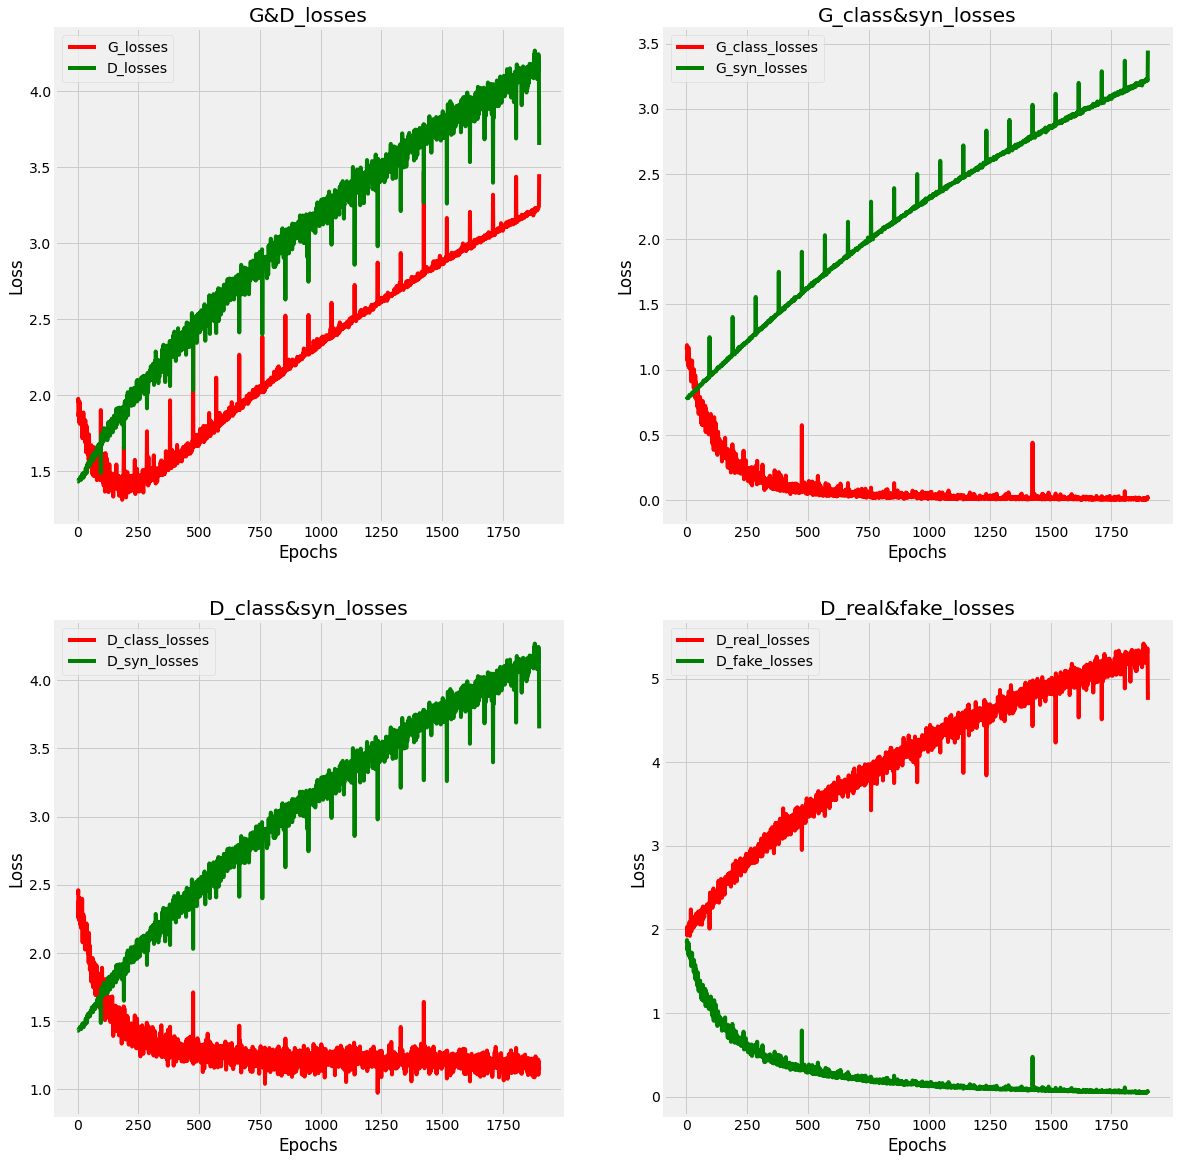

In [27]:
tr_plot(metrics, 0)

In [28]:
def tr_plot(tr_data, start_epoch):
    Epoch_count=len(metrics['Losses']) + start_epoch
    Epochs=[i + 1 for i in range (start_epoch ,Epoch_count)]  
    plt.figure(figsize=(20, 10))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, metrics['Losses'], 'blue', label='Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, metrics['Accuracy'], 'orange', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

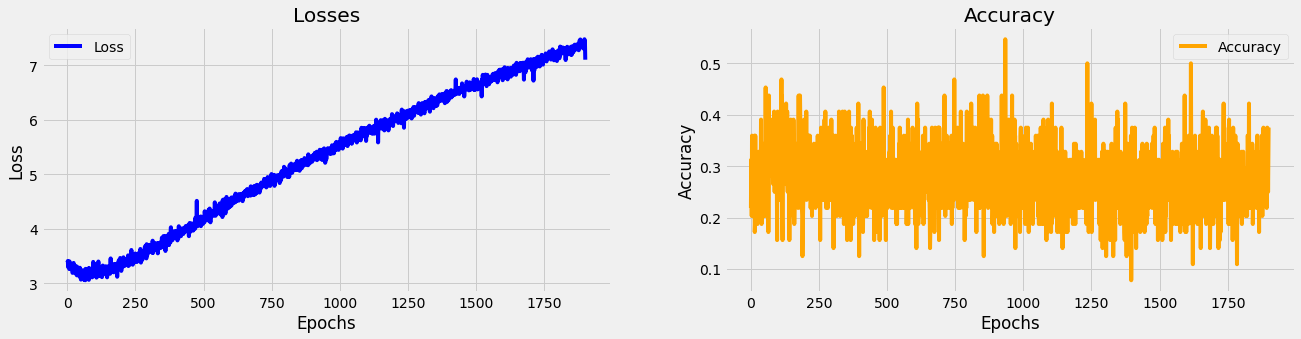

In [29]:
tr_plot(metrics, 0)

In [30]:
def test_gan(generator, discriminator, num_epochs, metrics, loader):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, device=device)
    test_label = torch.randn(batch_size, nb_label, device=device)
    test_fake = generator(test_noise, test_label).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

[Errno 17] File exists: './GANAug/output_images/ACGAN'


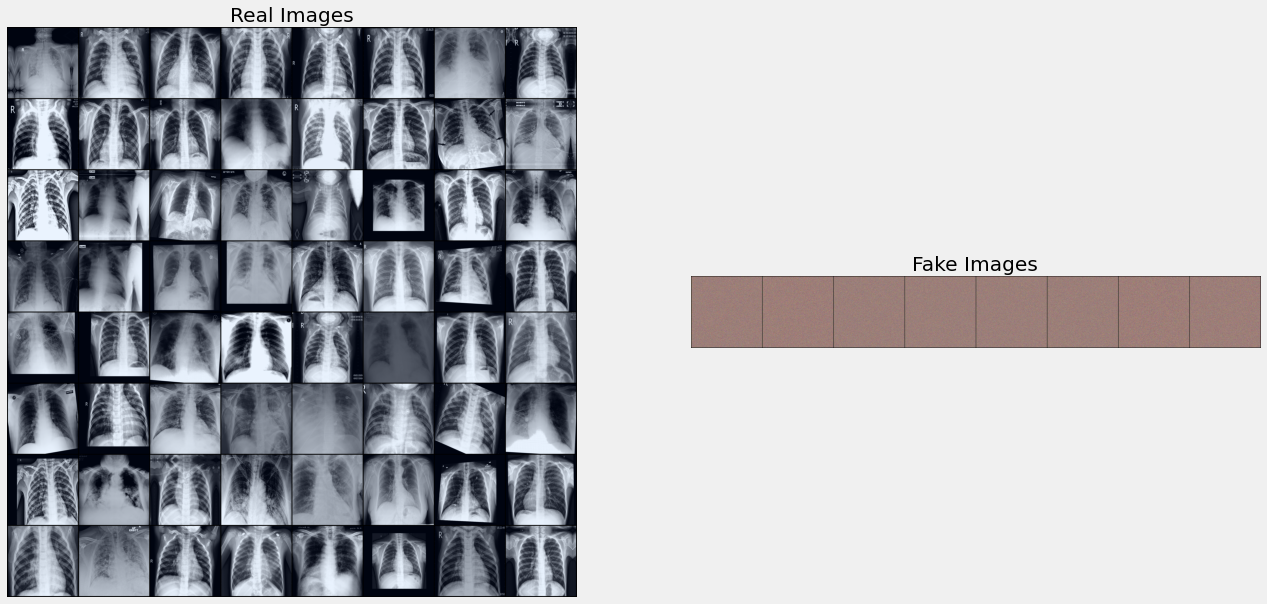

In [31]:
test_gan(generator, discriminator, num_epochs, metrics, train_loader)

In [32]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [33]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)
    plot_gan('Accuracy', num_epochs, metrics['Accuracy'], path, True)

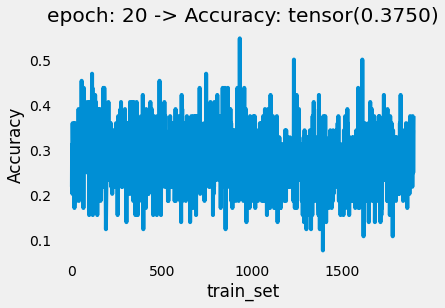

In [34]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s tensor([[0.0433],
        [0.0190],
        [0.0331],
        [0.0580],
        [0.0559],
        [0.0425],
        [0.0257],
        [0.0366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[-2.6369, -2.2758,  5.5198],
        [-6.0014, 13.4793, -6.1507],
        [ 5.1779, -5.9216,  0.2948],
        [-6.1200,  0.7437,  5.9755],
        [ 1.3285, -0.0280, -1.1793],
        [ 0.0313, -0.0771, -0.1124],
        [ 4.1071,  2.2345, -6.3655],
        [ 5.0193, -7.0229,  1.7045]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


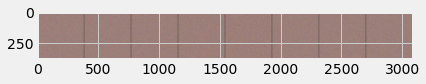

In [35]:
test_img_list = []
test_noise = torch.randn(batch_size, nz, device=device)
test_label = torch.randn(batch_size, nb_label, device=device)
test_img = generator(test_noise, test_label)

s_output, c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0,
        2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2,
        2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2])
Discriminator s tensor([[0.0130],
        [0.0357],
        [0.0440],
        [0.0097],
        [0.0266],
        [0.0115],
        [0.0120],
        [0.0085],
        [0.0187],
        [0.0202],
        [0.0531],
        [0.0506],
        [0.0269],
        [0.0271],
        [0.0226],
        [0.0429],
        [0.0088],
        [0.0211],
        [0.0253],
        [0.0309],
        [0.0508],
        [0.0064],
        [0.0100],
        [0.0057],
        [0.0304],
        [0.0185],
        [0.0144],
        [0.0721],
        [0.0157],
        [0.0391],
        [0.0250],
        [0.0090],
        [0.0156],
        [0.0340],
        [0.0044],
        [0.0193],
        [0.0272],
        [0.0083],
        [0.0443],
        [0.0482],
        [0.0706],
        

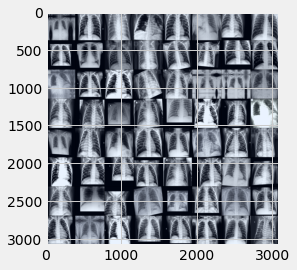

In [36]:
data = next(iter(test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))